In [1]:
# Importing necessary libraries for the analysis.
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import csv
import math
import json
from scipy.ndimage import uniform_filter1d
from tqdm import tqdm
import pandas as pd, datetime
import time
import cartopy.crs as ccrs

from utils import *
from diffusion_networks import *
from sampler import *
from calculations import *
from loss import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cmap_z = plt.cm.get_cmap('viridis')#, 30) #z500
cmap_t = plt.cm.get_cmap('hot')#, 30)     #t850
cmap_u = plt.cm.get_cmap('RdBu_r')#, 10)

# **Data Loading**

## WB

In [3]:
subdir = '/proj/berzelius-2022-164/users/sm_maran/data/wb'


fname= 'z500_t850_t2m_u10_v10_1979-2018_5.625deg.npy'
var_names = ['z500', 't850', 't2m', 'u10', 'v10']
static_data_path = f'{subdir}/orog_lsm_1979-2018_5.625deg.npy'
static_vars = 2

"""
fname= 'z500_t850_1979-2018_5.625deg.npy'
var_names = ['z500', 't850']
static_data_path = None
static_vars = 0
"""

# Load the normalization factors from the JSON file
json_file = f'{subdir}/norm_factors.json'
with open(json_file, 'r') as f:
    statistics = json.load(f)

mean_data = torch.tensor([stats["mean"] for (key, stats) in statistics.items() if key in var_names])
std_data = torch.tensor([stats["std"] for (key, stats) in statistics.items() if key in var_names])

norm_factors = np.stack([mean_data, std_data], axis=0)

print(f"Loaded Mean data tensor: {mean_data}")
print(f"Loaded Std data tensor: {std_data}")

vars = len(mean_data)

Loaded Mean data tensor: tensor([ 5.4113e+04,  2.7459e+02,  2.7852e+02, -8.6000e-02,  2.2600e-01])
Loaded Std data tensor: tensor([3354.9519,   15.5800,   21.2310,    5.5550,    4.7800])


### Hurricane season

In [4]:
# Loading data for scrolling
data = np.load(fname)
climatology = np.mean(data, axis=0)

FileNotFoundError: [Errno 2] No such file or directory: 'z500_t850_t2m_u10_v10_1979-2018_5.625deg.npy'

In [43]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact, IntSlider, Play, VBox, jslink, Dropdown
from IPython.display import display

ti = pd.date_range(datetime.datetime(1979,1,1,0), datetime.datetime(2018,12,31,23), freq='1h')

# Update the show_image function to use plot_global
def show_image(index, var_ch, cmap_z):

    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()})
    ax.set_title(f'{ti[index]} - Channel {var_ch}')
    cf = ax.pcolormesh(lon, lat, data[index, var_ch], transform=ccrs.PlateCarree(), cmap=cmap_z)
    ax.coastlines(resolution='110m')
    #ax.gridlines()
    cb = plt.colorbar(cf, shrink=0.5)
    plt.show()
    
# Create a play widget to automatically slide through the images
play = Play(
    value=0,
    min=0,
    max=data.shape[0] - 1,
    step=1,
    interval=100,  # Interval in milliseconds (adjust this to control speed)
    description="Play",
    disabled=False
)

# Create a slider linked to the play widget
slider = IntSlider(min=0, max=data.shape[0] - 1, step=1, value=0, description='Image Index')

# Link the play widget and the slider
jslink((play, 'value'), (slider, 'value'))

# Create a dropdown to select the colormap
cmap_dropdown = Dropdown(
    options=[cmap_z, cmap_t],
    value=cmap_z,
    description='Colormap'
)

# Create a slider to select the channel (for multi-channel data)
channel_slider = IntSlider(min=0, max=data.shape[1] - 1, step=1, value=0, description='Channel')

# Create an interactive plot
interact_plot = interact(show_image, index=slider, var_ch=channel_slider, cmap_z=cmap_dropdown)

# Combine the play, slider, channel slider, and colormap dropdown in a vertical box layout
controls = VBox([play, slider, channel_slider, cmap_dropdown])

# Display the controls and plot together
display(controls, interact_plot)
pass


interactive(children=(IntSlider(value=0, description='Image Index', max=350639), IntSlider(value=0, descriptio…

<function __main__.show_image(index, var_ch, cmap_z)>

In [20]:
from ipywidgets import interact, IntSlider, Play, VBox, jslink, Dropdown
from IPython.display import display
import datetime

# Create the time index
ti = pd.date_range(datetime.datetime(1979,1,1,0), datetime.datetime(2018,12,31,23), freq='1h')

# Update the show_image function to use plot_global
def show_image(year, hour_in_year, var_ch, cmap_z):
    # Calculate the global index from the year and hour_in_year
    start_of_year = pd.Timestamp(year=year, month=1, day=1, hour=0)
    index = ti.get_loc(start_of_year) + hour_in_year

    fig, ax = plt.subplots(1, 1, figsize=(15,10), subplot_kw={'projection': ccrs.Robinson()})
    ax.set_title(f'{ti[index]} - Channel {var_ch}')
    #cf = ax.pcolormesh(lon, lat, data[index, var_ch] - climatology[var_ch], transform=ccrs.PlateCarree(), cmap=cmap_z)
    cf = ax.pcolormesh(lon, lat, data[index, var_ch], transform=ccrs.PlateCarree(), cmap=cmap_z)
    ax.coastlines(resolution='110m')
    #ax.gridlines()
    cb = plt.colorbar(cf, shrink=0.5)
    plt.show()

# Year Slider (rough scale)
year_slider = IntSlider(min=1979, max=2018, step=1, value=2018, description='Year')

# Hour Slider (fine-tuning within the selected year)
hour_slider = IntSlider(min=0, max=8760 - 1, step=6, value=6024, description='Hour in Year')

# Update the hour slider limits dynamically based on the selected year
def update_hour_slider_limits(*args):
    year = year_slider.value
    # Adjust max based on whether it's a leap year
    if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0):
        hour_slider.max = 8784 - 1  # Leap year (366 days)
    else:
        hour_slider.max = 8760 - 1  # Common year (365 days)

# Link the update function to the year slider
year_slider.observe(update_hour_slider_limits, names='value')

# Create a dropdown to select the colormap
cmap_dropdown = Dropdown(
    options=[cmap_z, cmap_t],
    value=cmap_z,
    description='Colormap'
)

# Create a slider to select the channel (for multi-channel data)
channel_slider = IntSlider(min=0, max=data.shape[1] - 1, step=1, value=0, description='Channel')

# Create an interactive plot
interact_plot = interact(show_image, year=year_slider, hour_in_year=hour_slider, var_ch=channel_slider, cmap_z=cmap_dropdown)

# Combine the controls in a vertical box layout
controls = VBox([year_slider, hour_slider, channel_slider, cmap_dropdown])

# Display the controls and plot together
display(controls, interact_plot)


interactive(children=(IntSlider(value=2018, description='Year', max=2018, min=1979), IntSlider(value=6024, des…

<function __main__.show_image(year, hour_in_year, var_ch, cmap_z)>

In [75]:
for previous, current, time_label in test_time_series_loader:
        break
    

347928


## Data

In [5]:
# WB Dataset
batch_size = 1024
max_lead_time = 24*10 # 24*10
lead_time_max = 240
dt = 3

initial_times = [0, -dt]

lead_time_range = [dt, max_lead_time, dt]

random_lead_time = 0

spacing = 1
spinup = 0
ti = pd.date_range(datetime.datetime(1979,1,1,0), datetime.datetime(2018,12,31,23), freq='1h')
n_train = sum(ti.year <= 2015)
n_val = sum((ti.year >= 2016) & (ti.year <= 2017))

# TEST
#end_date = datetime.datetime(2018, 9, 12, 0)
#n_val = sum((ti.year >= 2016) & (ti < end_date))

n_samples = len(ti)
sample_counts = (n_samples, n_train, n_val)

dataset_path = Path(f'{subdir}/{fname}')

dx = 32
dy = 64
grid_dimensions = (vars, dx, dy)

offset = 2**7

WB_kwargs = {
            'dataset_path':     dataset_path,
            'sample_counts':    sample_counts,
            'dimensions':       grid_dimensions,
            'max_lead_time':    lead_time_max,
            'norm_factors':     norm_factors,
            'device':           device,
            'spinup':           spinup,
            'spacing':          spacing,
            'dtype':            'float32',
            'offset':           offset,
            'initial_times':    initial_times,
            'lead_time_range':  lead_time_range,
            'static_data_path': static_data_path,
            'random_lead_time': random_lead_time,
            }

kwargs = WB_kwargs

In [6]:
# Way to load a dataset with a specific lead time
lead_time = max_lead_time
train_dataset = QGDataset(lead_time=lead_time,dataset_mode='train', **WB_kwargs)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = QGDataset(lead_time=lead_time, dataset_mode='val', **WB_kwargs)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



# Way to load a dataset with lead time following a distribution given by update_k_per_batch
kmin = dt
kmax = max_lead_time
d = dt

update_k_per_batch = get_uniform_k_dist_fn(kmin, kmax, d)

train_time_dataset = QGDataset(lead_time=kmax, dataset_mode='train', **WB_kwargs)
train_batch_sampler = DynamicKBatchSampler(train_time_dataset, batch_size=batch_size, drop_last=True, k_update_callback=update_k_per_batch, shuffle=True)
train_time_loader = DataLoader(train_time_dataset, batch_sampler=train_batch_sampler)

val_time_dataset = QGDataset(lead_time=max_lead_time, dataset_mode='val', **WB_kwargs)
val_batch_sampler = DynamicKBatchSampler(val_time_dataset, batch_size=batch_size, drop_last=True, k_update_callback=update_k_per_batch, shuffle=True)
val_time_loader = DataLoader(val_time_dataset, batch_sampler=val_batch_sampler)


# Way to load a single trajectory. Only uses 1 batch.

k_series = kmin + d * np.arange(0, 1 + (kmax-kmin)//d)

val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **WB_kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

test_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='test', **WB_kwargs)
test_time_series_loader = DataLoader(test_time_series_dataset, batch_size=1, shuffle=False)

In [169]:
stds_directory = save_directory = f"{subdir}/residual_stds"

precomputed_std = []

for var_name in var_names:
    file_path = f'{stds_directory}/WB_{var_name}.txt'
    std_values = torch.tensor(np.loadtxt(file_path, delimiter=' ')[:, 1], dtype=torch.float32).to(device)
    precomputed_std.append(std_values)

precomputed_std = torch.stack([res_std for res_std in precomputed_std], axis=1)

precomputed_std = precomputed_std[:max_lead_time]

print("Shape:", precomputed_std.shape)

def residual_scaling(x):
    if x.ndim == 0:
        x = x.unsqueeze(0)  
    indices = x.to(dtype=int) - 1
    
    return precomputed_std[indices].view(x.shape[0], vars, 1, 1)

Shape: torch.Size([24, 5])


In [168]:
fnm_ll = f'{subdir}/latlon_500hPa_1979-2018_5.625deg.npz'
buf = np.load(fnm_ll)
lat, lon = buf['arr_0'], buf['arr_1']

wmse = AreaWeightedMSELoss(lat, lon, device)

wmse_plot = calculate_AreaWeightedRMSE(lat, lon, device).diff
calculate_WRMSE = calculate_AreaWeightedRMSE(lat, lon, device).calculate
calculate_WSkill = calculate_AreaWeightedRMSE(lat, lon, device).skill
calculate_WSpread = calculate_AreaWeightedRMSE(lat, lon, device).spread
calculate_WCRPS = calculate_AreaWeightedRMSE(lat, lon, device).CRPS
calculate_WScores = calculate_AreaWeightedRMSE(lat, lon, device).skill_and_spread
calculate_WMAE = calculate_AreaWeightedRMSE(lat, lon, device).mae

In [ ]:
mean_data = mean_data.to(device)
std_data = std_data.to(device)
def renormalize(x, mean_ar=mean_data, std_ar=std_data):
    x = x * std_ar[None, :, None, None] + mean_ar[None, :, None, None]
    return x

### Scaling function

In [ ]:
# Function to calculate the mean and standard deviation for each variable
def calculate_residual_mean_std(loader, device):
    mean_data_latent = 0.0
    std_data_latent = 0.0
    count = 0
    
    with torch.no_grad():
        for current, next, _ in loader:
            # Move tensors to the specified device (CPU/GPU)
            current = current.to(device)
            next = next.to(device)
            
            # Compute residuals (differences)
            inputs = next - current
            count += inputs.size(0)
            
            # Accumulate the sum and squared sum for mean and std calculation
            mean_data_latent += torch.sum(inputs, dim=(0,2,3))
            std_data_latent += torch.sum(inputs ** 2, dim=(0,2,3))
            break
            
        
        # Normalize by the total count to get the mean and standard deviation
        count = count * inputs[0, 0].cpu().detach().numpy().size
        mean_data_latent /= count
        std_data_latent = torch.sqrt(std_data_latent / count - mean_data_latent ** 2)
    
    return mean_data_latent, std_data_latent

# Initialize variables
lead_time = 1
max_lead_time = 24 * 10  # Define the maximum lead time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bs = 10000
# Initialize the datasets and loaders
train_dataset = QGDataset(lead_time=lead_time, dataset_mode='train', **kwargs)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

# Prepare the ks array for lead times
ks = np.arange(lead_time, max_lead_time + 1, 1)

# Initialize a dictionary to store stds for each variable
stds_dict = {var_name: [] for var_name in ['z500', 't850', 't2m', 'u10', 'v10']}

# Iterate over lead times and calculate the standard deviation for each variable
for k in (ks):
    train_dataset.set_lead_time(k)
    
    mean_k, std_latent_k = calculate_residual_mean_std(train_loader, device)
    print(k, std_latent_k)
    for i, var_name in enumerate(stds_dict):
        stds_dict[var_name].append(std_latent_k[i].item())
    
    #print(f"Lead Time {k}: Mean = {mean_k.mean()}, Std = {std_latent_k}")

# Save the standard deviations to files
save_directory = f"{subd}/residual_stds/new"
for var_name, stds in stds_dict.items():
    # Generate the content for each variable's std file
    stds_content = "\n".join([f"{ks[i]} {std}" for i, std in enumerate(stds)])
    
    # Write the content to respective file
    file_path = f"{save_directory}/WB_{var_name}.txt"
    with open(file_path, "w") as file:
        file.write(stds_content)

    print(f"Standard deviations for {var_name} saved to {file_path}")

plt.figure(figsize=(10, 6))
for var_name, stds in stds_dict.items():
    plt.plot(ks, stds, label=f'{var_name} std')

plt.title('Standard Deviations vs Lead Time')
plt.xlabel('Lead Time')
plt.ylabel('Standard Deviation')
plt.legend()
plt.grid(True)
plt.show()

# **Diffusion**

## Sampling

In [128]:
def generate_ensemble_from_single_random(model, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler):
    model.eval()

    for previous, current, time_label in selected_loader:
        time_labels = torch.ones(n_ens, device=device, dtype=int) * time_label[0]
        previous_unbatched = previous[0].unsqueeze(0).to(device)
        current_unbatched = current[0].unsqueeze(0).to(device)
        break
    
    with torch.no_grad():
        class_labels = previous_unbatched.repeat(n_ens, 1, 1, 1)
        
        previous_state = previous_unbatched[:,:vars]
        latents = torch.randn_like(previous_state.repeat(n_ens, 1, 1, 1), device=device)
        predicted_residuals = sampler_fn(model, latents, class_labels, time_labels /lead_time_max, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        predicted_state = predicted_residuals #* residual_scaling(time_label[0]) + previous_state

        predicted = predicted_state.to(torch.float32)

        predicted_unnormalized = renormalize(predicted)
        current_unnormalized = renormalize(current_unbatched)
        previous_unnormalized = renormalize(previous_state)

        predicted_unnormalized = predicted_unnormalized.view(n_ens, current_unbatched.size(0), current_unbatched.size(1), current_unbatched.size(2), current_unbatched.size(3))

    return predicted_unnormalized, current_unnormalized, previous_unnormalized

def generate_ensemble_from_batch(model, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    previous, current, time_labels = next(iter(selected_loader))
    lead_time = time_labels[0].item()

    with torch.no_grad():
        previous = previous.to(device)
        current = current.to(device)
        previous_state = previous[:,:vars].repeat(n_ens, 1, 1, 1)

        class_labels = previous.repeat(n_ens, 1, 1, 1)
        time_labels = torch.ones(class_labels.shape[0], device=device, dtype=int) * lead_time /lead_time_max

        latents = torch.randn_like(previous_state, device=device)
        
        predicted_residuals = sampler_fn(model, latents, class_labels, time_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        predicted_latent = predicted_residuals# * residual_scaling(torch.tensor(lead_time)) + previous_state
        
        predicted = predicted_latent
        
        predicted_unnormalized = renormalize(predicted)
        current_unnormalized = renormalize(current)

        predicted_unnormalized = predicted_unnormalized.view(n_ens, current.size(0), current.size(1), current.size(2), current.size(3))

    return predicted_unnormalized, current_unnormalized

# Noise inflation test
def interpolate_latents(alpha, lat1, lat2):
    return (1-alpha).sqrt()*lat1 + (alpha).sqrt()*lat2

def generate_ensemble_from_time_series(model, n_ens=10, selected_loader = val_time_series_loader, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    previous, current, time_labels = next(iter(selected_loader))

    with torch.no_grad():
        previous = previous.to(device)
        current = current.view(-1, vars, current.shape[2], current.shape[3]).to(device)

        previous_state = previous[:,:vars]#.repeat(current.shape[0] * n_ens, 1, 1, 1)

        class_labels = previous.repeat(current.shape[0] * n_ens, 1, 1, 1)
        time_labels = time_labels.flatten().to(device).repeat(n_ens)

        latent_shape = (n_ens, 1, current.shape[2], current.shape[3])
        latents = torch.randn(latent_shape, device=device)
        latents = latents.repeat(1, vars, 1, 1)
        latents = latents.repeat_interleave(current.shape[0], dim=0)

        """
        # Adding a little bit of noise
        latents_eps = torch.randn_like(latents)
        eps = torch.linspace(0.07, 0.01, current.shape[0], device=device).repeat(n_ens).view((n_ens*eps.shape[0], 1, 1, 1))
        latents = interpolate_latents(eps, latents, latents_eps)
        """
        
        predicted_residuals = sampler_fn(model, latents, class_labels, time_labels /lead_time_max, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        predicted_latent = predicted_residuals# * residual_scaling(time_labels) + previous_state
        predicted = predicted_latent
        
        predicted_unnormalized = renormalize(predicted)
        current_unnormalized = renormalize(current)
        previous_unnormalized = renormalize(previous_state)

        predicted_unnormalized = predicted_unnormalized.view(n_ens, current.size(0), current.size(1), current.size(2), current.size(3))
        
    return predicted_unnormalized, current_unnormalized, previous_unnormalized

In [129]:
def generate_ar_ensemble_from_time_series(model, n_ens=10, selected_loader = val_time_series_loader, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    previous, current, time_labels = next(iter(selected_loader))

    with torch.no_grad():
        previous = previous.to(device)
        current = current.view(-1, vars, current.shape[2], current.shape[3]).to(device)

        #previous_state = previous[:,:vars].repeat(current.shape[0] * n_ens, 1, 1, 1)
        previous_state = previous[:,:vars]#.repeat(n_ens, 1, 1, 1)
        #class_labels = previous.repeat(current.shape[0] * n_ens, 1, 1, 1)
        class_labels = previous.repeat(n_ens, 1, 1, 1)
        time_labels = time_labels.flatten()[0].to(device).repeat(n_ens)

        latent_shape = (n_ens, 1, current.shape[2], current.shape[3])
        latents = torch.randn(latent_shape, device=device)
        latents = latents.repeat(1, vars, 1, 1)
        #latents = latents.repeat_interleave(current.shape[0], dim=0)

        # Test
        latent_shape = latents.shape
        predicted_combined = torch.zeros((n_ens, current.shape[0], vars, current.shape[2], current.shape[3]), device=device)
        
        for i in range(current.shape[0]):
            latents = torch.randn(latent_shape, device=device)
            predicted_residuals = sampler_fn(model, latents, class_labels, time_labels /lead_time_max, 
                                             sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
            predicted_latent = predicted_residuals #* residual_scaling(time_labels) + previous_state
            predicted = predicted_latent

            #previous_state = predicted
            predicted_combined[:, i] = predicted
            if static_vars != 0:
                class_labels = torch.cat((predicted, class_labels[:,:vars], class_labels[:, -static_vars:]), dim=1)
            else:
                class_labels = torch.cat((predicted, class_labels[:,:vars]), dim=1)
            
        
        predicted = predicted_combined
        predicted_unnormalized = renormalize(predicted)
        current_unnormalized = renormalize(current)
        previous_unnormalized = renormalize(previous_state)

        predicted_unnormalized = predicted_unnormalized.view(n_ens, current.size(0), current.size(1), current.size(2), current.size(3))
        
    return predicted_unnormalized, current_unnormalized, previous_unnormalized

In [130]:
def generate_det_forecast_from_batch(model, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    previous, current, time_labels = next(iter(selected_loader))
    lead_time = time_labels[0].item()

    with torch.no_grad():
        previous = previous.to(device)
        current = current.to(device)
        previous_state = previous[:,:vars].repeat(n_ens, 1, 1, 1)

        class_labels = previous.repeat(n_ens, 1, 1, 1)
        time_labels = torch.ones(class_labels.shape[0], device=device, dtype=int) * lead_time /lead_time_max
        
        predicted = model(class_labels, time_labels)
                
        predicted_unnormalized = renormalize(predicted)
        current_unnormalized = renormalize(current)

        predicted_unnormalized = predicted_unnormalized.view(n_ens, current.size(0), current.size(1), current.size(2), current.size(3))

    return predicted_unnormalized, current_unnormalized

def generate_det_forecast_from_time_series(model, n_ens=10, selected_loader = val_time_series_loader, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    previous, current, time_labels = next(iter(selected_loader))

    with torch.no_grad():
        previous = previous.to(device)
        current = current.view(-1, vars, current.shape[2], current.shape[3]).to(device)

        previous_state = previous[:,:vars].repeat(current.shape[0] * n_ens, 1, 1, 1)

        class_labels = previous.repeat(current.shape[0] * n_ens, 1, 1, 1)
        time_labels = time_labels.flatten().to(device).repeat(n_ens)

        #latent_shape = (n_ens, 1, current.shape[2], current.shape[3])
        #latents = torch.randn(latent_shape, device=device)
        #latents = latents.repeat(1, vars, 1, 1)
        #latents = latents.repeat_interleave(current.shape[0], dim=0)

        predicted = model(class_labels, time_labels/lead_time_max)
        #predicted_residuals = sampler_fn(model, latents, class_labels, time_labels /lead_time_max, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        #predicted_latent = predicted_residuals# * residual_scaling(time_labels) + previous_state
        #predicted = predicted_latent
        
        predicted_unnormalized = renormalize(predicted)
        current_unnormalized = renormalize(current)
        previous_unnormalized = renormalize(previous_state)

        predicted_unnormalized = predicted_unnormalized.view(n_ens, current.size(0), current.size(1), current.size(2), current.size(3))
        
    return predicted_unnormalized, current_unnormalized, previous_unnormalized

def generate_ar_det_forecast_from_time_series(model, n_ens=1, selected_loader = val_time_series_loader, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    previous, current, time_labels = next(iter(selected_loader))

    with torch.no_grad():
        previous = previous.to(device)
        current = current.view(-1, vars, current.shape[2], current.shape[3]).to(device)

        #previous_state = previous[:,:vars].repeat(current.shape[0] * n_ens, 1, 1, 1)
        previous_state = previous[:,:vars]#.repeat(n_ens, 1, 1, 1)
        #class_labels = previous.repeat(current.shape[0] * n_ens, 1, 1, 1)
        class_labels = previous.repeat(n_ens, 1, 1, 1)
        time_labels = time_labels.flatten()[0].to(device).repeat(n_ens)

        #latent_shape = (n_ens, 1, current.shape[2], current.shape[3])
        #latents = torch.randn(latent_shape, device=device)
        #latents = latents.repeat(1, vars, 1, 1)
        #latents = latents.repeat_interleave(current.shape[0], dim=0)

        predicted_combined = torch.zeros((n_ens, current.shape[0], vars, current.shape[2], current.shape[3]), device=device)
        
        for i in range(current.shape[0]):
            predicted = model(class_labels, time_labels/lead_time_max)
            #predicted_residuals = sampler_fn(model, latents, class_labels, time_labels /lead_time_max, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
            #predicted_latent = predicted_residuals #* residual_scaling(time_labels) + previous_state
            #predicted = predicted_latent

            predicted_combined[:, i] = predicted

            class_labels = predicted#torch.cat((predicted, class_labels[:,:vars]), dim=1)
            
        
        predicted = predicted_combined
        predicted_unnormalized = renormalize(predicted)
        current_unnormalized = renormalize(current)
        previous_unnormalized = renormalize(previous_state)

        predicted_unnormalized = predicted_unnormalized.view(n_ens, current.size(0), current.size(1), current.size(2), current.size(3))
        
    return predicted_unnormalized, current_unnormalized, previous_unnormalized

def generate_det_forecast_from_time_series(model, n_ens=10, selected_loader = val_time_series_loader, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    previous, current, time_labels = next(iter(selected_loader))

    with torch.no_grad():
        previous = previous.to(device)
        current = current.view(-1, vars, current.shape[2], current.shape[3]).to(device)

        previous_state = previous[:,:vars].repeat(current.shape[0] * n_ens, 1, 1, 1)

        class_labels = previous.repeat(current.shape[0] * n_ens, 1, 1, 1)
        time_labels = time_labels.flatten().to(device).repeat(n_ens)

        #latent_shape = (n_ens, 1, current.shape[2], current.shape[3])
        #latents = torch.randn(latent_shape, device=device)
        #latents = latents.repeat(1, vars, 1, 1)
        #latents = latents.repeat_interleave(current.shape[0], dim=0)

        predicted = model(class_labels, time_labels/lead_time_max)
        #predicted_residuals = sampler_fn(model, latents, class_labels, time_labels /lead_time_max, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        #predicted_latent = predicted_residuals# * residual_scaling(time_labels) + previous_state
        #predicted = predicted_latent
        
        predicted_unnormalized = renormalize(predicted)
        current_unnormalized = renormalize(current)
        previous_unnormalized = renormalize(previous_state)

        predicted_unnormalized = predicted_unnormalized.view(n_ens, current.size(0), current.size(1), current.size(2), current.size(3))
        
    return predicted_unnormalized, current_unnormalized, previous_unnormalized


In [131]:
def generate_cont_ensemble_from_time_series(model, n_ens=10, selected_loader = val_time_series_loader, sampler_fn=heun_sampler, iterative_steps = 24):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    previous, current, time_labels = next(iter(selected_loader))

    with torch.no_grad():
        previous = previous.to(device)
        current = current.view(-1, vars, current.shape[2], current.shape[3]).to(device)

        time_labels = torch.tensor(np.array([x for x in time_labels[0] if x <= iterative_steps]), device=device)
        num_iterative_steps = current.shape[0] // time_labels.shape[0]
        
        time_label_shape = time_labels.shape[0]

        previous_state = previous[:,:vars]
        class_labels = previous.repeat(time_label_shape * n_ens, 1, 1, 1)

        latent_shape = (n_ens, 1, current.shape[2], current.shape[3])
        latents = torch.randn(latent_shape, device=device)
        latents = latents.repeat(1, vars, 1, 1)
        latents = latents.repeat_interleave(time_label_shape, dim=0)

        time_labels = time_labels.repeat(n_ens)

        # Test
        predicted_combined = torch.zeros((n_ens, current.shape[0], vars, current.shape[2], current.shape[3]), device=device)
        
        for i in range(num_iterative_steps):
            latents = torch.randn(latent_shape, device=device)
            latents = latents.repeat(1, vars, 1, 1)
            latents = latents.repeat_interleave(time_label_shape, dim=0)

            predicted_residuals = sampler_fn(model, latents, class_labels, time_labels /lead_time_max, 
                                                sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
            predicted_latent = predicted_residuals
            predicted = predicted_latent.view(n_ens, time_label_shape, predicted_latent.size(1), predicted_latent.size(2), predicted_latent.size(3))

            predicted_combined[:, i*time_label_shape:(i+1)*time_label_shape] = predicted
            if time_label_shape == 1:
                if static_vars != 0:
                    class_labels = torch.cat((predicted[:,-1], class_labels[:,:vars], class_labels[:, -static_vars:]), dim=1)
                else:
                    class_labels = torch.cat((predicted[:,-1], class_labels[:,:vars]), dim=1)
            else:
                if static_vars != 0:
                    class_labels = torch.cat((predicted[:,-1].repeat_interleave(time_label_shape, dim=0), predicted[:,-2].repeat_interleave(time_label_shape, dim=0), class_labels[:, -static_vars:]), dim=1)

                else:
                    class_labels = torch.cat((predicted[:,-1].repeat_interleave(time_label_shape, dim=0), predicted[:,-2].repeat_interleave(time_label_shape, dim=0)), dim=1)
        
        predicted = predicted_combined
        predicted_unnormalized = renormalize(predicted)
        current_unnormalized = renormalize(current)
        previous_unnormalized = renormalize(previous_state)

        predicted_unnormalized = predicted_unnormalized.view(n_ens, current.size(0), current.size(1), current.size(2), current.size(3))
        
    return predicted_unnormalized, current_unnormalized, previous_unnormalized



In [132]:
def generate_batch_ensemble_from_time_series(model, n_ens=10, selected_loader = val_time_series_loader, sampler_fn=heun_sampler, iterative_steps = 24):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    previous, current, time_labels = next(iter(selected_loader))

    n_samples = current.shape[0]
    n_times = time_labels.shape[1]
    dx = current.shape[2]
    dy = current.shape[3]

    n_conditions = previous.shape[1]

    with torch.no_grad():
        previous = previous.to(device)
        current = current.view(-1, vars, dx, dy).to(device)
        # They end up in (btc1: t1, t2,..., btc2: t1,...)
        
        direct_time_labels = torch.tensor(np.array([x for x in time_labels[0] if x <= iterative_steps]), device=device)
        n_iter = time_labels.shape[1] // direct_time_labels.shape[0]
        
        n_direct = direct_time_labels.shape[0]

        previous_state = previous[:,:vars]
        class_labels = previous.repeat_interleave(n_direct * n_ens, dim=0) # Can not be changed if batchsz > 1

        static_fields = class_labels[:, -static_vars:]

        latent_shape = (n_samples * n_ens, 1, dx, dy)

        direct_time_labels = direct_time_labels.repeat(n_ens * n_samples) # Can not be changed if n_direct > 1

        # Test
        predicted_combined = torch.zeros((n_samples, n_ens, n_times, vars, dx, dy), device=device)
        
        for i in range(n_iter):
            latents = torch.randn(latent_shape, device=device)
            latents = latents.expand(-1, vars, -1, -1)
            latents = latents.repeat_interleave(n_direct, dim=0) # Can not be changed if batchsz > 1 or n_ens >1
            
            predicted = sampler_fn(model, latents, class_labels, direct_time_labels /lead_time_max, 
                                    sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)

            predicted_combined[:, :, i*n_direct:(i+1)*n_direct] = predicted.view(n_samples, n_ens, n_direct, vars, dx, dy)

            predicted = predicted.view(n_samples*n_ens, n_direct, vars, dx, dy)
            class_labels = class_labels.view(n_samples*n_ens*n_direct, n_conditions, dx, dy)

            if n_direct == 1:
                class_labels = torch.cat((predicted[:,-1], class_labels[:,:vars]), dim=1)
            else:
                class_labels = torch.cat((predicted[:,-1], predicted[:,-2]), dim=1).repeat_interleave(n_direct, dim=0) # Can not be changed if batchsz > 1
            
            if static_vars != 0:
                class_labels = torch.cat((class_labels, static_fields), dim=1)

        predicted = predicted_combined
        predicted_unnormalized = renormalize(predicted)
        current_unnormalized = renormalize(current)
        previous_unnormalized = renormalize(previous_state)

        predicted_unnormalized = predicted_unnormalized.view(n_samples, n_ens, n_times, vars, dx, dy)
        current_unnormalized = current_unnormalized.view(n_samples, n_times, vars, dx, dy)
        previous_unnormalized = previous_unnormalized.view(n_samples, vars, dx, dy)
        
    return predicted_unnormalized, current_unnormalized, previous_unnormalized

## **Training**

### Deterministic

In [538]:
# Setup for training

forecasting = True

filters = 32
model_type='large'

num_epochs = 10
input_times = (len(initial_times)) * vars

model = DetPrecond(filters=filters, img_channels=input_times, out_channels=vars, img_resolution = 64, model_type=model_type)
print("Num params: ", sum(p.numel() for p in model.parameters()))

model.to(device)
 
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)

loss_fn = WMSELoss(lat, lon, device)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
warmup_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.001, end_factor=1.0, total_iters=1000)
loss_values = []
val_loss_values = []
best_val_loss = float('inf')

# Setup for logging
log_file_path = 'results/training_log.csv'
with open(log_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Epoch', 'Average Training Loss', 'Validation Loss'])


Num params:  3550693


In [14]:
model.load_state_dict(torch.load('/proj/berzelius-2022-164/users/sm_maran/results/2024-09-02/z500_t850_f32_IC[0 -6]_dt6_240_state_residual_deterministic/best_model.pth'))

#model.load_state_dict(torch.load('/proj/berzelius-2022-164/users/sm_maran/results/2024-09-02/z500_t850_f32_IC[0]_dt1_state_residual_deterministic/best_model.pth'))


<All keys matched successfully>

In [20]:
log_interval = len(train_loader) // 10

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    current_loss = 0
    count = 0

    for previous, current, time_label in tqdm(train_time_loader):
        current = current.to(device)
        previous = previous.to(device)
        time_label = time_label.to(device)
        
        count += 1
        optimizer.zero_grad()
        
        with torch.no_grad():
            current_latent = current
            previous_state = previous[:,:vars]
            class_labels = previous
            target_latent = (current_latent)# - previous_state) / residual_scaling(time_label[0])
            
        loss = loss_fn(model, target_latent, class_labels, time_label/lead_time_max)
         
        total_train_loss += loss.item()
        current_loss += loss.item()

        loss.backward()
        optimizer.step()

        if count % log_interval == 0:
            current_loss = current_loss / count
            print(f'Average Loss: {current_loss:.4f}')
            current_loss = 0
            count = 0
        
        warmup_scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for previous, current, time_label in tqdm(val_time_loader):
            current = current.to(device)
            previous = previous.to(device)
            time_label = time_label.to(device)
            
            current_latent = current
            previous_state = previous[:,:vars]
            class_labels = previous

            target_latent = (current_latent)# - previous_state) / residual_scaling(time_label[0])
            
            loss = loss_fn(model, target_latent, class_labels, time_label/lead_time_max)
            
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(val_loader)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'results/best_model.pth')
    
    scheduler.step()
    
    # Log to CSV    
    loss_values.append([avg_train_loss])
    val_loss_values.append(avg_val_loss)
    
    # Log to CSV
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, avg_train_loss, avg_val_loss])
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    torch.save(model.state_dict(), 'final_model.pth')

    # Sampling phase 72h

# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.plot(loss_plot[1:], label='Training Loss', color='blue')

plt.plot(val_loss_values[1:], label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

  0%|                                                                                                                                                       | 0/10131 [00:00<?, ?it/s]

  0%|▎                                                                                                                                             | 18/10131 [00:05<47:28,  3.55it/s]


KeyboardInterrupt: 

### Diffusion

In [126]:
# Setup for training

forecasting = True

filters=32
model_type='large'
time_emb = 1

num_epochs = 10
input_times = (1 + len(initial_times)) * vars + static_vars

model = EDMPrecond(filters=filters, img_channels=input_times, out_channels=vars, img_resolution = 64, 
                   time_emb=time_emb, model_type=model_type, sigma_data=1, sigma_min=0.02, sigma_max=88)
print("Num params: ", sum(p.numel() for p in model.parameters()))

model.to(device)
 
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)

loss_fn = WGCLoss(lat, lon, device, precomputed_std=precomputed_std)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
warmup_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.001, end_factor=1.0, total_iters=1000)
loss_values = []
val_loss_values = []
best_val_loss = float('inf')

# Setup for logging
log_file_path = 'results/training_log.csv'
with open(log_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Epoch', 'Average Training Loss', 'Validation Loss'])


Num params:  3556741


In [18]:
#model.load_state_dict(torch.load('/proj/berzelius-2022-164/users/sm_maran/results/2024-09-01/z500_t850_f32_IC[0, -6]_dt6_state_residual_single-step/best_model.pth'))
#model.load_state_dict(torch.load('/proj/berzelius-2022-164/users/sm_maran/results/2024-09-01/z500_t850_f32_IC[0, -6]_dt6_state_residual_single-step_scaler/best_model.pth'))
#model.load_state_dict(torch.load('/proj/berzelius-2022-164/users/sm_maran/results/2024-09-01/z500_t850_f32_wd-1_IC[0 -6]_dt6_state_residual/best_model.pth'))

# Current interesting
#model.load_state_dict(torch.load('/proj/berzelius-2022-164/users/sm_maran/results/2024-09-04/z500_t850_f32_IC[0, -6]_dt6_state_residual/best_model.pth'))
#model.load_state_dict(torch.load('/proj/berzelius-2022-164/users/sm_maran/results/2024-09-04/z500_t850_f32_IC[0, -6]_dt6_state_residual_res-scale/best_model.pth'))
model.load_state_dict(torch.load('/proj/berzelius-2022-164/users/sm_maran/results/2024-09-04/z500_t850_f32_IC[0, -6]_dt6_state_residual_res-scale_rand-dt/best_model.pth'))
#model.load_state_dict(torch.load('/proj/berzelius-2022-164/users/sm_maran/results/2024-09-04/z500_t850_f32_IC[0, -6]_dt6_state_residual_res-scale_rand-dt-scheduled/final_model.pth'))


# Att träna
# Alla residual
# dt1 med [0 -1 -2 -3] t120
# dt1 med [0 -1 -2 -3] single step


# Only one with dt1 residual (120h)
#model.load_state_dict(torch.load('/proj/berzelius-2022-164/users/sm_maran/results/2024-09-01/z500_t850_f32_wd-1_IC[0 -1]_dt1_state_residual/best_model.pth'))

model.to(device)
pass

In [127]:
# Models run on Sep 9
subd = '/proj/berzelius-2022-164/users/sm_maran/results'
date = '2024-09-20'
#model.load_state_dict(torch.load(f'{subd}/{date}/z500_t850_t2m_u10_v10_orog_lsm_f32_IC[0, -6]_dt6_state_residual_single-step/final_model.pth'))
#model.load_state_dict(torch.load(f'{subd}/{date}/z500_t850_t2m_u10_v10_orog_lsm_f32_IC[0, -6]_dt6_120h_state_residual/final_model.pth'))
pass

# Single step iterative forecasts
'z500_t850_f32_IC[0, -1]_dt1_state_residual_single-step'
model_name = 'z500_t850_f32_IC[0, -3]_dt3_state_residual_single-step'
'/2024-09-01/z500_t850_f32_IC[0, -6]_dt6_state_residual_single-step/best_model.pth'
'z500_t850_f32_IC[0, -12]_dt12_state_residual_single-step'
#model_name = 'z500_t850_f32_IC[0, -24]_dt24_state_residual_single-step'
#model_name='z500_t850_f32_IC[0, -48]_dt48_state_residual_single-step'
#model_name='z500_t850_f32_IC[0, -72]_dt72_state_residual_single-step'
#model_name = 'z500_t850_f32_IC[0, -120]_dt120_state_residual_single-step'

# Initial conditions 6h
'z500_t850_f32_IC[0]_dt6_state_residual_single-step'
'/2024-09-01/z500_t850_f32_IC[0, -6]_dt6_state_residual_single-step/best_model.pth'
'z500_t850_f32_IC[0, -6, -12]_dt6_state_residual_single-step'

# Initial conditions 1h
'z500_t850_f32_IC[0]_dt1_state_residual_single-step'
'z500_t850_f32_IC[0, -1]_dt1_state_residual_single-step'
'z500_t850_f32_IC[0, -1, -2]_dt1_state_residual_single-step'
'z500_t850_f32_IC[0, -1, -2, -3]_dt1_state_residual_single-step'

# Different max lead time 1h
#model_name='z500_t850_f32_IC[0, -1]_dt1_6h_state_residual'
'z500_t850_f32_IC[0, -1]_dt1_12h_state_residual'
#model_name='z500_t850_f32_IC[0, -1]_dt1_24h_state_residual'

# Different max lead time 6h
#model_name = 'z500_t850_f32_IC[0, -6]_dt6_24h_state_residual'
'z500_t850_f32_IC[0, -6]_dt6_48h_state_residual'
'z500_t850_f32_IC[0, -6]_dt6_72h_state_residual'
#model.load_state_dict(torch.load(f'{subd}/2024-09-01/z500_t850_f32_wd-1_IC[0 -6]_dt6_state_residual/best_model.pth')) # 120
#model.load_state_dict(torch.load(f'{subd}/2024-09-04/z500_t850_f32_IC[0, -6]_dt6_state_residual_res-scale_rand-dt/best_model.pth')) # 240


# Sqrt Scaling
#model.load_state_dict(torch.load(f'{subd}/2024-09-09/z500_t850_f32_IC[0, -1]_dt1_120h_state_residual_sqrt-scale/final_model.pth'))
'z500_t850_f32_wd-1_IC[0 -1]_dt1_state_residual'

#model.load_state_dict(torch.load(f'{subd}/2024-09-09/z500_t850_f32_IC[0, -6]_dt6_120h_state_residual_sqrt-scale/final_model.pth'))
'/2024-09-01/z500_t850_f32_wd-1_IC[0 -6]_dt6_state_residual' #120

#model.load_state_dict(torch.load(f'{subd}/2024-09-09/z500_t850_f32_IC[0, -6]_dt6_240h_state_residual_sqrt-scale/final_model.pth'))
#model.load_state_dict(torch.load(f'{subd}/2024-09-04/z500_t850_f32_IC[0, -6]_dt6_state_residual_res-scale_rand-dt/best_model.pth'))

#model_name = 'z500_t850_f32_IC[0, -2]_dt2_24h_state_residual'
# New vars
#model_name='z500_t850_t2m_u10_v10_orog_lsm_f32_IC[0, -6]_dt6_state_residual_single-step'
#model_name='z500_t850_t2m_u10_v10_orog_lsm_f32_IC[0, -6]_dt6_120h_state_residual'
'z500_t850_t2m_u10_v10_orog_lsm_f32_IC[0, -6]_dt6_120h_state_residual_sqrt-scale'
#model_name = 'z500_t850_t2m_u10_v10_orog_lsm_IC[0, -2]_dt2_24h_state_residual'

model_name='continuous-24+6h-[0, -24]'

model.load_state_dict(torch.load(f'{subd}/{date}/{model_name}/best_model.pth'))

model.to(device)
pass

In [ ]:
log_interval = len(train_loader) // 5

for epoch in range(num_epochs):
    lead_time_range = [dt, int(dt * (1 + 240*epoch/num_epochs//dt)), dt]
    train_time_loader.dataset.set_lead_time_range(lead_time_range)
    model.train()
    total_train_loss = 0
    current_loss = 0
    count = 0

    for previous, current, time_label in tqdm(train_time_loader):
        current = current.to(device)
        previous = previous.to(device)
        time_label = time_label.to(device)
        
        count += 1
        optimizer.zero_grad()
        
        with torch.no_grad():
            current_latent = current
            previous_state = previous[:,:vars]
            class_labels = previous# torch.cat((previous, static_fields), dim=0)

            target_latent = (current_latent - previous_state) / residual_scaling(time_label[0])
            
        loss = loss_fn(model, target_latent, class_labels, time_label/lead_time_max)
         
        total_train_loss += loss.item()
        current_loss += loss.item()

        loss.backward()
        optimizer.step()

        if count % log_interval == 0:
            current_loss = current_loss / count
            print(f'Average Loss: {current_loss:.4f}')
            current_loss = 0
            count = 0
        
        warmup_scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for previous, current, time_label in tqdm(val_loader):
            current = current.to(device)
            previous = previous.to(device)
            time_label = time_label.to(device)
            
            current_latent = current
            previous_state = previous[:,:vars]
            class_labels = previous

            target_latent = (current_latent - previous_state) / residual_scaling(time_label[0])
            
            loss = loss_fn(model, target_latent, class_labels, time_label/lead_time_max)
            
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(val_loader)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'results/best_model.pth')
    
    scheduler.step()
    
    # Log to CSV    
    loss_values.append([avg_train_loss])
    val_loss_values.append(avg_val_loss)
    
    # Log to CSV
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, avg_train_loss, avg_val_loss])
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    torch.save(model.state_dict(), 'final_model.pth')

    # Sampling phase 72h
    ## Val
    forecast, truth, _ = generate_ensemble_from_single_random(model, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler)
    wrmse = calculate_WRMSE(forecast, truth)
    skill, spread, ratio = calculate_skill_and_spread_score(forecast, truth)
    crps = calculate_CRPS(forecast, truth)
    print(f'Val\t: WRMSE: {np.mean(wrmse.flatten()):0f}, +- {np.std(wrmse.flatten()):0f}')
    #print(f"Val\t: WRMSE: {wrmse[0][0]:.2f}, Skill: {skill[0]:.2f}, Spread: {spread[0]:.2f}, Ratio: {ratio[0]:.3f}, CRPS: {crps[0]:.3f}")

    ## Train
    forecast, truth, _ = generate_ensemble_from_single_random(model, n_ens=10, selected_loader = train_loader, sampler_fn=heun_sampler)
    wrmse = calculate_WRMSE(forecast, truth)
    skill, spread, ratio = calculate_skill_and_spread_score(forecast, truth)
    crps = calculate_CRPS(forecast, truth)
    print(f'Train\t: WRMSE: {np.mean(wrmse.flatten()):0f}, +- {np.std(wrmse.flatten()):0f}')
    #print(f"Train\t: WRMSE: {wrmse[0][0]:.2f}, Skill: {skill[0]:.2f}, Spread: {spread[0]:.2f}, Ratio: {ratio[0]:.3f}, CRPS: {crps[0]:.3f}")


# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.plot(loss_plot[1:], label='Training Loss', color='blue')

plt.plot(val_loss_values[1:], label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

## Evaluating

In [ ]:
model.eval()
total_val_loss = 0
with torch.no_grad():
    for previous, current, time_label in tqdm(val_time_loader):
        
        current = current.to(device)
        previous = previous.to(device)
        time_label = time_label.to(device)
        
        current_latent = current
        class_labels = previous
        previous_target = previous[:,:vars]

        target_latent = (current_latent - previous_target) / residual_scaling(time_label[0])
        
        loss = loss_fn(model, target_latent, class_labels, time_label/lead_time_max)
        total_val_loss += loss.item()
        
avg_val_loss = total_val_loss / len(val_time_loader)
avg_val_loss

In [ ]:
cmap_z = plt.cm.get_cmap('viridis')     #t850
cmap_t = plt.cm.get_cmap('hot')     #t850

# Assuming `truth`, `forecast`, and `previous` are tensors or numpy arrays

tim = 1

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(10,5))
# Plot the first image
axs[0, 0].imshow(target_latent[tim, 0].cpu(), cmap_z)  # Add cmap if necessary
axs[0, 0].axis('off')  # Remove axis labels
axs[0,0].set_title('Residual')


# Plot the second image
axs[0, 1].imshow(((current_latent[tim, 0])).cpu(),cmap_z)  # Add cmap if necessary
axs[0, 1].axis('off')  # Remove axis labels
axs[0, 1].set_title('Truth')

# Plot the third image
axs[1, 0].imshow((target_latent[tim,1]).cpu(), cmap_t)  # Add cmap if necessary
axs[1, 0].axis('off')  # Remove axis labels

# Plot the fourth image (commented out in your code)
# If you want to add it back, uncomment the following lines:
axs[1, 1].imshow((current_latent[tim, 1]).cpu(), cmap_t)  # Add cmap if necessary
axs[1, 1].axis('off')  # Remove axis labels

# If you don't want to include the fourth image, remove the axis altogether
#fig.delaxes(axs[1, 1])
#fig.delaxes(axs[1, 0])

# Show the plot
plt.show()


In [ ]:
# Way to load a dataset with a specific lead time
lead_time = max_lead_time
val_dataset = QGDataset(lead_time=lead_time, dataset_mode='val', **WB_kwargs)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [ ]:
target_time = 24*5

train_dataset.set_lead_time(target_time)
val_dataset.set_lead_time(target_time)

# Sampling phase 72h
forecast, truth, previous = generate_ensemble_from_single_random(model, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler)
wrmse = calculate_WRMSE(forecast, truth)
skill = calculate_WSkill(forecast, truth)
spread = calculate_WSpread(forecast, truth)


for channel in range(wrmse.shape[-1]):  # Loop over the last dimension (channels)calculate_WSkill(forecast, truth_plot)
    print(f'Channel {channel + 1}:')
    print(f'{target_time}h - WRMSE: {np.mean(wrmse[..., channel].flatten()):.2f}, '
          f'Skill: {np.mean(skill[..., channel].flatten()):.2f}, '
          f'Spread: {np.mean(spread[..., channel].flatten()):.2f}')

In [ ]:
val_dataset.set_lead_time(24*3)
forecast, truth = generate_ensemble_from_batch(model, n_ens=3, selected_loader = val_loader, sampler_fn=heun_sampler)
wrmse_1 = calculate_WRMSE(forecast, truth)
skill_1 = calculate_WSkill(forecast, truth)
spread_1 = calculate_WSpread(forecast, truth)

val_dataset.set_lead_time(24*5)
forecast, truth = generate_ensemble_from_batch(model, n_ens=3, selected_loader = val_loader, sampler_fn=heun_sampler)
wrmse_2 = calculate_WRMSE(forecast, truth)
skill_2 = calculate_WSkill(forecast, truth)
spread_2 = calculate_WSpread(forecast, truth)

for channel in range(wrmse_1.shape[-1]):  # Loop over the last dimension (channels)
    print(f'Channel {channel + 1}:')
    print(f'  3d - WRMSE: {np.mean(wrmse_1[..., channel].flatten()):.2f}, '
          f'Skill: {np.mean(skill_1[..., channel].flatten()):.2f}, '
          f'Spread: {np.mean(spread_1[..., channel].flatten()):.2f}')
    print(f'  5d - WRMSE: {np.mean(wrmse_2[..., channel].flatten()):.2f}, '
          f'Skill: {np.mean(skill_2[..., channel].flatten()):.2f}, '
          f'Spread: {np.mean(spread_2[..., channel].flatten()):.2f}', flush=True)

In [ ]:
import matplotlib.pyplot as plt

cmap_z = plt.cm.get_cmap('viridis', 30)     #t850
cmap_t = plt.cm.get_cmap('hot', 30)     #t850


# Assuming `truth`, `forecast`, and `previous` are tensors or numpy arrays
ens_ch = 2
tim = 4

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(10,5))

# Plot the first image
axs[0, 0].imshow((truth[tim, 0]).cpu(),cmap_z)  # Add cmap if necessary
axs[0, 0].axis('off')  # Remove axis labels
axs[0,0].set_title('Truth')

# Plot the second image
axs[0, 1].imshow(((forecast[ens_ch, tim, 0])).cpu(),cmap_z)  # Add cmap if necessary
axs[0, 1].axis('off')  # Remove axis labels
axs[0, 1].set_title('Forecast')

# Plot the third image
axs[1, 0].imshow((truth[tim, 1]).cpu(), cmap_t)  # Add cmap if necessary
axs[1, 0].axis('off')  # Remove axis labels

# Plot the fourth image (commented out in your code)
# If you want to add it back, uncomment the following lines:
axs[1, 1].imshow((forecast[ens_ch, tim, 1]).cpu(), cmap_t)  # Add cmap if necessary
axs[1, 1].axis('off')  # Remove axis labels

# If you don't want to include the fourth image, remove the axis altogether
#fig.delaxes(axs[1, 1])
#fig.delaxes(axs[1, 0])

# Show the plot
plt.show()


## **Generation**

In [ ]:
def OLD_generate_ensemble_from_single_random(model, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler):
    model.eval()

    for previous, current, time_label in selected_loader:
        time_labels = torch.ones(n_ens, device=device, dtype=int) * time_label[0]
        previous_unbatched = previous[0].unsqueeze(0).to(device)
        current_unbatched = current[0].unsqueeze(0).to(device)
        break
    
    with torch.no_grad():
        previous_latent = previous_unbatched

        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        
        latents = torch.randn_like(class_labels, device=device)
        #latents = torch.randn_like(previous_latent, device=device).repeat(n_ens, 1, 1, 1)

        predicted_residuals = sampler_fn(model, latents, class_labels, time_labels /lead_time_max, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        predicted_latent = previous_latent + predicted_residuals * residual_scaling(time_label[0])

        predicted = predicted_latent.to(torch.float32)

        predicted_unnormalized = predicted * std_data + mean_data
        current_unnormalized = current_unbatched * std_data + mean_data
        previous_unnormalized = previous_unbatched * std_data + mean_data

        predicted_unnormalized = predicted_unnormalized.view(n_ens, 1, previous.size(1), previous.size(2), previous.size(3))

    return predicted_unnormalized, current_unnormalized, previous_unnormalized

#predicted_unnormalized, current_unnormalized, previous_unnormalized = generate_ensemble_from_single_random(model, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler)

def generate_ar_ensemble_from_single_random(model, rollout, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler):
    model.eval()

    for previous, current, time_label in selected_loader:
        time_labels = torch.ones(n_ens, device=device, dtype=int) * time_label[0]
        previous_unbatched = previous[0].unsqueeze(0).to(device)
        current_unbatched = current[0].unsqueeze(0).to(device)
        break
    
    with torch.no_grad():
        previous_latent = previous_unbatched

        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        
        latents = torch.randn_like(class_labels, device=device)

        for i in range(rollout):
            predicted_residuals = sampler_fn(model, latents, class_labels, time_labels /lead_time_max, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)

            predicted_latent = class_labels + predicted_residuals * residual_scaling(time_label[0])
            
            class_labels = predicted_latent
        
        predicted = predicted_latent.to(torch.float32)

        predicted_unnormalized = predicted * std_data + mean_data
        current_unnormalized = current_unbatched * std_data + mean_data
        previous_unnormalized = previous_unbatched * std_data + mean_data

        predicted_unnormalized = predicted_unnormalized.view(n_ens, 1, previous.size(1), previous.size(2), previous.size(3))

    return predicted_unnormalized, current_unnormalized, previous_unnormalized

#predicted_unnormalized, current_unnormalized, previous_unnormalized = generate_ar_ensemble_from_single_random(model, rollout=2, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler)

def OLD_generate_ensemble_from_batch(model, previous, lead_time, n_ens=10, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    with torch.no_grad():
        previous = previous.to(device)
        previous_latent = previous
        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        time_labels = torch.ones(class_labels.shape[0], device=device, dtype=int) * lead_time /lead_time_max

        latents = torch.randn_like(class_labels, device=device)

        predicted_residuals = sampler_fn(model, latents, class_labels, time_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)

        predicted_latent = class_labels + predicted_residuals * residual_scaling(torch.tensor(lead_time))
        predicted = predicted_latent.to(torch.float32)

        predicted_unnormalized = predicted * std_data + mean_data

        predicted_unnormalized = predicted_unnormalized.view(n_ens, previous.size(0), previous.size(1), previous.size(2), previous.size(3))

    return predicted_unnormalized

#predicted_unnormalized = generate_ensemble_from_batch(model, next(iter(val_loader))[0], lead_time, n_ens=1)

def generate_ar_ensemble_from_batch(model, previous, lead_time, rollout, n_ens=10, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    with torch.no_grad():
        previous = previous.to(device)
        previous_latent = previous
        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        time_labels = torch.ones(class_labels.shape[0], device=device, dtype=int) * lead_time /lead_time_max
        latents = torch.randn_like(class_labels, device=device)

        for i in range(rollout):
            predicted_residuals = sampler_fn(model, latents, class_labels, time_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)

            predicted_latent = class_labels + predicted_residuals * residual_scaling(torch.tensor(lead_time))
            
            class_labels = predicted_latent
        
        predicted = predicted_latent.to(torch.float32)

        predicted_unnormalized = predicted * std_data + mean_data

        predicted_unnormalized = predicted_unnormalized.view(n_ens, previous.size(0), previous.size(1), previous.size(2), previous.size(3))

    return predicted_unnormalized

#predicted_unnormalized = generate_ar_ensemble_from_batch(model, next(iter(val_loader))[0], lead_time=10, rollout=3, n_ens=1)

## **Evaluation**

In [27]:
# Could probably do this better
def calculate_climatology(selected_loader):
    mean = 0
    count = 0
    with torch.no_grad():

        for _, current,_ in tqdm(selected_loader):
            current = renormalize(current.to(device))

            u_current = (current[:,3]**2 + current[:,4]**2).sqrt().unsqueeze(1)
            current = torch.cat((current, u_current), dim=1)
            
            mean += torch.sum(current, dim=0)
            count += 1
            break
    
    count = count * current.size(0)
    mean = mean / count
    
    return mean

bs = 10000
# Initialize the datasets and loaders
train_dataset = QGDataset(lead_time=lead_time, dataset_mode='train', **kwargs)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

climatology = calculate_climatology(train_loader)

  0%|                                                                                                                                                                             | 0/33 [00:26<?, ?it/s]


In [69]:
!ls ../../../weather/cont-ens/predictions/

graph-efm_5fields_test_forecasts.zarr  graph-efm_z500_t850_test_forecasts.zarr
graph-efm_5fields_val_forecasts.zarr   graph-efm_z500_t850_val_forecasts.zarr


In [47]:
import xarray as xr
import zarr

var_names = ['z500', 't850', 't2m', 'u10', 'v10']

# Open the dataset using lazy loading
pred_efm = xr.open_zarr('../../../weather/cont-ens/predictions/graph-efm_5fields_test_forecasts.zarr'); 

# Concatenate z500 and t850 along a new 'channel' dimension without loading the data into memory
combined = xr.concat([pred_efm['z500'], pred_efm['t850'], pred_efm['t2m'],  pred_efm['u10'], pred_efm['v10']], dim='channel').assign_coords(channel=var_names)

# Reorder dimensions to (time, realization, prediction_timedelta, channel, latitude, longitude)
combined = combined.transpose('time', 'realization', 'prediction_timedelta', 'channel', 'latitude', 'longitude')

combined = combined.astype('float32')

# Write the combined dataset to Zarr without loading all data into memory
combined_ds = xr.Dataset({'combined': combined})

forecasts = combined_ds['combined']

eval_name='graphefm'

In [25]:
t_kmin = 6
t_kmax = 24*10
t_d = 6
k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=10, shuffle=False)

iterative_steps = 24*10

forecast_fn = save_ensembles
sampler_fn = heun_sampler

save_ensembles(model, n_ens=10, selected_loader = val_time_series_loader, sampler_fn=sampler_fn, iterative_steps=iterative_steps)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [17:49<00:00, 59.42s/it]


In [ ]:
CRPS_dict = {}

In [16]:
calculate_WScores = calculate_AreaWeightedRMSE(lat, lon, device).skill_and_spread_new

In [ ]:
# Need to save the iterative steps also
result_path = f'/proj/berzelius-2022-164/users/sm_maran/results/predictions'

eval_date = '2024-09-22'

"""
# deterministic-iterative-6h
#iterative-24h
#iterative-6h
#continuous-24+6h
#direct-6h
"""

eval_name = 'direct-6h'
dt = 1
max_lead_time = 240

#WB_kwargs['max_lead_time'] = max_lead_time
WB_kwargs['initial_times'] = [0, -dt]

pred_path = f'{result_path}/{eval_date}/{eval_name}'

with open(f'{pred_path}/config.json', 'r') as f:
    metadata = json.load(f)

t_max = metadata['t_max']
t_direct = metadata['t_direct']
t_min = t_direct
t_iter = metadata['t_iter']
n_ens = metadata['n_ens']
eval_batch_size =  metadata['batch_size']
spacing = metadata['spacing']

WB_kwargs['spacing'] = 1

kwargs = WB_kwargs

k_series = t_min + t_direct * np.arange(0, 1 + (t_max-t_min)//t_direct)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='test', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=2, shuffle=False)

iterative_steps = t_iter
n_samples = len(val_time_series_dataset)
n_times = t_max // t_direct
print(n_samples)

#forecasts = zarr.open_array(f'{pred_path}/{eval_name}.zarr', mode='r')

forecasts = np.memmap(f'{pred_path}/{eval_name}.npy',
                     dtype=np.float32, mode='r', shape=(n_samples, n_ens, n_times, vars, dx, dy))


8496


In [99]:
WB_kwargs["lead_time_range"] = [1,240,1]

In [100]:
val_time_dataset = QGDataset(lead_time=max_lead_time, dataset_mode='test', **WB_kwargs)
val_batch_sampler = DynamicKBatchSampler(val_time_dataset, batch_size=batch_size, drop_last=True, k_update_callback=update_k_per_batch, shuffle=False)
val_time_loader = DataLoader(val_time_dataset, batch_sampler=val_batch_sampler)

for previous, current, time_label in tqdm(val_time_loader):
    break

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]


In [16]:
# -----------------------------------------------------
import zarr
zarr_fname = '/proj/berzelius-2022-164/users/sm_maran/dyffusion/results/predictions/predict_0.zarr'
a= zarr.open_array(zarr_fname, mode='r')


In [38]:
a.shape

(8496, 2, 11, 5, 32, 64)

In [27]:
a[:1024,0,0].shape

(1024, 5, 32, 64)

In [111]:
k+=1
print(k)
a[k,0,-1] - current[0].cpu().numpy()


9


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

    

In [218]:
# For doing zarr
import zarr
# Need to save the iterative steps also
result_path = f'/proj/berzelius-2022-164/users/sm_maran/results/predictions'

eval_date = '2024-09-29'

"""
#continuous-24+1h-ens10
#continuous-24+1h(2h)-ens10
iterative-1h-ens10

"""

eval_name = 'continuous-24+1h'
prefx = '-1'

dt = 1
max_lead_time = 24

#WB_kwargs['max_lead_time'] = max_lead_time
WB_kwargs['initial_times'] = [0, -dt]

pred_path = f'{result_path}/{eval_date}/{eval_name}{prefx}'

#with open(f'{pred_path}/config.json', 'r') as f:
#    metadata = json.load(f)

"""t_max = metadata['t_max']
t_direct = metadata['t_direct']
t_min = t_direct
t_iter = metadata['t_iter']
n_ens = metadata['n_ens']
eval_batch_size =  metadata['batch_size']
spacing = metadata['spacing']"""

t_max = 240
t_direct=24
t_min=t_direct
t_iter=24
n_ens=2
WB_kwargs['spacing'] = 1

kwargs = WB_kwargs

k_series = t_min + t_direct * np.arange(0, 1 + (t_max-t_min)//t_direct)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='test', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=64, shuffle=False)

iterative_steps = t_iter
n_samples = len(val_time_series_dataset)
n_times = t_max // t_direct
print(n_samples)

#forecasts = zarr.open_array(f'{result_path}/{eval_date}/{eval_name}{prefx}/{eval_name}{prefx}.zarr', mode='r')  # Shape (n_samples, n_ens/5, n_times, vars, dx, dy)

parts = 5
#zarr_files = [zarr.open_array(f'{result_path}/{eval_date}/{eval_name}-{i+1}/{eval_name}-{i+1}.zarr', mode='r') for i in range(parts)]
#zarr_files = [zarr.open_array(f'{eval_name}-{i+1}.zarr', mode='r') for i in range(parts)]

8496


In [219]:
# -----------------------------------------------------
import zarr
parts=5
zarr_fname = '/proj/berzelius-2022-164/users/sm_maran/dyffusion/results/predictions/predict_'
zarr_files = [zarr.open_array(f'{zarr_fname}{i}.zarr', mode='r') for i in range(parts)]

for previous, current, time_labels in tqdm(val_time_series_loader):
    break



  0%|          | 0/133 [00:00<?, ?it/s]


In [166]:
i=0
forecast = renormalize(torch.tensor(dyffusion[i:i + truth.shape[0],:])[:,:,:-1])
forecast.shape

torch.Size([64, 2, 10, 5, 32, 64])

In [126]:
n_times = time_labels.shape[1]
n_samples, _, dx, dy = current.shape

truth = renormalize(current.to(device).view(n_samples, n_times, vars, dx, dy))
forecast = renormalize(torch.tensor(b[:n_samples,:]).reshape(n_samples, n_ens, n_times+1, vars, dx, dy))

In [208]:
((forecast[1,0,4] - truth[0,4])).mean()

tensor(-7.4115)

In [ ]:
(forecast[24,0,-1] - truth[0,0])

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 

In [30]:
part = 4
part_zarr_file = zarr_files[part]
part_name=f'{eval_name}-{part+1}'

In [224]:
saving = True
part_name = "dyffusion"
print(part_name)
import zarr
# Define eval_name and the zarr file
zarr_file = 'evaluation_metrics.zarr'

# Open or create a Zarr group to save the metrics
zarr_root = zarr.open_group(zarr_file, mode='a')


#wrmse_list = []
skill_list = []
spread_list = []
ssr_list = []
CRPS_list = []
persistence_skill_list = []
climatology_skill_list = []
temp_diff_list = []
temp_per_list = []


i = 0
with torch.no_grad():
    for previous, current, time_labels in tqdm(val_time_series_loader):
        n_times = time_labels.shape[1]
        n_samples, _, dx, dy = current.shape

        truth = renormalize(current.to(device).view(n_samples, n_times, vars, dx, dy))
        #initial = renormalize(previous[:,:vars].to(device).unsqueeze(1).unsqueeze(2).expand(-1, 1, truth.shape[1], -1, -1, -1))
        
        #climat = climatology.expand(initial.shape[0],1,initial.shape[2],-1,-1,-1)
        #"""
        #"""
        forecast_list = []
        for forecast_file in zarr_files:
            forecast = forecast_file[i:i + truth.shape[0]]
            forecast = torch.tensor(forecast, device=device)
            forecast_list.append(forecast)
        forecast = torch.cat(forecast_list, dim=1)

        
        #"""
        #forecast_file = part_zarr_file
        #forecast = forecast_file[i:i + truth.shape[0]]
        #forecast = torch.tensor(forecast, device=device)

        # DYffusion
        #forecast = renormalize(torch.tensor(dyffusion[i:i + truth.shape[0],:])[:,:,:-1])
        forecast = renormalize(forecast[:,:,:-1])

        #"""

        #forecast = forecasts[i:i + truth.shape[0]]
        #forecast = torch.tensor(forecast, device=device)
        

        #times = torch.arange(0, 241, 2)
        #new_times = torch.arange(1, 241, 1)

        #forecast = linear_interpolate(forecast, times, new_times).to(device)

        #forecast = torch.tensor(forecasts[i:i + truth.shape[0]].to_numpy(), device=device)
        
        u_truth = (truth[:,:,3]**2 + truth[:,:,4]**2).sqrt().unsqueeze(2)
        truth = torch.cat((truth, u_truth), dim=2)
        
        #u_initial = (initial[:,:,:,3]**2 + initial[:,:,:,4]**2).sqrt().unsqueeze(3)
        #initial = torch.cat((initial, u_initial), dim=3)

        u_forecast = (forecast[:,:,:,3]**2 + forecast[:,:,:,4]**2).sqrt().unsqueeze(3)
        forecast = torch.cat((forecast, u_forecast), dim=3)        
        
        #dx_dir = calculate_WMAE(forecast[:, :, 1:, :], forecast[:, :, :-1, :])
        #dx_per = calculate_WMAE(truth[:, 1:, :].unsqueeze(1), truth[:, :-1, :].unsqueeze(1))
        
        # different noise
        #dx_dir = calculate_WMAE(forecast[:, 1:, 1:, :], forecast[:, :-1, :-1, :])
        #dx_per = calculate_WMAE(truth[:, 1:, :].unsqueeze(1), truth[:, :-1, :].unsqueeze(1))

        #temp_diff_list.append(dx_dir)
        #temp_per_list.append(dx_per)
        
        i = i + truth.shape[0]
        
        #wrmse = calculate_WRMSE(forecast, truth)
        #skill = calculate_WSkill(forecast, truth)
        #spread = calculate_WSpread(forecast, truth)
        CRPS = calculate_WCRPS(forecast, truth)
        skill, spread, ssr = calculate_WScores(forecast, truth)
        #skill, spread = calculate_WScores(forecast, truth)
        
        #persistence_skill = calculate_WSkill(initial, truth)
        #climatology_skill = calculate_WSkill(climat, truth)

        #wrmse_list.append(wrmse)
        skill_list.append(skill)
        spread_list.append(spread)
        ssr_list.append(ssr)
        CRPS_list.append(CRPS)
        #persistence_skill_list.append(persistence_skill)
        #climatology_skill_list.append(climatology_skill)
        
        
#dx_dir = torch.tensor(np.array(temp_diff_list)).mean(axis=0).cpu().numpy()
#dx_per = torch.tensor(np.array(temp_per_list)).mean(axis=0).cpu().numpy()

# New metrics
#skill = torch.tensor(np.array(skill_list)).mean(axis=0).sqrt().cpu().numpy()
#spread = torch.tensor(np.array(spread_list)).mean(axis=0).sqrt().cpu().numpy()
#N = forecast.size(1)
#ssr = np.sqrt((N+1)/N) * spread / skill

skill = torch.tensor(np.array(skill_list)).mean(axis=0).cpu().numpy()
spread = torch.tensor(np.array(spread_list)).mean(axis=0).cpu().numpy()
ssr = torch.tensor(np.array(ssr_list)).mean(axis=0).cpu().numpy()
CRPS = torch.tensor(np.array(CRPS_list)).mean(axis=0).cpu().numpy()

#persistence_skill = torch.tensor(np.array(persistence_skill_list)).mean(axis=0)
#climatology_skill = torch.tensor(np.array(climatology_skill_list)).mean(axis=0)
#wrmse = torch.tensor(np.array(wrmse_list)).mean(axis=0)

if saving:
    # Check if group for eval_name exists, else create it
    if part_name not in zarr_root:
        zarr_root.create_group(part_name)

    # Store the metrics in the corresponding group
    group = zarr_root[part_name]
    group.array('skill', skill, overwrite=True)
    group.array('spread', spread, overwrite=True)
    group.array('ssr', ssr, overwrite=True)
    group.array('CRPS', CRPS, overwrite=True)
    group.array('k_series', k_series, overwrite=True)
    group.array('iterative_steps', iterative_steps, overwrite=True)
    #group.array('temp-diff', dx_dir, overwrite=True)
    #group.array('temp-per', dx_per, overwrite=True)
    print(f"Metrics saved under {part_name}")



# Optionally store persistence_skill and other metrics
# persistence_skill = torch.tensor(np.array(persistence_skill_list)).mean(axis=0).cpu().numpy()
# group.array('persistence_skill', persistence_skill, overwrite=True)



dyffusion


100%|██████████| 133/133 [05:56<00:00,  2.68s/it]

Metrics saved under dyffusion


In [225]:
import gc


gc.collect()

534

In [ ]:
zarr_file ='evaluation_metrics_error_analysis.zarr'

# List of evaluation names
import zarr

var_names = ['z500', 't850', 't2m', 'u10', 'v10', 'ws10']
#colors = ['#0000FF', '#EF228E', '#008000', '#FFA500', '#EE82EE']  # Extend as needed

colors = ['#008000','#0000FF','#1F1F1F','#EF228E','#FFA500' ,]  # Extend as needed
colors = ['#008000','#0000FF','#EF228E','#74362F', '#FFA500' ,]  # Extend as needed


#linestyles = ['dotted', 'dashed', ':','dashdot', 'solid']
linestyles = ['solid', 'solid', 'solid','solid', 'solid']

# For 6h main plots 
colors = ['#008000','#0000FF','#EF228E','#74362F', '#FFA500' ,]  # Extend as needed
eval_names = ['continuous-24+6h-1', 'continuous-24+6h-2', 'continuous-24+6h-3', 'continuous-24+6h-4', 'continuous-24+6h-5']
legend_names =['ARCI-24/6h-1', 'ARCI-24/6h-2', 'ARCI-24/6h-3', 'ARCI-24/6h-4', 'ARCI-24/6h-5']
plot_name = '6h'

# Open the Zarr file
zarr_root = zarr.open_group(zarr_file, mode='r')

# Initialize a dictionary to store all metrics for each eval_name
metrics_dict = {}

# Loop through each eval_name and load the corresponding metrics
for eval_nm in eval_names:
    if eval_nm in zarr_root:
        metrics_dict[eval_nm] = {
            'skill': zarr_root[eval_nm]['skill'][:],
            'spread': zarr_root[eval_nm]['spread'][:],
            'ssr': zarr_root[eval_nm]['ssr'][:],
            'CRPS': zarr_root[eval_nm]['CRPS'][:],
            'k_series': zarr_root[eval_nm]['k_series'][:],
            'iterative_steps': zarr_root[eval_nm]['iterative_steps'],
            #'temp-diff': zarr_root[eval_nm]['temp-diff'],
            #'temp-per': zarr_root[eval_nm]['temp-per'],
        }
    else:
        print(f"Warning: {eval_nm} not found in Zarr file.")

# Now metrics_dict contains all the metrics for each eval_name
print(metrics_dict)



{'continuous-24+6h-1': {'skill': array([[ 58.840908  ,   0.88447326,   0.8935078 ,   1.2192975 ,
          1.274993  ,   1.055598  ],
       [ 82.38422   ,   1.0429882 ,   1.0253596 ,   1.3952764 ,
          1.4350897 ,   1.1901492 ],
       [110.09053   ,   1.1487812 ,   1.065288  ,   1.5441986 ,
          1.580703  ,   1.2988368 ],
       [139.98074   ,   1.2544425 ,   1.1399686 ,   1.7109371 ,
          1.746758  ,   1.4158102 ],
       [168.91512   ,   1.3449051 ,   1.2495687 ,   1.852874  ,
          1.8878996 ,   1.5118542 ],
       [197.31839   ,   1.4298618 ,   1.3047202 ,   1.9874338 ,
          2.0209754 ,   1.5958517 ],
       [227.18344   ,   1.5219836 ,   1.3469917 ,   2.1303825 ,
          2.1650734 ,   1.6876019 ],
       [258.2159    ,   1.6236154 ,   1.4117807 ,   2.2800748 ,
          2.3164556 ,   1.7821647 ],
       [287.78098   ,   1.7179128 ,   1.494397  ,   2.4142606 ,
          2.4541817 ,   1.8609685 ],
       [316.91705   ,   1.8114027 ,   1.5503174 ,   2.5388

In [1]:
# List of evaluation names
import zarr
zarr_file = 'evaluation_metrics.zarr'

var_names = ['z500', 't850', 't2m', 'u10', 'v10', 'ws10']
#colors = ['#0000FF', '#EF228E', '#008000', '#FFA500', '#EE82EE']  # Extend as needed

colors = ['#008000','#0000FF','#1F1F1F','#EF228E','#FFA500' ,]  # Extend as needed
colors = ['#008000','#0000FF','#EF228E','#74362F', '#FFA500' ,]  # Extend as needed


#linestyles = ['dotted', 'dashed', ':','dashdot', 'solid']
linestyles = ['solid', 'solid', 'solid','solid', 'solid']

# For 6h main plots 
colors = ['#008000','#0000FF','#EF228E','#74362F', '#FFA500' ,]  # Extend as needed
eval_names = ['graphefm', 'iterative-6h', 'iterative-24h' ,'direct-6h', 'continuous-24+6h']
legend_names =['Graph-EFM', 'AR-6h', 'AR-24h', 'CI-6h', 'ARCI-24/6h']
plot_name = '6h'

# For 1h main plots
# Maybe need to reeval cont-24+6 with 10 members
#colors = ['#FFA500', '#008000','#0000FF','#EF228E',]  # Extend as needed
#eval_names = ['continuous-24+1h-ens10-[0,-24]', 'continuous-24+1h(2h)-ens10-[0,-24]', 'iterative-1h-ens10', 'iterative-24h']
#legend_names = ['ARCI-24/1h', 'ARCI-24/2h*', 'AR-1h', 'AR-24h']
#plot_name = '1h'



#eval_names = ['continuous-24+2h(1h)-ens10-persist','continuous-24+1h(2h)-ens10-[0,-24]']
#legend_names = ['ARCI-24/2h-persist', 'ARCI-24/2h*']

# For timediff noise plots
## eval_names = ['continuous-24+1h-ens10-eps0','continuous-24+1h-ens10-eps0', 'continuous-24+1h-ens10-eps1', 'continuous-24+1h-ens10-eps0.1']
#eval_names = ['continuous-24+1h-ens10-eps0-new','continuous-24+1h-ens10-eps0-new', 'continuous-24+1h-ens10-eps0.1-new', 'continuous-24+1h-ens10-eps1-new']
#plot_name = 'dif'

# For timediff eps plots
#legend_names = ['null', '$\rho=0$', '$\rho=\text{ln}10$', '$\rho\to\infty$']

# For linear interpolation
#eval_names = ['linear', 'linear-1h','iterative-6h','iterative-24h', 'continuous-24+1h-ens10-[0,-24]']
#legend_names = ['Linear-6h', 'Linear-1h','AR-6h','AR-24h', 'ARCI-24/1h']
#plot_name = 'linear'

#eval_names = ['linear', 'iterative-6h','iterative-24h', 'linear-1h', 'continuous-24+1h-ens10-[0,-24]']
#legend_names = ['Linear-6h','AR-6h','AR-24h', 'Linear-1h','ARCI-24/1h']


# Poster
#eval_names = ['continuous-24+1h-ens10-[0,-24]', 'continuous-24+1h(2h)-ens10-[0,-24]', 'iterative-1h-ens10', 'iterative-24h']
#legend_names = ['ARCI-24/1h', 'null', 'AR-1h', 'AR-24h']
#plot_name = '1h'

colors = ['#008000','#0000FF','#EF228E','#74362F', '#FFA500' ,]  # Extend as needed
eval_names = ['graphefm', 'iterative-6h', 'iterative-24h' ,'direct-6h', 'continuous-24+6h']
legend_names =['Graph-EFM', 'AR-6h', 'AR-24h', 'null', 'ARCI-24/6h']
plot_name = '6h'

# DYffusion
#colors = ['#FFA500', '#008000','#0000FF','#EF228E',]  # Extend as needed
eval_names = ['continuous-24+1h-ens10-[0,-24]', 'dyffusion', 'iterative-1h-ens10', 'iterative-24h']
legend_names = ['ARCI-24/1h', 'DYffusion', 'null', 'AR-24h']
plot_name = 'dyffusion-2'


# Open the Zarr file
zarr_root = zarr.open_group(zarr_file, mode='r')

# Initialize a dictionary to store all metrics for each eval_name
metrics_dict = {}

# Loop through each eval_name and load the corresponding metrics
for eval_nm in eval_names:
    if eval_nm in zarr_root:
        metrics_dict[eval_nm] = {
            'skill': zarr_root[eval_nm]['skill'][:],
            'spread': zarr_root[eval_nm]['spread'][:],
            'ssr': zarr_root[eval_nm]['ssr'][:],
            'CRPS': zarr_root[eval_nm]['CRPS'][:],
            'k_series': zarr_root[eval_nm]['k_series'][:],
            'iterative_steps': zarr_root[eval_nm]['iterative_steps'],
            #'temp-diff': zarr_root[eval_nm]['temp-diff'],
            #'temp-per': zarr_root[eval_nm]['temp-per'],
        }
    else:
        print(f"Warning: {eval_nm} not found in Zarr file.")

# Now metrics_dict contains all the metrics for each eval_name
print(metrics_dict)


{'continuous-24+1h-ens10-[0,-24]': {'skill': array([[2.8995451e+01, 3.3812675e-01, 4.2142501e-01, 5.1778984e-01,
        5.5312490e-01, 4.6336091e-01],
       [3.7239532e+01, 5.4514629e-01, 5.8731270e-01, 8.0654514e-01,
        8.6619282e-01, 7.0549023e-01],
       [4.5600906e+01, 6.8271011e-01, 6.9249517e-01, 9.8072231e-01,
        1.0510658e+00, 8.5276818e-01],
       ...,
       [7.7448657e+02, 3.3667150e+00, 2.5692718e+00, 3.9816616e+00,
        4.0927176e+00, 2.6186557e+00],
       [7.7526782e+02, 3.3695116e+00, 2.5705698e+00, 3.9838572e+00,
        4.0947123e+00, 2.6197541e+00],
       [7.7606659e+02, 3.3721101e+00, 2.5707600e+00, 3.9856517e+00,
        4.0963316e+00, 2.6205506e+00]], dtype=float32), 'spread': array([[2.2228519e+01, 2.7294523e-01, 3.3501923e-01, 5.3659850e-01,
        5.6302708e-01, 5.1023257e-01],
       [2.8404457e+01, 4.6067902e-01, 5.0086468e-01, 8.0058753e-01,
        8.4134072e-01, 7.4646771e-01],
       [3.5059090e+01, 6.0983306e-01, 6.1200678e-01, 9.79793

In [27]:
print(metrics_dict)


{'continuous-24+6h': {'skill': array([[ 57.84681   ,   0.8504879 ,   0.8593148 ,   1.1628222 ,
          1.2137752 ,   1.003579  ],
       [ 80.2098    ,   1.000636  ,   0.98428386,   1.3304968 ,
          1.3687202 ,   1.1319472 ],
       [106.84848   ,   1.1011182 ,   1.0240598 ,   1.4731187 ,
          1.5083753 ,   1.235411  ],
       [135.74432   ,   1.2019663 ,   1.0948749 ,   1.6370491 ,
          1.6720779 ,   1.3494226 ],
       [166.2643    ,   1.2955233 ,   1.2043991 ,   1.7794467 ,
          1.8118883 ,   1.4463981 ],
       [193.97888   ,   1.3782942 ,   1.25614   ,   1.9092219 ,
          1.9412962 ,   1.527984  ],
       [223.08719   ,   1.4685059 ,   1.2992182 ,   2.0491414 ,
          2.0820475 ,   1.6175954 ],
       [253.34827   ,   1.5665914 ,   1.359609  ,   2.1962063 ,
          2.23026   ,   1.7097944 ],
       [284.4451    ,   1.6648545 ,   1.4447513 ,   2.3302531 ,
          2.3661692 ,   1.7908169 ],
       [313.00916   ,   1.7558249 ,   1.4982797 ,   2.452075

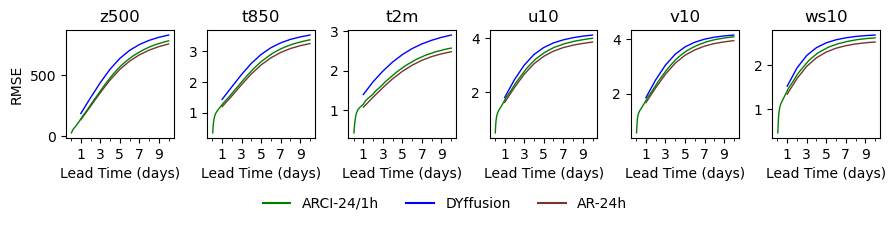

In [241]:
# Skill
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(1, len(var_names), figsize=(1.5 * len(var_names), 1.7))

# Function to plot the skill for each variable
def plot_axs_skill(ax, var_ch, scale=1, ylabel=False, x_max=10.5, combined=False):
    for idx, eval_name in enumerate(eval_names):
        if legend_names[idx] == 'null':
            continue
        skill = metrics_dict[eval_name]['skill']  # Get skill for the current eval_name

        # Load k_series and iterative_steps from Zarr for the current eval_name
        k_series = zarr_root[eval_name]['k_series'][:]
        iterative_steps = zarr_root[eval_name]['iterative_steps']
        
        
        # Calculate days and marker sizes

        if x_max > 1:
            time_measure = 'days'
            days = [t / 24 for t in k_series]
            days = [t for t in days if t <= x_max]
        else: 
            time_measure = 'hours'
            days = [t for t in k_series]
            days = [t for t in days if t <= x_max*24]
        
        ax.plot(days, skill[:len(days), var_ch], label=legend_names[idx], color=colors[idx], linestyle = linestyles[idx],linewidth=1,zorder = 10 - idx, markersize=0)
        
    
    #ax.plot(days, persistence_skill[:, var_ch], label='Persistence', color='k', linewidth=1)
    #ax.plot(days, climatology_skill[:, var_ch], label='Climatology', color='gray', linewidth=1, linestyle = '--')
    #ax.set_ylim(bottom=0, top=1.1*climatology_skill[:,var_ch].mean().item())

    # Set plot titles, labels, and ticks
    ax.set_xlabel(f'Lead Time ({time_measure})')
    if x_max > 1:
            ax.set_xticks(np.arange(1, x_max, 2))
            ax.set_xticks(np.arange(0, x_max, 1), minor=True)
            ax.set_xlim(left=0 - x_max /20, right=x_max)
    else: 
        ax.set_xticks(np.arange(6, x_max*24, 6))
        ax.set_xticks(np.arange(0, x_max*24, 3), minor=True)
        ax.set_xlim(left=0 - x_max /20, right=x_max*24)
        
    
    #ax.grid(True, which='major', axis='x', zorder = 0)
    #ax.grid(True, which='minor', axis='x', linewidth=0.2, zorder = 0)


    #ax.set_yticks(scale * np.arange(0, 11, 2))
    #ax.set_yticks(scale * np.arange(0, 11, 1), minor=True)
    #ax.grid(True, which='major', axis='y', zorder = 0)
    #ax.grid(True, which='minor', axis='y', linewidth=0.2, zorder = 10)
    #ax.set_ylim(bottom=0)#, top=scale * 10)
    #ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
    
    ax.set_box_aspect(scale)  # Ensure square aspect ratio

    # Set max one decimal place for y-ticks

    if combined:
        ax.set_title('RMSE')
    
    else:
        ax.set_title(var_names[var_ch])

        if var_ch == 0 or ylabel:# or scale != 1.0:
            #ax.legend()
            ax.set_ylabel('RMSE')
            pass
        

# Plot each variable's skill for different models
#scales = 2*np.array([45, 0.2, 0.15, 0.25, 0.25, 0.175]) # [100, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
scales = np.ones_like(var_names)
for i, _ in enumerate(var_names):
    plot_axs_skill(axs[i], i, scales[i])

handles, labels = axs[0].get_legend_handles_labels()
handles = [plt.Line2D([], [], color=h.get_color(), linewidth=1.5) for h in handles]
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=len(eval_names), frameon=False)

plt.tight_layout()
#plt.savefig(f'figures/paper/skill-{plot_name}.png', transparent=True, dpi=600, bbox_inches='tight')
plt.savefig(f'figures/paper/pdfs/skill-{plot_name}.pdf', transparent=True, dpi=600, bbox_inches='tight')

plt.show()


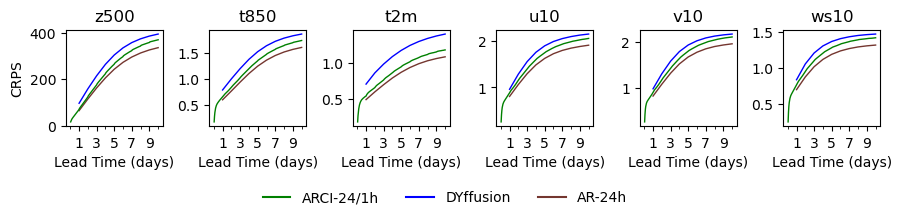

In [242]:
# CRPS
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(1, len(var_names), figsize=(1.5 * len(var_names), 1.7))

# Function to plot the skill for each variable
def plot_axs_crps(ax, var_ch, scale=1, ylabel=False, combined=False):
    for idx, eval_name in enumerate(eval_names):
        if legend_names[idx] == 'null':
            continue
        skill = metrics_dict[eval_name]['CRPS']  # Get skill for the current eval_name

        # Load k_series and iterative_steps from Zarr for the current eval_name
        k_series = zarr_root[eval_name]['k_series'][:]
        iterative_steps = zarr_root[eval_name]['iterative_steps']
        
        
        # Calculate days and marker sizes
        days = [t / 24 for t in k_series]
        markers_sz = [0.5 if k % iterative_steps == 0 else 0.1 for k in k_series]
        
        # Plot skill with unique color for each eval_name
        ax.plot(days, skill[:, var_ch], label=legend_names[idx], color=colors[idx], linewidth=1,zorder = 10-idx, markersize=0)
        #ax.scatter(days, skill[:, var_ch], s=markers_sz, color=colors[idx], zorder = 2)#, linewidth=10)
        

    

    
    #ax.plot(days, persistence_skill[:, var_ch], label='Persistence', color='k', linewidth=1)
    #ax.plot(days, climatology_skill[:, var_ch], label='Climatology', color='gray', linewidth=1, linestyle = '--')
    #ax.set_ylim(bottom=0, top=1.1*climatology_skill[:,var_ch].mean().item())

    # Set plot titles, labels, and ticks
    ax.set_title(var_names[var_ch])
    ax.set_xlabel('Lead Time (days)')
    ax.set_xticks(np.arange(1, 11, 2))
    ax.set_xticks(np.arange(0, 11, 1), minor=True)
    #ax.grid(True, which='major', axis='x', zorder = 10)
    #ax.grid(True, which='minor', axis='x', linewidth=0.2, zorder = 10)
    ax.set_xlim(left=-0.5, right=10.5)

    #ax.set_yticks(scale * np.arange(0, 11, 2))
    #ax.set_yticks(scale * np.arange(0, 11, 1), minor=True)
    #ax.grid(True, which='major', axis='y', zorder = 10)
    #ax.grid(True, which='minor', axis='y', linewidth=0.2, zorder = 10)
    #ax.set_ylim(bottom=0)#, top=scale * 10)
    #ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
    
    ax.set_box_aspect(scale)  # Ensure square aspect ratio

    # Set max one decimal place for y-ticks


    if combined:
        ax.set_title('CRPS')
    
    else:
        ax.set_title(var_names[var_ch])

        if var_ch == 0 or ylabel:# or scale != 1.0:
            #ax.legend()
            ax.set_ylabel('CRPS')
            pass        

# Plot each variable's skill for different models
#scales = 2*np.array([45, 0.2, 0.15, 0.25, 0.25, 0.175]) # [100, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
for i, _ in enumerate(var_names):
    plot_axs_crps(axs[i], i, scales[i])

handles, labels = axs[0].get_legend_handles_labels()
handles = [plt.Line2D([], [], color=h.get_color(), linewidth=1.5) for h in handles]
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=len(eval_names), frameon=False)

plt.tight_layout()
#plt.savefig(f'figures/paper/crps-{plot_name}.png', transparent=True, dpi=600, bbox_inches='tight')
plt.savefig(f'figures/paper/pdfs/crps-{plot_name}.pdf', transparent=True, dpi=600, bbox_inches='tight')

plt.show()


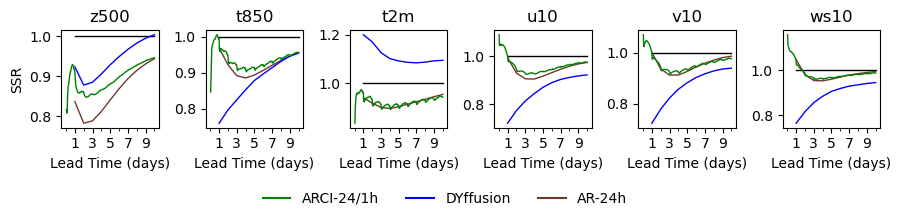

In [243]:
# SSR
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(1, len(var_names), figsize=(1.5 * len(var_names), 1.7))

# Function to plot the skill for each variable
def plot_axs_ssr(ax, var_ch, scale=1, ylabel=False, x_max = 10.5, combined=False):
    for idx, eval_name in enumerate(eval_names):
        if legend_names[idx]== 'null':
            continue
        skill = metrics_dict[eval_name]['ssr']  # Get skill for the current eval_name

        # Load k_series and iterative_steps from Zarr for the current eval_name
        k_series = zarr_root[eval_name]['k_series'][:]
        iterative_steps = zarr_root[eval_name]['iterative_steps']
                
        if x_max > 1:
            time_measure = 'days'
            days = [t / 24 for t in k_series]
            days = [t for t in days if t <= x_max]
        else: 
            time_measure = 'hours'
            days = [t for t in k_series]
            days = [t for t in days if t <= x_max*24]
        
        # Plot skill with unique color for each eval_name
        ax.plot(days, skill[:len(days), var_ch], label=legend_names[idx], color=colors[idx], linewidth=1,zorder = 10-idx, markersize=0)
        #ax.scatter(days, skill[:, var_ch], s=markers_sz, color=colors[idx], zorder = 2)#, linewidth=10)
    
    ax.plot(days, np.ones_like(np.array(days)), linewidth=1, color='k')
        
    
    #ax.plot(days, persistence_skill[:, var_ch], label='Persistence', color='k', linewidth=1)
    #ax.plot(days, climatology_skill[:, var_ch], label='Climatology', color='gray', linewidth=1, linestyle = '--')
    #ax.set_ylim(bottom=0, top=1.1*climatology_skill[:,var_ch].mean().item())

    # Set plot titles, labels, and ticks
    ax.set_title(var_names[var_ch])
    ax.set_xlabel(f'Lead Time ({time_measure})')
    if x_max > 1:
            ax.set_xticks(np.arange(1, x_max, 2))
            ax.set_xticks(np.arange(0, x_max, 1), minor=True)
            ax.set_xlim(left=0 - x_max /20, right=x_max)
    else: 
        ax.set_xticks(np.arange(6, x_max*24, 6))
        ax.set_xticks(np.arange(0, x_max*24, 3), minor=True)
        ax.set_xlim(left=0 - x_max /20, right=x_max*24)
        
    
    if combined:
        ax.set_title('SSR')
    
    else:
        ax.set_title(var_names[var_ch])

        if var_ch == 0 or ylabel:# or scale != 1.0:
            #ax.legend()
            ax.set_ylabel('SSR')
            pass

    #ax.set_yticks(scale * np.arange(0, 11, 2))
    #ax.set_yticks(scale * np.arange(0, 11, 1), minor=True)
    #ax.grid(True, which='major', axis='y', zorder = 10)
    #ax.grid(True, which='minor', axis='y', linewidth=0.2, zorder = 10)
    #ax.set_ylim(bottom=0)#, top=scale * 10)
    #ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
    
    ax.set_box_aspect(scale)  # Ensure square aspect ratio

    # Set max one decimal place for y-ticks

        

# Plot each variable's skill for different models
#scales = 2*np.array([45, 0.2, 0.15, 0.25, 0.25, 0.175]) # [100, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
for i, _ in enumerate(var_names):
    plot_axs_ssr(axs[i], i, scales[i])

handles, labels = axs[0].get_legend_handles_labels()
handles = [plt.Line2D([], [], color=h.get_color(), linewidth=1.5) for h in handles]
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=len(eval_names), frameon=False)

plt.tight_layout()
#plt.savefig(f'figures/paper/ssr-{plot_name}.png', transparent=True, dpi=600, bbox_inches='tight')
plt.savefig(f'figures/paper/pdfs/ssr-{plot_name}.pdf', transparent=True, dpi=600, bbox_inches='tight')

plt.show()


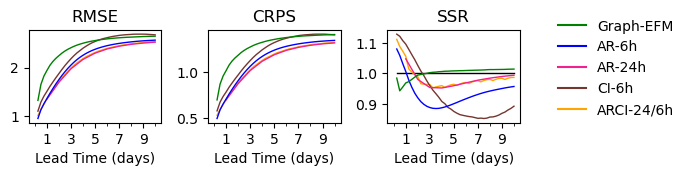

In [48]:
# Combined
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

num_plots = 3
fig, axs = plt.subplots(1, num_plots, figsize=(1.8 * num_plots, 1.6))

var_ch = 5
plot_axs_skill(axs[0], var_ch, 0.7, combined=True)
plot_axs_crps(axs[1], var_ch, 0.7, combined=True)
plot_axs_ssr(axs[2], var_ch, 0.7, combined=True)

handles, labels = axs[0].get_legend_handles_labels()
handles = [plt.Line2D([], [], color=h.get_color(), linewidth=1.5) for h in handles]
#fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(1.15, 0.19), ncol=1, frameon=False)
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(1.15, 0.24), ncol=1, frameon=False)

plt.tight_layout()
#plt.savefig(f'figures/paper/combined-{plot_name}-{var_names[var_ch]}.png', transparent=True, dpi=600, bbox_inches='tight')
#plt.savefig(f'figures/paper/pdfs/combined-{plot_name}-{var_names[var_ch]}.pdf', transparent=True, dpi=600, bbox_inches='tight')

plt.show()

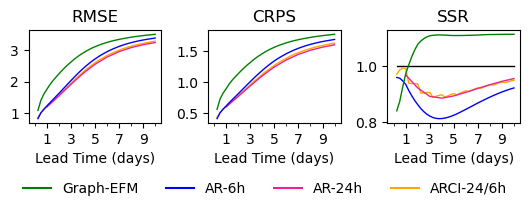

In [59]:
# Combined
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

num_plots = 3
fig, axs = plt.subplots(1, num_plots, figsize=(1.8 * num_plots, 1.6))

var_ch = 1
plot_axs_skill(axs[0], var_ch, 0.7, combined=True)
plot_axs_crps(axs[1], var_ch, 0.7, combined=True)
plot_axs_ssr(axs[2], var_ch, 0.7, combined=True)

handles, labels = axs[0].get_legend_handles_labels()
handles = [plt.Line2D([], [], color=h.get_color(), linewidth=1.5) for h in handles]
#fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(1.15, 0.19), ncol=1, frameon=False)
#fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(1.15, 0.24), ncol=1, frameon=False)
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=len(eval_names), frameon=False)

plt.tight_layout()
plt.savefig(f'figures/paper/poster/combined-{plot_name}-{var_names[var_ch]}.pdf', transparent=True, dpi=600, bbox_inches='tight')

plt.show()

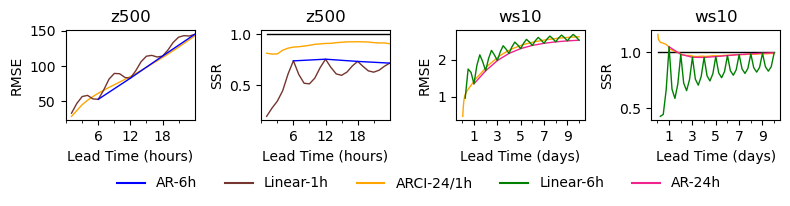

In [241]:
# Combined
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

num_plots = 4
fig, axs = plt.subplots(1, num_plots, figsize=(2 * num_plots, 1.8))

eval_names = ['linear', 'iterative-6h','iterative-24h', 'linear-1h', 'continuous-24+1h-ens10-[0,-24]']
legend_names = ['Linear-6h','AR-6h','AR-24h', 'Linear-1h','ARCI-24/1h']

legend_names = ['null','AR-6h','null', 'Linear-1h','ARCI-24/1h']
plot_axs_skill(axs[0], 0, 0.7, ylabel=True, x_max=1)
plot_axs_ssr(axs[1], 0, 0.7, ylabel=True, x_max=1)

legend_names = ['Linear-6h', 'null','AR-24h', 'null','ARCI-24/1h']
plot_axs_skill(axs[2], 5, 0.7, ylabel=True)
plot_axs_ssr(axs[3], 5, 0.7, ylabel=True)

handles0, labels0 = axs[0].get_legend_handles_labels()
handles1, labels1 = axs[2].get_legend_handles_labels()
handles_labels = dict(zip(labels0 + labels1, handles0 + handles1))
labels, handles = zip(*handles_labels.items())
legend_handles = [plt.Line2D([], [], color=h.get_color(), linewidth=1.5) for h in handles]
fig.legend(legend_handles, labels, loc='lower center', bbox_to_anchor=(0.53, -0.15), ncol=len(eval_names)+1, frameon=False)

plt.tight_layout()
#plt.savefig(f'figures/paper/linear.png', transparent=True, dpi=600, bbox_inches='tight')
plt.savefig(f'figures/paper/{plot_name}.png', transparent=True, dpi=600, bbox_inches='tight')
plt.savefig(f'figures/paper/pdfs/{plot_name}.pdf', transparent=True, dpi=600, bbox_inches='tight')

plt.show()


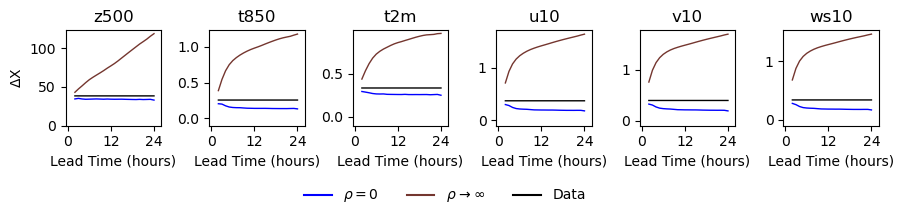

In [150]:
# Temp diff

#legend_names = ['null', '$\rho=0$', '$\rho=\text{ln}10$', '$\rho\to\infty$']

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(1, len(var_names), figsize=(1.5 * len(var_names), 1.7))

# Function to plot the skill for each variable
def plot_axs_temp_diff(ax, var_ch, scale=1, ylabel=False, combined=False):
    for idx, eval_name in enumerate(eval_names):
        if 'null' in legend_names[idx]:
            continue
        skill = metrics_dict[eval_name]['temp-diff']  # Get skill for the current eval_name

        # Load k_series and iterative_steps from Zarr for the current eval_name
        k_series = zarr_root[eval_name]['k_series'][1:]
        iterative_steps = zarr_root[eval_name]['iterative_steps']
        
        
        # Calculate days and marker sizes
        days = [t  for t in k_series][:23]
        markers_sz = [0.5 if k % iterative_steps == 0 else 0.1 for k in k_series]
        
        # Plot skill with unique color for each eval_name
        ax.plot(days, skill[:23, var_ch], label=legend_names[idx], color=colors[idx], linewidth=1,zorder = 100, markersize=0)
        #ax.scatter(days, skill[:, var_ch], s=markers_sz, color=colors[idx], zorder = 2)#, linewidth=10)
    
    if not ylabel:
        ax.plot(days,  metrics_dict[eval_name]['temp-per'][:23, var_ch],color='k', linewidth=1,zorder = 1, markersize=0)
    else:
        ax.plot(days,  metrics_dict[eval_name]['temp-per'][:23, var_ch], label='Data', color='k', linewidth=1,zorder = 1, markersize=0)


    # Set plot titles, labels, and ticks
    ax.set_xlabel('Lead Time (hours)')
    ax.set_xticks(np.arange(0, 25, 12))
    #ax.set_xticks(np.arange(0, 11, 1), minor=True)
    #ax.grid(True, which='major', axis='x', zorder = 10)
    #ax.grid(True, which='minor', axis='x', linewidth=0.2, zorder = 10)
    ax.set_xlim(left=-0.5, right=26)

    #ax.set_yticks(scale * np.arange(0, 11, 2))
    #ax.set_yticks(scale * np.arange(0, 11, 1), minor=True)
    #ax.grid(True, which='major', axis='y', zorder = 10)
    #ax.grid(True, which='minor', axis='y', linewidth=0.2, zorder = 10)
    #ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
    
    ax.set_box_aspect(scale)  # Ensure square aspect ratio

    # Set max one decimal place for y-ticks
    if combined:
        ax.set_title('$\Delta$X')

    else:
        ax.set_title(var_names[var_ch])

        if var_ch == 0:
            #ax.legend()
            ax.set_ylabel('$\Delta$X')
    
    if ylabel:
        pass
        ax.set_ylim(bottom=-0.1)#, top=scale * 10)
        

# Plot each variable's skill for different models
#scales = 2*np.array([45, 0.2, 0.15, 0.25, 0.25, 0.175]) # [100, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
scales = np.ones_like(var_names)
for i, _ in enumerate(var_names):
    plot_axs_temp_diff(axs[i], i, scales[i], ylabel=True)

handles, labels = axs[0].get_legend_handles_labels()
handles = [plt.Line2D([], [], color=h.get_color(), linewidth=1.5) for h in handles]

fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=len(eval_names), frameon=False)

plt.tight_layout()
# For timediff eps plots
#legend_names = ['null', '$\rho=0$', '$\rho=\text{ln}10$', '$\rho\to\infty$']
plot_name = 'noise'
legend_names = ['null', r'$\rho=0$',  'null', r'$\rho\;\to\;\infty$']

#plot_name = 'eps'
#legend_names = ['null', r'$\rho=0$', r'$\rho=$ln10', 'null']

plt.savefig(f'figures/paper/temp-diff-{plot_name}.png', transparent=True, dpi=600, bbox_inches='tight')
plt.savefig(f'figures/paper/pdfs/temp-diff-{plot_name}.pdf', transparent=True, dpi=600, bbox_inches='tight')

plt.show()

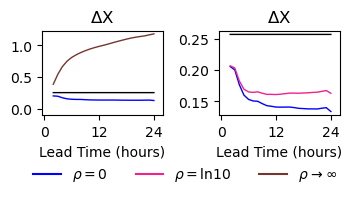

In [162]:
# For timediff noise plots
#eval_names = ['continuous-24+1h-ens10-eps0','continuous-24+1h-ens10-eps0', 'continuous-24+1h-ens10-eps1', 'continuous-24+1h-ens10-eps0.1']
#legend_names = ['null', 'Same noise', 'Different noise', 'null']

# For timediff eps plots
#legend_names = ['null', '$\epsilon=0$', 'null', '$\epsilon=0.1$']


# Combined
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

num_plots = 2

#fig, axs = plt.subplots(1, num_plots, figsize=(2 * num_plots, 1.6))
fig, axs = plt.subplots(1, num_plots, figsize=(1.8 * num_plots, 1.6))

#legend_names = ['null', '$\epsilon=0$', '$\epsilon=0.1$', 'null',]
legend_names = ['null', r'$\rho=0$',r'$\rho=$ln10', 'null']


plot_axs_temp_diff(axs[1], 1, 0.7, combined=True)
#legend_names = ['null', '$\epsilon=0$', 'null', '$\epsilon=1$',]
legend_names = ['null', r'$\rho=0$','null', r'$\rho\;\to\;\infty$']


plot_axs_temp_diff(axs[0], 1, 0.7, True, combined=True)
#legend_names = ['null', '$\epsilon=0$', '$\epsilon=0.1$', '$\epsilon=1$',]
legend_names = ['null', r'$\rho=0$', r'$\rho=$ln10', r'$\rho\to\infty$']


handles0, labels0 = axs[1].get_legend_handles_labels()
handles1, labels1 = axs[0].get_legend_handles_labels()
handles_labels = dict(zip(labels0 + labels1, handles0 + handles1))
labels, handles = zip(*handles_labels.items())

legend_handles = [plt.Line2D([], [], color=h.get_color(), linewidth=1.5) for l, h in handles_labels.items() if l!='Data']
fig.legend(legend_handles, labels, loc='lower center', bbox_to_anchor=(0.53, -0.2), ncol=len(eval_names)+1, frameon=False)
#fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(1.15, 0.23), ncol=1, frameon=False)

plt.tight_layout()
plot_name = 'main'
plt.savefig(f'figures/paper/temp-diff-{plot_name}.png', transparent=True, dpi=600, bbox_inches='tight')
plt.savefig(f'figures/paper/pdfs/temp-diff-{plot_name}.pdf', transparent=True, dpi=600, bbox_inches='tight')


plt.show()


In [155]:
handles_labels

{'$\\rho=0$': <matplotlib.lines.Line2D at 0x14c70efe0f10>,
 '$\\rho=$ln10': <matplotlib.lines.Line2D at 0x14c70eb8d8e0>,
 '$\\rho\\;\\to\\;\\infty$': <matplotlib.lines.Line2D at 0x14c70efd09d0>,
 'Data': <matplotlib.lines.Line2D at 0x14c70efd0d90>}

In [15]:
import numpy as np
eval_name = 'continuous-24+1h-ens10-[0,-24]'
#var_names = ['z500', 't850', 't2m', 'u10', 'v10', 'ws10']

skill = metrics_dict[eval_name]['skill']
CRPS = metrics_dict[eval_name]['CRPS']
ssr = metrics_dict[eval_name]['ssr']
k_series = metrics_dict[eval_name]['k_series']

#times_of_interest = [6, 12, 18, 24, 36]
times_of_interest = [24*5, 24*10]
indcs = [i for i, val in enumerate(k_series) if val in times_of_interest]
print(var_names)
print(eval_name)
print()
for var_ch, var_name in enumerate(var_names):
    print(var_name)
    for key, val in enumerate(indcs):
        print(times_of_interest[key], 'h')
        #print(f'Skill: {np.round(skill[val, var_ch].item(),2)}\t{np.round(CRPS[val, var_ch].item(), 2)}')
        print(f'Skill: {np.round(skill[val, var_ch].item(),2)}')
        print(f'CRPS: {np.round(CRPS[val, var_ch].item(), 2)}')
        print(f'SSR: {np.round((ssr[val,var_ch]).item(), 2)}')
        print()
    print('-------------')

['z500', 't850', 't2m', 'u10', 'v10', 'ws10']
continuous-24+1h-ens10-[0,-24]

z500
120 h
Skill: 564.01
CRPS: 264.37
SSR: 0.88

240 h
Skill: 776.07
CRPS: 368.96
SSR: 0.95

-------------
t850
120 h
Skill: 2.66
CRPS: 1.35
SSR: 0.91

240 h
Skill: 3.37
CRPS: 1.73
SSR: 0.96

-------------
t2m
120 h
Skill: 2.07
CRPS: 0.95
SSR: 0.91

240 h
Skill: 2.57
CRPS: 1.18
SSR: 0.94

-------------
u10
120 h
Skill: 3.44
CRPS: 1.74
SSR: 0.94

240 h
Skill: 3.99
CRPS: 2.05
SSR: 0.97

-------------
v10
120 h
Skill: 3.54
CRPS: 1.8
SSR: 0.93

240 h
Skill: 4.1
CRPS: 2.11
SSR: 0.98

-------------
ws10
120 h
Skill: 2.38
CRPS: 1.28
SSR: 0.97

240 h
Skill: 2.62
CRPS: 1.42
SSR: 0.99

-------------


In [19]:
np.random.permutation(11)  + 1

array([ 5,  1,  9, 10,  4,  6, 11,  2,  3,  7,  8])

In [55]:
CRPS.shape

(40, 6)

In [62]:
eval_name = 'continuous-24+6h'
#var_names = ['z500', 't850', 't2m', 'u10', 'v10', 'ws10']

skills = np.zeros((5, skill.shape[0], skill.shape[1]))
CRPSs = np.zeros((5, skill.shape[0], skill.shape[1]))
ssrs = np.zeros((5, skill.shape[0], skill.shape[1]))

for i in [0,1,2,3,4]:
    skill = metrics_dict[f"{eval_name}-{i+1}"]['skill']
    CRPS = metrics_dict[f"{eval_name}-{i+1}"]['CRPS']
    ssr = metrics_dict[f"{eval_name}-{i+1}"]['ssr']
    k_series = metrics_dict[f"{eval_name}-{i+1}"]['k_series']
    
    skills[i] = skill
    CRPSs[i] = CRPS
    ssrs[i] = ssr

mean_skill = np.mean(skills, axis=0)
std_skill = np.std(skills, axis=0)

mean_CRPS = np.mean(CRPSs, axis=0)
std_CRPS = np.std(CRPSs, axis=0)

mean_ssr = np.mean(ssrs, axis=0)
std_ssr = np.std(ssrs, axis=0)

#times_of_interest = [6, 12, 18, 24, 36]
times_of_interest = [24*10]
indcs = [i for i, val in enumerate(k_series) if val in times_of_interest]
print(var_names)
print(eval_name)
print()
for var_ch, var_name in enumerate(var_names):
    print(var_name)
    for key, val in enumerate(indcs):
        #print(times_of_interest[key], 'h')
        #print(f'{np.round(skill[val, var_ch].item(),2)}\t{np.round(CRPS[val, var_ch].item(), 2)}')
        #print(f'{times_of_interest[key]}h {np.round(mean_skill[val, var_ch].item(),2)}, {np.round(std_skill[val, var_ch].item(),2)}', {np.round(std_skill[val, var_ch].item()/mean_skill[val, var_ch].item(),4)})
        #print(f'CRPS: {np.round(mean_CRPS[val, var_ch].item(), 2)}, {np.round(std_CRPS[val, var_ch].item(), 2)}', {np.round(std_CRPS[val, var_ch].item()/mean_CRPS[val, var_ch].item(),4)})
        #print(f'SSR: {np.round(mean_ssr[val,var_ch].item(), 2)}, {np.round(std_ssr[val,var_ch].item(), 2)}', {np.round(std_ssr[val,var_ch].item()/mean_ssr[val,var_ch].item(),4)})

        print(f'{times_of_interest[key]}h {np.round(std_skill[val, var_ch].item()/mean_skill[val, var_ch].item(),4)}')
        print(f'CRPS: {np.round(std_CRPS[val, var_ch].item()/mean_CRPS[val, var_ch].item(),4)}')
        print(f'SSR: {np.round(std_ssr[val,var_ch].item()/mean_ssr[val,var_ch].item(),4)}')
        #print()
    print('-------------')

['z500', 't850', 't2m', 'u10', 'v10', 'ws10']
continuous-24+6h

z500
240h 0.0279
CRPS: 0.093
SSR: 0.0194
-------------
t850
240h 0.0152
CRPS: 0.0249
SSR: 0.0074
-------------
t2m
240h 0.027
CRPS: 0.0682
SSR: 0.018
-------------
u10
240h 0.0077
CRPS: 0.0094
SSR: 0.0103
-------------
v10
240h 0.0046
CRPS: 0.0056
SSR: 0.0106
-------------
ws10
240h 0.0045
CRPS: 0.0057
SSR: 0.0085
-------------


In [172]:
forecast.shape[1]

50

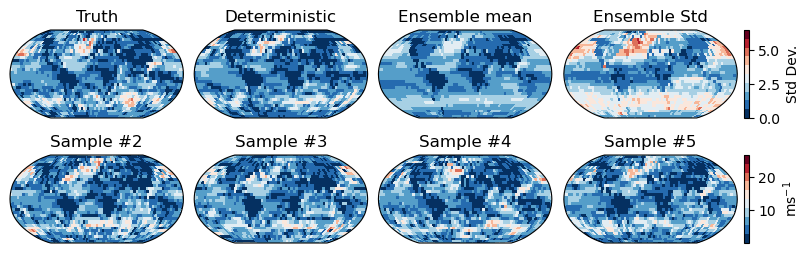

In [28]:
var_ch = 5
bat_ch = 0

units = [r'm$^2$s$^{−2}$', '°C', '°C', r'ms$^{-1}$',r'ms$^{-1}$', r'ms$^{-1}$']

time_labels=k_series

dt = len(time_labels)
dx = forecast.shape[4]
dy = forecast.shape[5]

truth_plot = (truth[bat_ch,:,var_ch]).cpu().detach().numpy().reshape((-1, dx, dy))                              #-272.15
forecast_plot = (forecast[bat_ch,:,:,var_ch]).cpu().detach().numpy().reshape((forecast.shape[1], dt, dx,dy))    #-272.15
det_forecast_plot = (deterministic_forecast[bat_ch,:,:,var_ch]).cpu().detach().numpy().reshape((1, dt, dx,dy))  #-272.15


ens_mean = forecast_plot.mean(axis=0)
ens_std = forecast_plot.std(axis=0)

cmap_z = plt.cm.get_cmap('viridis')#, 20)     #t850
cmap_t = plt.cm.get_cmap('hot')     #, 35)     #t850
cmap_u = plt.cm.get_cmap('RdBu_r', 10)
cmaps = [cmap_u, cmap_u, cmap_u, cmap_u, cmap_u, cmap_u]
cmap = cmaps[var_ch]

%matplotlib inline
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

fig, axes = plt.subplots(2,4, figsize=(8,2.5), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    #ax.axis('off')
    #ax.coastlines(resolution='110m', linewidth=0.5, color='k')
    #gridlines = ax.gridlines()
    #gridlines.linewidth = 0.5
    pass

title1 = axes[0,0].set_title('')
title2 = axes[0,1].set_title('')
title3 = axes[0,2].set_title('')
title4 = axes[0,3].set_title('')
#titles = []
#for j in range(1, 4):
#    axes[0,j+1].set_title(f"Sample #{j}")

images = []
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        pass
        cf = ax.pcolormesh(lon, lat, truth_plot[0], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max(), transform=ccrs.PlateCarree())
        #cf = ax.imshow(truth_plot[0], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max())
        images.append(cf)
        
    elif i == 1:
        cf = ax.pcolormesh(lon, lat, det_forecast_plot[0, 0], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max(), transform=ccrs.PlateCarree())
        #cf = ax.imshow(ens_mean[0], cmap=cmap)
        images.append(cf)

    elif i == 2:
        cf = ax.pcolormesh(lon, lat, ens_mean[0], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max(), transform=ccrs.PlateCarree())
        #cf = ax.imshow(ens_mean[0], cmap=cmap)
        images.append(cf)
    
    elif i == 3:
        cf = ax.pcolormesh(lon, lat, ens_std[0], cmap=cmap, vmin=0, vmax=ens_std.max(), transform=ccrs.PlateCarree())
        #cf = ax.imshow(ens_std[0], cmap=cmap, vmin=0, vmax=ens_std.max())
        images.append(cf)
        cbar_mean = fig.colorbar(cf, ax=ax, orientation='vertical', fraction=0.025, pad=0.04)
        cbar_mean.set_label('Std Dev.')

    else:
        pass
        cf = ax.pcolormesh(lon, lat, forecast_plot[i-3,0], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max(), transform=ccrs.PlateCarree())
        #cf = ax.imshow(forecast_plot[i-3,0], cmap=cmap, vmin=forecast_plot.min(), vmax=forecast_plot.max())
        images.append(cf)
        ax.set_title(f'Sample #{i-2}')
        if i == len(axes.flatten()) - 1:
            cbar_mean = fig.colorbar(cf, ax=ax, orientation='vertical',fraction=0.025, pad=0.04)
            cbar_mean.set_label(units[var_ch])


# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        if i == 0:
            im.set_array(truth_plot[n].flatten())
        elif i == 1:
            im.set_array(det_forecast_plot[0,n].flatten())
        elif i == 2:
            im.set_array(ens_mean[n].flatten())
        elif i == 3:
            im.set_array(ens_std[n].flatten())
        else:
            pass
            im.set_array(forecast_plot[i-3,n].flatten())

    #txt_title.set_text(f't={time_labels[n].item()}h')
    title1.set_text('Truth')
    title2.set_text('Deterministic')
    title3.set_text('Ensemble mean')
    title4.set_text('Ensemble Std')
# 
    return images

drawframe(39)
plt.savefig(f'figures/paper/forecast-{var_names[var_ch]}-pixel.png', transparent=True, dpi=600, bbox_inches='tight')

#plt.savefig(f'figures/paper/forecast-{var_names[var_ch]}.png', transparent=True, dpi=600, bbox_inches='tight')
#plt.savefig(f'figures/paper/pdfs/forecast-{var_names[var_ch]}.pdf', transparent=True, dpi=600, bbox_inches='tight')


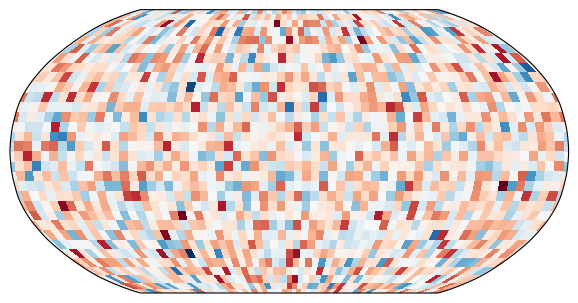

In [65]:
var_ch = 2
bat_ch = 0

time_labels=k_series

dt = len(time_labels)
dx = forecast.shape[4]
dy = forecast.shape[5]

truth_plot = (truth[bat_ch,:,var_ch]).cpu().detach().numpy().reshape((-1, dx, dy))# - climatology[var_ch]
forecast_plot = (forecast[bat_ch,:,:,var_ch]).cpu().detach().numpy().reshape((forecast.shape[1], dt, dx,dy))# - climatology[var_ch]
noise_plot = torch.randn_like(truth[bat_ch,:,var_ch]).cpu().detach().numpy().reshape((-1, dx, dy))

ens_mean = forecast_plot.mean(axis=0)
ens_std = forecast_plot.std(axis=0)

cmap_z = plt.cm.get_cmap('viridis')#, 20)     #t850
cmap_t = plt.cm.get_cmap('hot')     #, 35)     #t850
cmap_u = plt.cm.get_cmap('RdBu_r')#, 30)
cmaps = [cmap_u, cmap_u, cmap_u, cmap_u, cmap_u, cmap_u]
cmap = cmaps[var_ch]

%matplotlib inline
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

fig, axes = plt.subplots(1,1, figsize=(7,3), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})

txt_title = fig.suptitle('', va='top')

tm = 24
#for tm in range(24):
    #cf = axes.pcolormesh(lon, lat, truth_plot[tm], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max(), transform=ccrs.PlateCarree())
cf = axes.pcolormesh(lon, lat, noise_plot[tm], cmap=cmap, transform=ccrs.PlateCarree())
        
#cf = axes.pcolormesh(lon, lat, forecast_plot[0,tm], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max(), transform=ccrs.PlateCarree())

#plt.savefig(f'figures/paper/state-{var_names[var_ch]}-t{tm}-f.png', transparent=True, dpi=600, bbox_inches='tight')
plt.savefig(f'figures/paper/state-{var_names[var_ch]}-noise.png', transparent=True, dpi=600, bbox_inches='tight')


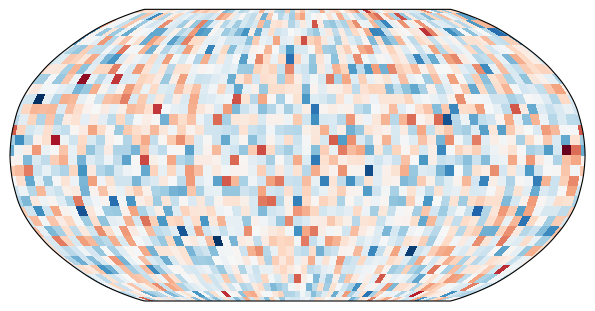

In [40]:
"""
Plot the denoising of random states
"""
frac = 0.9

rnd_uniform = 1 - frac
rho_inv = 1 / 7
sigma_max_rho = 88 ** rho_inv
sigma_min_rho = 0.02 ** rho_inv

sigma = (sigma_max_rho + rnd_uniform * (sigma_min_rho - sigma_max_rho)) ** 7

weight = (sigma ** 2 + 1 ** 2) / (sigma * 1) ** 2

noise = torch.randn_like(image)
noisy_image = image + sigma * noise

#noisy_images.append(noisy_image.cpu().detach().numpy())

fig, axes = plt.subplots(1,1, figsize=(7,3), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})

cf = axes.pcolormesh(lon, lat, noisy_image, cmap=cmap_u, transform=ccrs.PlateCarree())
        
#cf = axes.pcolormesh(lon, lat, forecast_plot[0,tm], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max(), transform=ccrs.PlateCarree())

#plt.savefig(f'figures/paper/state-{var_names[var_ch]}-t{tm}-f.png', transparent=True, dpi=600, bbox_inches='tight')
plt.savefig(f'figures/paper/poster/noise-t2m-{frac}.png', transparent=True, dpi=600, bbox_inches='tight')

In [23]:
import gc
gc.collect()

1008

In [228]:
import torch

# Example forecast tensor: [no_samples, no_ens, no_times, vars, 32, 64]

# Time indices in 24-hour intervals: [24h, 48h, ..., 240h]

times = torch.arange(0, 241, 2)

# Define the new time points we want to interpolate at 6-hour intervals
new_times = torch.arange(1, 241, 1)

# Function to interpolate between two time steps
def linear_interpolate(forecast, times, new_times):
    # New tensor for interpolated forecasts
    forecast_with_truth = torch.cat((truth[:,0].unsqueeze(1).expand(-1, forecast.shape[1],-1,-1,-1).unsqueeze(2), forecast), dim=2)  # Add the first time step
    interpolated = torch.zeros(forecast_with_truth.size(0), forecast_with_truth.size(1), len(new_times), forecast_with_truth.size(3), forecast_with_truth.size(4), forecast_with_truth.size(5))
    
    forecast_with_truth = forecast_with_truth[:,:,::2] #NOT ALWAYS LIKE THIS

    for i, t in enumerate(new_times):
        if t in times:
            # If the time point is an original time, copy the forecast directly
            idx = (times == t).nonzero(as_tuple=True)[0].item()
            interpolated[:, :, i, :, :, :] = forecast_with_truth[:, :, idx, :, :, :]
        else:
            # Find the two surrounding times
            prev_time_idx = (times < t).nonzero(as_tuple=True)[0][-1].item()
            next_time_idx = (times > t).nonzero(as_tuple=True)[0][0].item()
            
            # Compute the weights for linear interpolation
            prev_time = times[prev_time_idx]
            next_time = times[next_time_idx]
            weight = (t - prev_time) / (next_time - prev_time)

            # Perform the weighted average between adjacent forecasts
            interpolated[:, :, i, :, :, :] = (
                (1 - weight) * forecast_with_truth[:, :, prev_time_idx, :, :, :]
                + weight * forecast_with_truth[:, :, next_time_idx, :, :, :]
            )
    
    return interpolated

# Perform the interpolation
interpolated_forecast = linear_interpolate(forecast, times, new_times)

print(interpolated_forecast.shape)  # Should have [753, 10, len(new_times), 2, 32, 64]


torch.Size([6, 10, 240, 6, 32, 64])


In [226]:
(interpolated_forecast.to(device) - forecast)[:,:,3]

tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..

torch.Size([48, 10, 6, 32, 64])

In [21]:
days = [t/24 for t in k_series[1:]]

bat_ch = 0

# Compute the correlation between subsequent timesteps for forecast
def scorrelation(x, y):
    x_mean = x.mean(dim=(4, 5), keepdim=True)
    y_mean = y.mean(dim=(4, 5), keepdim=True)
    
    x_centered = x - x_mean
    y_centered = y - y_mean
    
    numerator = (x_centered * y_centered).sum(dim=(4, 5))
    denominator = ((x_centered**2).sum(dim=(4, 5)) * (y_centered**2).sum(dim=(4, 5))).sqrt()
    
    return numerator / denominator

def scorrelation(x, y):
    x_mean = x.mean(dim=(4, 5), keepdim=True)
    y_mean = y.mean(dim=(4, 5), keepdim=True)
    
    x_centered = x - x_mean
    y_centered = y - y_mean
    
    numerator = (x_centered * y_centered).sum(dim=(4, 5))
    denominator = ((x_centered**2).sum(dim=(4, 5)) * (y_centered**2).sum(dim=(4, 5))).sqrt()
    
    return numerator / denominator

dx_dir = correlation(forecast[:, :, 1:, :], forecast[:, :, :-1, :]).mean(dim=(0)).cpu().permute(1, 0, 2)

# Compute the correlation between subsequent timesteps for truth
dx_per = correlation(truth[:, 1:, :].unsqueeze(1), truth[:, :-1, :].unsqueeze(1)).mean(dim=(0)).cpu()

# Plotting
plt.figure(figsize=(5,3))
fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

axes[0].plot(days, dx_dir[:, :, 0], color='#EE82EE', linewidth=0.5)
axes[1].plot(days, dx_dir[:, :, 1], color='#EE82EE', linewidth=0.5)

axes[0].plot(days, dx_per[0,:, 0], label="Persistence", color='k')
axes[1].plot(days, dx_per[0,:, 1], label="Persistence", color='k')

axes[0].set_title('z500')
axes[1].set_title('t850')

for ax in axes:
    ax.set_xlabel('Lead Time (days)')
    ax.set_ylabel('Correlation($X_{t+1}$, $X_t$)')
    ax.legend()

plt.suptitle('Temporal Correlation')

#plt.savefig(f'figures/240912/temp-cor{eval_name}.png', dpi=100, format='png', bbox_inches='tight')


NameError: name 'correlation' is not defined

In [ ]:
chosen_keys = {
    'direct-6_iter-6_max-240_ens10_sp23_single': 'iterative-6h',
    'direct-6_iter-240_max-240_ens10_sp23': 'direct-240h',
    'direct-6_iter-24_max-240_ens10_sp23_trained24': 'direct-6h-iterative-24h',
    'direct-24_iter-24_max-240_ens10_sp23_single': 'iterative-24h'
}

fig, axs = plt.subplots(1, len(var_names), figsize=(5*len(var_names), 5))

days = [t/24 for t in k_series]
#markers_sz = [10 if k%iterative_steps ==0 else 3 for k in k_series]
#days = k_series

def plot_axs(ax, var_ch, scale=1):
    for key, value in CRPS_dict.items():
        if key in chosen_keys.keys():
            key = chosen_keys[key]
            kd = t_max // len(value)
            days = [t/24 for t in np.arange(kd, t_max+kd, kd)]
            ax.plot(days, value[:, var_ch], label=key)
            ax.scatter(days, value[:, var_ch], s=10)

    ax.set_title(var_names[var_ch])
    ax.set_xlabel('Lead Time (days)')

    """
    # TICKS
    ax.set_xticks(np.arange(1,11,2))
    ax.set_xticks(np.arange(0, 11, 1), minor=True)
    ax.grid(True, which='major', axis='x')
    ax.grid(True, which='minor', axis='x', linewidth=0.2)
    ax.set_xlim(left=0, right = 10+1/4)

    ax.set_yticks(scale * np.arange(0,11,2))
    ax.set_yticks(scale * np.arange(0, 11, 1), minor=True)
    ax.grid(True, which='major', axis='y')
    ax.grid(True, which='minor', axis='y', linewidth=0.2)
    #ax.set_ylim(bottom=0, top=1.1*climatology_skill[:,var_ch].mean().item())
    """
    ax.grid('on')

    #ax.set_ylim(bottom=0, top = scale *5)
    if var_ch == 0:
        ax.legend()

scales = [50, 0.25]
for i, _ in enumerate(var_names):
    plot_axs(axs[i], i, scales[i])

plt.tight_layout()
#plt.savefig(f'figures/240912/CRPS.png', transparent=True, dpi=300, bbox_inches='tight')
plt.show()

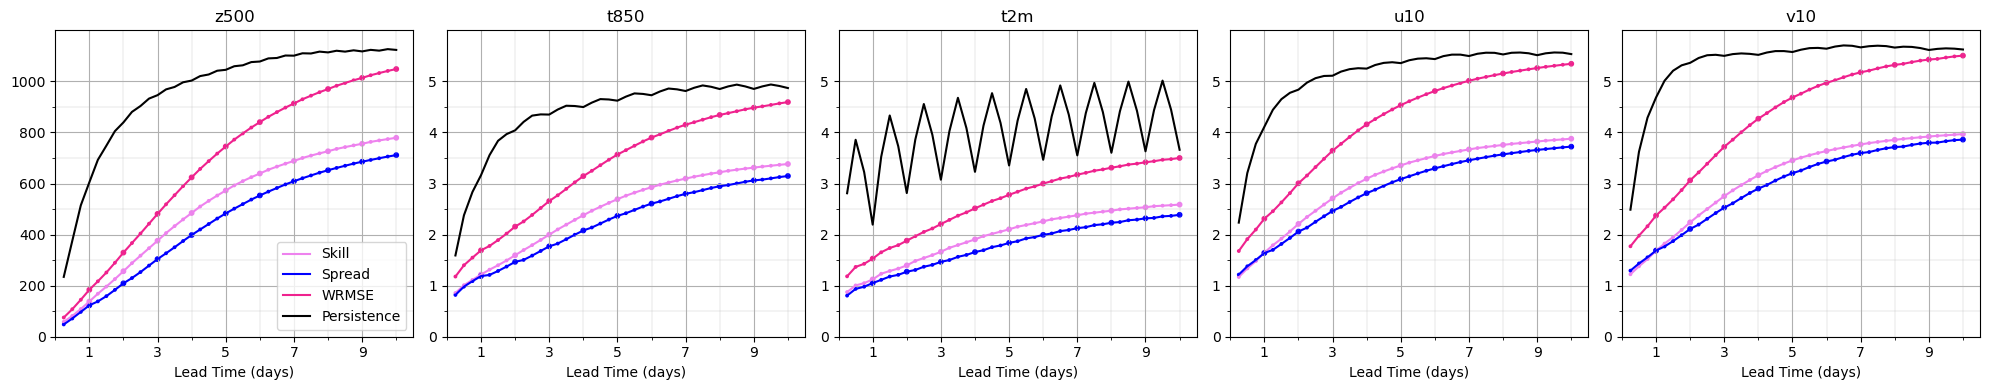

In [43]:
fig, axs = plt.subplots(1, len(var_names), figsize=(4*len(var_names), 4))

days = [t/24 for t in k_series]
markers_sz = [10 if k%iterative_steps ==0 else 3 for k in k_series]
#days = k_series

def plot_axs(ax, var_ch, scale=1):
    ax.plot(days, skill[:, var_ch], label='Skill',color='#EE82EE')
    ax.scatter(days, skill[:, var_ch], s = markers_sz,color='#EE82EE', linewidth=1)

    ax.plot(days, spread[:, var_ch], label='Spread', color='#0000FF')
    ax.scatter(days, spread[:, var_ch],s = markers_sz,color='#0000FF', linewidth=1)
    
    ax.plot(days, wrmse[:, :, var_ch].mean(axis=0), label='WRMSE',color='#EF228E')
    ax.scatter(days, wrmse[:, :, var_ch].mean(axis=0),s = markers_sz,color='#EF228E', linewidth=1)
    
    ax.plot(days, persistence_skill[:, var_ch], label='Persistence', color='k')
    #ax.plot(days, climatology_skill[:, var_ch], label='Climatology', color='gray', linestyle='--')



    ax.set_title(var_names[var_ch])
    ax.set_xlabel('Lead Time (days)')

    # TICKS
    ax.set_xticks(np.arange(1,11,2))
    ax.set_xticks(np.arange(0, 11, 1), minor=True)
    ax.grid(True, which='major', axis='x')
    ax.grid(True, which='minor', axis='x', linewidth=0.2)
    ax.set_xlim(left=0, right = 10.5)

    ax.set_yticks(scale * np.arange(0,11,2))
    ax.set_yticks(scale * np.arange(0, 11, 1), minor=True)
    ax.grid(True, which='major', axis='y')
    ax.grid(True, which='minor', axis='y', linewidth=0.2)
    #ax.set_ylim(bottom=0, top=1.1*climatology_skill[:,var_ch].mean().item())

    ax.set_ylim(bottom=0, top = scale *12)
    if var_ch == 0:
        ax.legend()

scales = [100, 0.5, 0.5, 0.5,0.5,0.5]
for i, _ in enumerate(var_names):
    plot_axs(axs[i], i, scales[i])

plt.tight_layout()
plt.savefig(f'figures/240923/skill_spread_{eval_name}.png', transparent=True, dpi=600, bbox_inches='tight')

plt.show()

In [15]:
import gc
gc.collect()
torch.cuda.empty_cache()


In [16]:
import torch

# Get total and free memory for the current GPU
gpu_id = torch.cuda.current_device()  # Get current device (assuming single GPU)
props = torch.cuda.get_device_properties(gpu_id)

total_memory = props.total_memory / 1024**2  # Convert bytes to MB
allocated_memory = torch.cuda.memory_allocated(gpu_id) / 1024**2  # Convert bytes to MB
cached_memory = torch.cuda.memory_reserved(gpu_id) / 1024**2  # Convert bytes to MB

# Free memory is total memory minus the memory being used (allocated + cached)
free_memory = total_memory - (allocated_memory + cached_memory)

print(f"Total GPU memory: {total_memory:.2f} MB")
print(f"Allocated memory: {allocated_memory:.2f} MB")
print(f"Cached memory: {cached_memory:.2f} MB")
print(f"Free GPU memory: {free_memory:.2f} MB")


Total GPU memory: 40339.31 MB
Allocated memory: 7410.05 MB
Cached memory: 7412.00 MB
Free GPU memory: 25517.26 MB


## **Plotting**

In [185]:
# Plot functions
def plot_global(image):
    fig, ax = plt.subplots(1, 1, figsize=(5,5), subplot_kw={'projection': ccrs.Robinson()})
    ax.pcolormesh(lon, lat, image, transform=ccrs.PlateCarree(), cmap=cmap_u)
    #ax.coastlines(resolution='110m')
    #ax.gridlines()

def plot_grid(image):
    ax = plt.subplots(1,1)
    ax.imshow(image, cmap=cmap_u)
    ax.axis('off')

plt_fn = plot_global

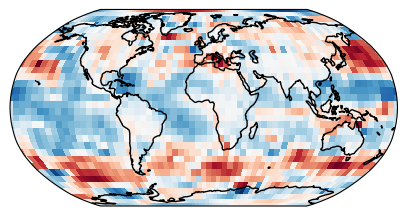

In [471]:
previous, current, time_labels = next(iter(train_loader))
cmap_u = plt.cm.get_cmap('RdBu_r')#, 30)
plt_fn(previous[10,3])

### Skill and spread as functions of lead time

In [11]:
# Noise inflation test
def interpolate_latents(alpha, lat1, lat2):
    return (1 - alpha**2).sqrt() * lat1 + alpha * lat2

def generate_ensemble_from_time_series(model, n_ens=10, selected_loader = val_time_series_loader, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    previous, current, time_labels = next(iter(selected_loader))

    with torch.no_grad():
        previous = previous.to(device)
        current = current.view(-1, vars, current.shape[2], current.shape[3]).to(device)

        previous_state = previous[:,:vars]#.repeat(current.shape[0] * n_ens, 1, 1, 1)

        class_labels = previous.repeat(current.shape[0] * n_ens, 1, 1, 1)
        time_labels = time_labels.flatten().to(device).repeat(n_ens)

        latent_shape = (n_ens, 1, current.shape[2], current.shape[3])
        latents = torch.randn(latent_shape, device=device)
        #latents = latents.repeat(1, vars, 1, 1)
        
        #latents = latents.repeat_interleave(current.shape[0], dim=0)

        
        latents_zeros = torch.zeros((current.shape[0], n_ens, 1, current.shape[2], current.shape[3]), device=device)
        
        latents_zeros[0] = latents

        alph = 0.45
        alph_min = 0.2
        alph_max = 1
        tt=np.linspace(((alph_min**(1/alph)) * alph_max**(-1/alph)), 1, current.shape[0]-1)
        eps = torch.tensor(alph_min*tt**(-alph))

        for i in range(1, current.shape[0]):
            # Adding a little bit of noise
            latents_eps = torch.randn_like(latents, device=device)
            latents = interpolate_latents(eps[i-1], latents, latents_eps)
            latents_zeros[i] = latents.clone()
        
        #latents = latents_zeros.view((current.shape[0]* n_ens, 1, current.shape[2], current.shape[3]))
        latents = torch.tensor(latents_zeros.cpu().numpy().reshape((current.shape[0]* n_ens, 1, current.shape[2], current.shape[3]), order='F'), device=device)
        latents = latents.repeat(1, vars, 1, 1)
        
        predicted_residuals = sampler_fn(model, latents, class_labels, time_labels /lead_time_max, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        predicted_latent = predicted_residuals# * residual_scaling(time_labels) + previous_state
        predicted = predicted_latent
        
        predicted_unnormalized = renormalize(predicted)
        current_unnormalized = renormalize(current)
        previous_unnormalized = renormalize(previous_state)

        predicted_unnormalized = predicted_unnormalized.view(n_ens, current.size(0), current.size(1), current.size(2), current.size(3))
        
    return predicted_unnormalized, current_unnormalized, previous_unnormalized, latents

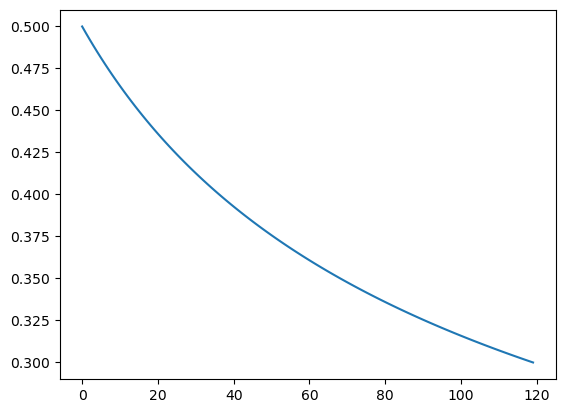

In [363]:
alph = 0.45
alph_min = 0.3
alph_max = 0.5
tt=np.linspace(((alph_min**(1/alph)) * alph_max**(-1/alph)), 1,120)
eps = alph_min*tt**(-alph)
plt.plot(eps)

In [342]:
def generate_batch_ensemble_from_time_series(model, n_ens=10, selected_loader = val_time_series_loader, sampler_fn=heun_sampler, iterative_steps = 24):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    previous, current, time_labels = next(iter(selected_loader))

    n_samples = current.shape[0]
    n_times = time_labels.shape[1]
    dx = current.shape[2]
    dy = current.shape[3]

    n_conditions = previous.shape[1]

    with torch.no_grad():
        previous = previous.to(device)
        current = current.view(-1, vars, dx, dy).to(device)
        
        direct_time_labels = torch.tensor(np.array([x for x in time_labels[0] if x <= iterative_steps]), device=device)
        n_iter = time_labels.shape[1] // direct_time_labels.shape[0]
        
        n_direct = direct_time_labels.shape[0]

        previous_state = previous[:,:vars]
        class_labels = previous.repeat_interleave(n_direct * n_ens, dim=0) # Can not be changed if batchsz > 1

        static_fields = class_labels[:, -static_vars:]

        #latent_shape = (n_samples * n_ens, vars, dx, dy)
        
        # New
        latent_shape = (n_samples * n_ens, vars, dx, dy)
        latents = torch.randn(latent_shape, device=device)

        direct_time_labels = direct_time_labels.repeat(n_ens * n_samples) # Can not be changed if n_direct > 1

        # Test
        predicted_combined = torch.zeros((n_samples, n_ens, n_times, vars, dx, dy), device=device)
        
    
        for i in range(n_iter):
            #latents = torch.randn(latent_shape, device=device)
            latents_zeros = torch.zeros((n_direct, n_samples*n_ens, vars, dx, dy), device=device)

            latents_zeros[0] = latents
            eps = 0
            alph = 0.45

            #alph_min = 0.1
            #alph_max = 0.2
            #tt=np.linspace(((alph_min**(1/alph)) * alph_max**(-1/alph)), 1, current.shape[0]-1)
            #eps = torch.tensor(alph_min*tt**(-alph))

            eps = torch.tensor(eps, device=device)


            for j in range(1, n_direct):
                latents_eps = torch.randn_like(latents, device=device)
                latents = interpolate_latents(eps, latents, latents_eps)
                latents_zeros[j] = latents.clone()
            #eps=eps[-1]
            latents = torch.tensor(latents_zeros.cpu().numpy().reshape((n_direct*n_samples* n_ens, vars, dx, dy), order='F'), device=device)

            #latents = torch.randn(latent_shape, device=device)
            #latents = latents.repeat_interleave(n_direct, dim=0) # Can not be changed if batchsz > 1 or n_ens >1
            
            predicted = sampler_fn(model, latents, class_labels, direct_time_labels / lead_time_max, 
                                    sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
            predicted_combined[:, :, i*n_direct:(i+1)*n_direct] = predicted.view(n_samples, n_ens, n_direct, vars, dx, dy)

            predicted = predicted.view(n_samples*n_ens, n_direct, vars, dx, dy)
            class_labels = class_labels.view(n_samples*n_ens, n_direct, n_conditions, dx, dy)[:, 0]

            #if n_direct == 1:
            class_labels = torch.cat((predicted[:,-1], class_labels[:,:vars]), dim=1).repeat_interleave(n_direct, dim=0)
            #else:
            #    class_labels = torch.cat((predicted[:,-1], predicted[:,-2]), dim=1).repeat_interleave(n_direct, dim=0) # Can not be changed if batchsz > 1
            
            if static_vars != 0:
                class_labels = torch.cat((class_labels, static_fields), dim=1)
            
            latents_eps = torch.randn(latent_shape, device=device)
            latents = interpolate_latents(eps, latents_zeros[-1], latents_eps)

        predicted = predicted_combined
        predicted_unnormalized = renormalize(predicted)
        current_unnormalized = renormalize(current)
        previous_unnormalized = renormalize(previous_state)

        predicted_unnormalized = predicted_unnormalized.view(n_samples, n_ens, n_times, vars, dx, dy)
        current_unnormalized = current_unnormalized.view(n_samples, n_times, vars, dx, dy)
        previous_unnormalized = previous_unnormalized.view(n_samples, vars, dx, dy)
        
    return predicted_unnormalized, current_unnormalized, previous_unnormalized, latents

In [147]:
t_kmin = 6
t_kmax = 24*10

t_d = 6
k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

iterative_steps = 6

#forecast_fn= generate_ensemble_from_time_series
#forecast_fn= generate_ar_ensemble_from_time_series
#forecast_fn= generate_det_forecast_from_time_series
#forecast_fn= generate_cont_forecast_from_time_series

forecast_fn = generate_batch_ensemble_from_time_series
sampler_fn = heun_sampler
#sampler_fn = edm_sampler

forecast, truth, initial = forecast_fn(model, n_ens=10, selected_loader = val_time_series_loader, sampler_fn=sampler_fn, iterative_steps=iterative_steps)
#forecast = forecast.unsqueeze(0)
#truth = truth.unsqueeze(0)
#wrmse = calculate_WRMSE(forecast, truth)
#skill = calculate_WSkill(forecast, truth)
#spread = calculate_WSpread(forecast, truth)
#persistence_skill = calculate_WSkill(initial.unsqueeze(1).unsqueeze(2).expand(-1, 1, truth.shape[1], -1, -1, -1), truth)
#climatology_skill = calculate_WSkill(climatology, truth)

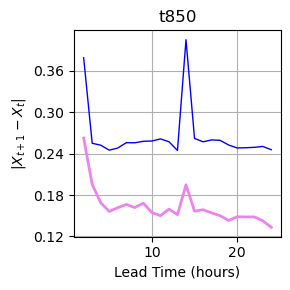

In [344]:
from matplotlib.ticker import MaxNLocator

dx_dir = ((forecast[:, :, 1:, :] - forecast[:, :, :-1, :]).abs()).mean(dim=(-1,-2)).mean(dim=(0)).cpu().permute(1,2,0)
dx_per = ((truth[:, 1:, :] - truth[:, :-1, :])).abs().mean(dim=(-1,-2)).mean(dim=(0)).cpu()
#fig, axs = plt.subplots(1, len(var_names), figsize=(4*len(var_names), 4))
fig, axs = plt.subplots(1, 1, figsize=(4, 3))

days = [t for t in k_series[1:]]
markers_sz = [10 if k%iterative_steps ==0 else 3 for k in k_series]
#days = k_series

def plot_axs(ax, var_ch, scale=1):
    ax.plot(days, dx_dir[:, var_ch].mean(dim=1), label='Continuous-24+6h',color='#EE82EE', linewidth=2)
    #ax.scatter(days, dx_dir[:, var_ch], s = markers_sz,color='#EE82EE', linewidth=1)

    ax.plot(days, dx_per[:, var_ch], label='Persistence', color='#0000FF', linewidth=1)
    #ax.scatter(days, dx_per[:, var_ch],s = markers_sz,color='#0000FF', linewidth=1)
    

    ax.set_title(var_names[var_ch])
    ax.set_xlabel('Lead Time (hours)')

    # TICKS
    #ax.set_xticks(np.arange(1,11,2))
    #ax.set_xticks(np.arange(0, 11, 1), minor=True)
    ax.grid(True, which='major', axis='x')
    ax.grid(True, which='minor', axis='x', linewidth=0.2)
    #ax.set_xlim(left=0, right = 10.5)

    #ax.set_yticks(scale * np.arange(0,11,2))
    #ax.set_yticks(scale * np.arange(0, 11, 1), minor=True)
    ax.grid(True, which='major', axis='y')
    ax.grid(True, which='minor', axis='y', linewidth=0.2)
    #ax.set_ylim(bottom=0, top=1.1*climatology_skill[:,var_ch].mean().item())
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

    ax.set_box_aspect(1)  # Ensure square aspect ratio
    #ax.set_ylim(bottom=0, top = scale *12)
    if var_ch == 0:
        #ax.legend()
        pass
    ax.set_ylabel('$|X_{t+1} - X_t|$')

scales = [100, 0.5, 0.5, 0.5,0.5,0.5]
for i, _ in enumerate(var_names):
#    plot_axs(axs[i], i, scales[i])
    pass

plot_axs(axs, 1, scales[1])
#handles, labels = axs.get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)

plt.tight_layout()
plt.savefig(f'figures/paper/temp-cor-eps-0.png', transparent=True, dpi=600, bbox_inches='tight')

plt.show()

Text(0.5, 0.98, 'Temporal Coherence')

<Figure size 500x300 with 0 Axes>

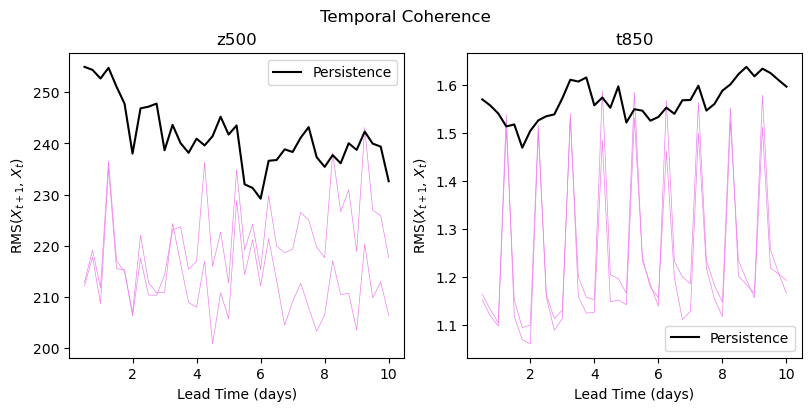

In [30]:
days = [t/24 for t in k_series[1:]]

bat_ch = 0
dx_dir = ((forecast[:, :, 1:, :] - forecast[:, :, :-1, :])**2).mean(dim=(-1,-2)).sqrt().mean(dim=(0)).cpu().permute(1,0,2)

dx_per = ((truth[:, 1:, :] - truth[:, :-1, :])**2).mean(dim=(-1,-2)).sqrt().mean(dim=(0)).cpu()

#print(same_latent.mean(), different_latent.mean())
plt.figure(figsize=(5,3))
fig, axes = plt.subplots(1,2, figsize=(8, 4), constrained_layout=True)

#plt.plot(different_latent, label = "Uncorrelated", color='#EE82EE')
#axes[0].plot(days, dx_dir[:,0].mean(dim=1), label = "Direct", color='k', linewidth=1, linestyle='--')
axes[0].plot(days, dx_dir[:,:,0], color='#EE82EE', linewidth=0.5)

#axes[1].plot(days, dx_dir[:,1].mean(dim=1), label = "Direct", color='k', linewidth=1, linestyle='--')
axes[1].plot(days, dx_dir[:,:,1], color='#EE82EE', linewidth=0.5)

axes[0].plot(days, dx_per[:,0], label = "Persistence", color='k')#, linestyle='--')
axes[1].plot(days, dx_per[:,1], label = "Persistence", color='k')#, linestyle='--')

axes[0].set_title('z500')
axes[1].set_title('t850')

for ax in axes:
    ax.set_xlabel('Lead Time (days)')
    ax.set_ylabel('RMS($X_{t+1}$, $X_t$)')
    #ax.set_xticks([1,3,5, 7, 9])
    ax.legend()

plt.suptitle('Temporal Coherence')


#plt.savefig(f'figures/240917/temp_coh-eps1.png', dpi=100, format='png', bbox_inches='tight')
#plt.savefig(f'figures/240917/temp_coh-{eval_name}.png', dpi=100, format='png', bbox_inches='tight')

In [32]:
u_forecast = (forecast[:,:,:,3]**2 + forecast[:,:,:,4]**2).sqrt().unsqueeze(3)
u_truth = (truth[:,:,3]**2 + truth[:,:,4]**2).sqrt().unsqueeze(2)
u_initial = (initial[:,3]**2 + initial[:,4]**2).sqrt().unsqueeze(1)

#initial = torch.cat((initial, u_initial), dim=1)
#forecast = torch.cat((forecast, u_forecast), dim=3)
#truth = torch.cat((truth, u_truth), dim=2)

#var_names.append('ws10')

#u_forecast_different = (forecast[:,1:,:,3]**2 + forecast[:,:1,:,4]**2).sqrt().unsqueeze(3)

skill_same = calculate_WSkill(u_forecast, u_truth)
#skill_different = calculate_WSkill(u_forecast_different, u_truth)
persistence_skill = calculate_WSkill(u_initial.unsqueeze(1).unsqueeze(2).expand(-1, 1, u_truth.shape[1], -1, -1, -1), u_truth)



In [28]:
u_forecast_different = (forecast[:,:,:,3]**2 + forecast[:,:,:,4]**2).sqrt().unsqueeze(3)
skill_different = calculate_WSkill(u_forecast_different, u_truth)
persistence_skill = calculate_WSkill(u_initial.unsqueeze(1).unsqueeze(2).expand(-1, 1, u_truth.shape[1], -1, -1, -1), u_truth)


NameError: name 'skill_same' is not defined

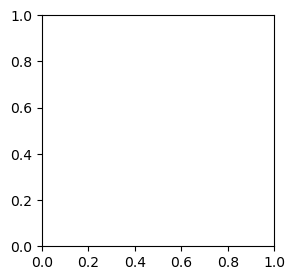

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

days = [t/24 for t in k_series]
markers_sz = [10 if k%iterative_steps ==0 else 3 for k in k_series]
#days = k_series
var_ch = 0

ax.plot(days, skill_same[:, var_ch], label='Skill',color='#EE82EE')
ax.scatter(days, skill_same[:, var_ch], s = markers_sz,color='#EE82EE', linewidth=1)

ax.plot(days, skill_different[:, var_ch], label='Skill different', color='#0000FF')
ax.scatter(days, skill_different[:, var_ch],s = markers_sz,color='#0000FF', linewidth=1)

#ax.plot(days, wrmse[:, :, var_ch].mean(axis=0), label='WRMSE',color='#EF228E')
#ax.scatter(days, wrmse[:, :, var_ch].mean(axis=0),s = markers_sz,color='#EF228E', linewidth=1)

ax.plot(days, persistence_skill[:, var_ch], label='Persistence', color='k')
ax.set_title(var_names[var_ch])
ax.set_xlabel('Lead Time (days)')
#ax.set_xticks([0,1,3,5,7,9])
#ax.set_xticks([0, 6, 12, 18, 24, 36])#, 7, 9])

#ax.set_yticks(scale*np.array([0, 1, 2, 3, 4, 5]))
ax.set_ylim(bottom=0)
#ax.set_xlim([0,2])
ax.legend()
ax.grid('on')


plt.tight_layout()
#plt.savefig('figures/240920/skill_direct_windspeed.png', transparent=True, dpi=300, bbox_inches='tight')
plt.show()

In [28]:
def generate_batch_ensemble_from_time_series(model, n_ens=10, selected_loader = val_time_series_loader, sampler_fn=heun_sampler, iterative_steps = 24):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    previous, current, time_labels = next(iter(selected_loader))

    n_samples = current.shape[0]
    n_times = time_labels.shape[1]
    dx = current.shape[2]
    dy = current.shape[3]

    n_conditions = previous.shape[1]

    with torch.no_grad():
        previous = previous.to(device)
        current = current.view(-1, vars, dx, dy).to(device)
        # They end up in (btc1: t1, t2,..., btc2: t1,...)
        
        direct_time_labels = torch.tensor(np.array([x for x in time_labels[0] if x <= iterative_steps]), device=device)
        n_iter = time_labels.shape[1] // direct_time_labels.shape[0]
        
        n_direct = direct_time_labels.shape[0]

        previous_state = previous[:,:vars]
        class_labels = previous.repeat_interleave(n_direct * n_ens, dim=0) # Can not be changed if batchsz > 1

        static_fields = class_labels[:, -static_vars:]

        latent_shape = (n_samples * n_ens, 1, dx, dy)

        direct_time_labels = direct_time_labels.repeat(n_ens * n_samples) # Can not be changed if n_direct > 1

        # Test
        predicted_combined = torch.zeros((n_samples, n_ens, n_times, vars, dx, dy), device=device)
        
        for i in range(n_iter):
            latents = torch.randn(latent_shape, device=device)
            latents = latents.expand(-1, vars, -1, -1)
            latents = latents.repeat_interleave(n_direct, dim=0) # Can not be changed if batchsz > 1 or n_ens >1
            
            predicted = sampler_fn(model, latents, class_labels, direct_time_labels /lead_time_max, 
                                    sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)

            predicted_combined[:, :, i*n_direct:(i+1)*n_direct] = predicted.view(n_samples, n_ens, n_direct, vars, dx, dy)

            predicted = predicted.view(n_samples*n_ens, n_direct, vars, dx, dy)
            class_labels = class_labels.view(n_samples*n_ens*n_direct, n_conditions, dx, dy)

            if n_direct == 1:
                class_labels = torch.cat((predicted[:,-1], class_labels[:,:vars]), dim=1)
            else:
                class_labels = torch.cat((predicted[:,-1], predicted[:,-3]), dim=1).repeat_interleave(n_direct, dim=0) # Can not be changed if batchsz > 1
            
            if static_vars != 0:
                class_labels = torch.cat((class_labels, static_fields), dim=1)

        predicted = predicted_combined
        predicted_unnormalized = renormalize(predicted)
        current_unnormalized = renormalize(current)
        previous_unnormalized = renormalize(previous_state)

        predicted_unnormalized = predicted_unnormalized.view(n_samples, n_ens, n_times, vars, dx, dy)
        current_unnormalized = current_unnormalized.view(n_samples, n_times, vars, dx, dy)
        previous_unnormalized = previous_unnormalized.view(n_samples, vars, dx, dy)
        
    return predicted_unnormalized, current_unnormalized, previous_unnormalized

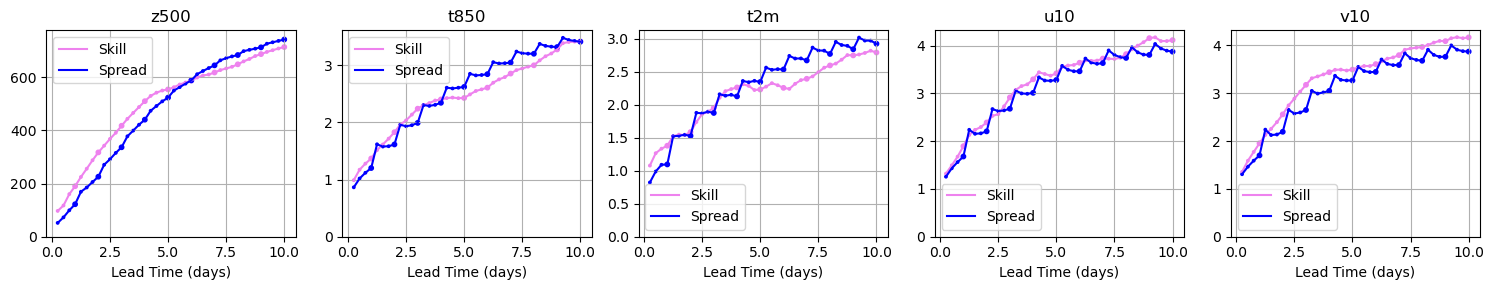

In [200]:
fig, axs = plt.subplots(1, len(var_names), figsize=(3*len(var_names), 3))

days = [t/24 for t in k_series]
markers_sz = [10 if k%iterative_steps ==0 else 3 for k in k_series]
#days = k_series

def plot_axs(ax, var_ch, scale=1):
    ax.plot(days, skill[:, var_ch], label='Skill',color='#EE82EE')
    ax.scatter(days, skill[:, var_ch], s = markers_sz,color='#EE82EE', linewidth=1)

    ax.plot(days, spread[:, var_ch], label='Spread', color='#0000FF')
    ax.scatter(days, spread[:, var_ch],s = markers_sz,color='#0000FF', linewidth=1)
    
    #ax.plot(days, wrmse[:, :, var_ch].mean(axis=0), label='WRMSE',color='#EF228E')
    #ax.scatter(days, wrmse[:, :, var_ch].mean(axis=0),s = markers_sz,color='#EF228E', linewidth=1)
    
    #ax.plot(days, persistence_skill[:, var_ch], label='Persistence', color='k')
    ax.set_title(var_names[var_ch])
    ax.set_xlabel('Lead Time (days)')
    #ax.set_xticks([0,1,3,5,7,9])
    #ax.set_xticks([0, 6, 12, 18, 24, 36])#, 7, 9])

    #ax.set_yticks(scale*np.array([0, 1, 2, 3, 4, 5]))
    ax.set_ylim(bottom=0)
    #ax.set_xlim([0,2])
    ax.legend()
    ax.grid('on')

for i, _ in enumerate(var_names):
    plot_axs(axs[i], i, 1)

plt.tight_layout()
#plt.savefig('figures/240920/skill_spread_windspeed.png', transparent=True, dpi=300, bbox_inches='tight')
plt.show()

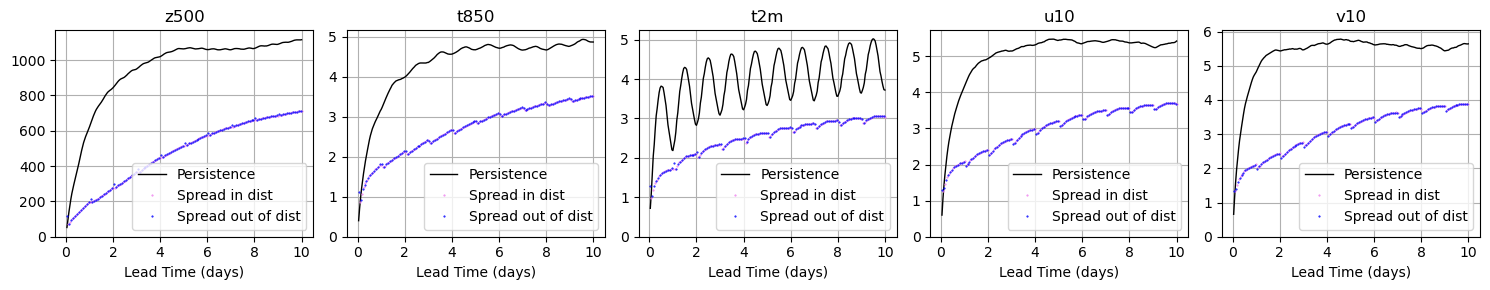

In [74]:
## Test to see if the dx1 is different from the dx2

fig, axs = plt.subplots(1, len(var_names), figsize=(3*len(var_names), 3))

days = [t/24 for t in k_series]
markers_sz = [10 if k%iterative_steps ==0 else 3 for k in k_series]
#days = k_series

def plot_axs(ax, var_ch, scale=1):
    ax.plot(days, persistence_skill[:, var_ch], label='Persistence', color='k', linewidth=1)
    ax.plot(days[1::2], spread[1::2, var_ch], label='Spread in dist',color='#EE82EE', marker='.', linewidth=0, markersize=1)

    #ax.plot(days[1::2], spread[1::2, var_ch], label='Spread in dist', color='#EE82EE', linestyle='--')

    ax.plot(days[::2], spread[::2, var_ch], label='Spread out of dist',color='#0000FF', marker='.',linewidth=0, markersize=1)

    #ax.plot(days[::2], spread[::2, var_ch], label='Spread out of dist', color='#0000FF', linestyle='--')
    
    #ax.plot(days, wrmse[:, :, var_ch].mean(axis=0), label='WRMSE',color='#EF228E')
    #ax.scatter(days, wrmse[:, :, var_ch].mean(axis=0),s = markers_sz,color='#EF228E', linewidth=1)
    
    ax.set_title(var_names[var_ch])
    ax.set_xlabel('Lead Time (days)')
    #ax.set_xticks([0,1,3,5,7,9])
    #ax.set_xticks([0, 6, 12, 18, 24, 36])#, 7, 9])

    #ax.set_yticks(scale*np.array([0, 1, 2, 3, 4, 5]))
    ax.set_ylim(bottom=0)
    #ax.set_xlim([0,2])
    ax.legend()
    ax.grid('on')

for i, _ in enumerate(var_names):
    plot_axs(axs[i], i, 1)

plt.tight_layout()
plt.savefig('figures/240920/spread_both.png', transparent=True, dpi=600, bbox_inches='tight')
plt.show()

(-0.5, 29.5, 1.5, -0.5)

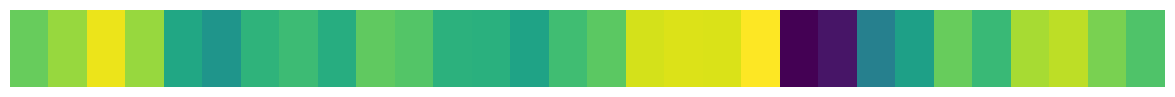

In [379]:
plt.figure(figsize=(50,1))
plt.imshow(latents.mean(dim=(2,3)).cpu().permute(1,0)[:,:30])
plt.axis('off')

### Calculate long-term scores

In [460]:
wrmse_list = []
skill_list = []
spread_list = []
persistence_skill_list = []

In [461]:
forecast_fn= generate_ensemble_from_time_series
sampler_fn = heun_sampler

for i in tqdm(range(1)):
    forecast, truth, initial = forecast_fn(model, n_ens=10, selected_loader = val_time_series_loader, sampler_fn=sampler_fn)
    wrmse = calculate_WRMSE(forecast, truth)
    skill = calculate_WSkill(forecast, truth)
    spread = calculate_WSpread(forecast, truth)
    persistence_skill = calculate_WSkill(initial[:vars].unsqueeze(0), truth)

    wrmse_list.append(wrmse)
    skill_list.append(skill)
    spread_list.append(spread)
    persistence_skill_list.append(persistence_skill)

skill = torch.tensor(np.array(skill_list)).mean(axis=0)
spread = torch.tensor(np.array(spread_list)).mean(axis=0)
persistence_skill = torch.tensor(np.array(persistence_skill_list)).mean(axis=0)
wrmse = torch.tensor(np.array(wrmse_list)).mean(axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.10s/it]


### Ensemble Animation

In [327]:
forecast.shape

torch.Size([10, 50, 40, 5, 32, 64])

In [29]:
var_ch = 5
bat_ch = 0

time_labels=k_series

dt = len(time_labels)
dx = forecast.shape[4]
dy = forecast.shape[5]

truth_plot = (truth[bat_ch,:,var_ch]).cpu().detach().numpy().reshape((-1, dx, dy))# - climatology[var_ch]
forecast_plot = (forecast[bat_ch,:,:,var_ch]).cpu().detach().numpy().reshape((forecast.shape[1], dt, dx,dy))# - climatology[var_ch]

ens_mean = forecast_plot.mean(axis=0)
ens_std = forecast_plot.std(axis=0)

cmap_z = plt.cm.get_cmap('viridis') #, 20)     #t850
cmap_t = plt.cm.get_cmap('hot')     #, 35)     #t850

cmaps = [cmap_u, cmap_u, cmap_u, cmap_u, cmap_u, cmap_u]
cmap = cmaps[var_ch]

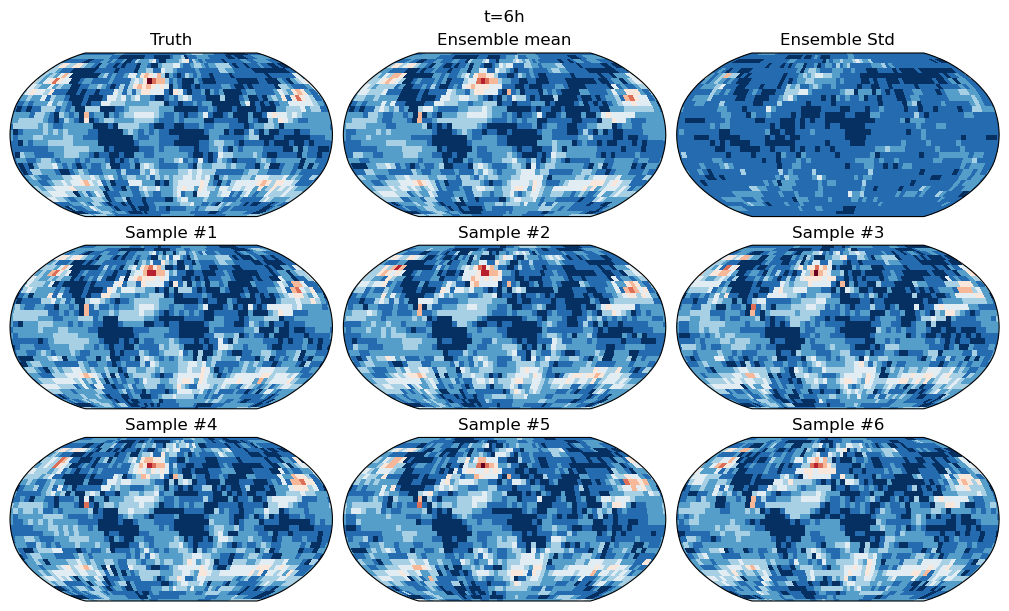

In [33]:
%matplotlib inline
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

fig, axes = plt.subplots(3,3, figsize=(10,6), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})
#fig, axes = plt.subplots(3,3, figsize=(10,5), constrained_layout=True)

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    #ax.axis('off')
    #ax.coastlines(resolution='110m', linewidth=0.5, color='k')
    #gridlines = ax.gridlines()
    #gridlines.linewidth = 0.5
    pass

title1 = axes[0,0].set_title('')
title2 = axes[0,1].set_title('')
title3 = axes[0,2].set_title('')
#titles = []
#for j in range(1, 4):
#    axes[0,j+1].set_title(f"Sample #{j}")

images = []
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        pass
        cf = ax.pcolormesh(lon, lat, truth_plot[0], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max(), transform=ccrs.PlateCarree())
        #cf = ax.imshow(truth_plot[0], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max())
        images.append(cf)
        
    elif i == 1:
        cf = ax.pcolormesh(lon, lat, ens_mean[0], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max(), transform=ccrs.PlateCarree())
        #cf = ax.imshow(ens_mean[0], cmap=cmap)
        images.append(cf)

    elif i == 2:
        cf = ax.pcolormesh(lon, lat, ens_std[0], cmap=cmap, vmin=0, vmax=ens_std.max(), transform=ccrs.PlateCarree())
        #cf = ax.imshow(ens_std[0], cmap=cmap, vmin=0, vmax=ens_std.max())
        images.append(cf)
        
    else:
        pass
        cf = ax.pcolormesh(lon, lat, forecast_plot[i-3,0], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max(), transform=ccrs.PlateCarree())
        #cf = ax.imshow(forecast_plot[i-3,0], cmap=cmap, vmin=forecast_plot.min(), vmax=forecast_plot.max())
        images.append(cf)
        ax.set_title(f'Sample #{i-2}')

# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        if i == 0:
            im.set_array(truth_plot[n].flatten())
        elif i == 1:
            im.set_array(ens_mean[n].flatten())
        elif i == 2:
            im.set_array(ens_std[n].flatten())
        else:
            pass
            im.set_array(forecast_plot[i-3,n].flatten())

    txt_title.set_text(f't={time_labels[n].item()}h')
    title1.set_text('Truth')
    title2.set_text('Ensemble mean')
    title3.set_text('Ensemble Std')
# 
    return images

anim = animation.FuncAnimation(fig, drawframe, frames=dt, interval=100)

anim.save(f'figures/paper/animations/animation-{var_names[var_ch]}-pixel.gif', writer='imagemagick', fps=10)
#anim.save(f'figures/paper/animations/animation-{var_names[var_ch]}.gif', writer='imagemagick', fps=10)
HTML(anim.to_html5_video())

In [84]:
anim.save('figures/animation_t2m_direct.gif', writer='imagemagick', fps=8, dpi=300)

### Smaller Animation

In [186]:
forecast.shape
truth.shape

torch.Size([48, 10, 6, 32, 64])

In [ ]:
ti

In [182]:
time_labels=k_series

ens_ch = 2

dt = len(time_labels)
dx = forecast.shape[3]
dy = forecast.shape[4]

#initial_plot_t850 = (initial[0,1]).cpu().detach().numpy().reshape((dx, dy))# - climatology[var_ch]
#initial_plot_z500 = (initial[0,0]).cpu().detach().numpy().reshape((dx, dy))# - climatology[var_ch]

truth_plot_t850 = (truth[:,1]).cpu().detach().numpy().reshape((-1, dx, dy)) # - initial_plot_t850
truth_plot_z500 = (truth[:,0]).cpu().detach().numpy().reshape((-1, dx, dy)) #- initial_plot_z500

forecast_plot_t850 = (forecast[:,:,1]).cpu().detach().numpy().reshape((forecast.shape[0], dt, dx,dy)) #- initial_plot_t850
forecast_plot_z500 = (forecast[:,:,0]).cpu().detach().numpy().reshape((forecast.shape[0], dt, dx,dy)) #- initial_plot_z500

ValueError: cannot reshape array of size 1179648 into shape (48,10,6,32)

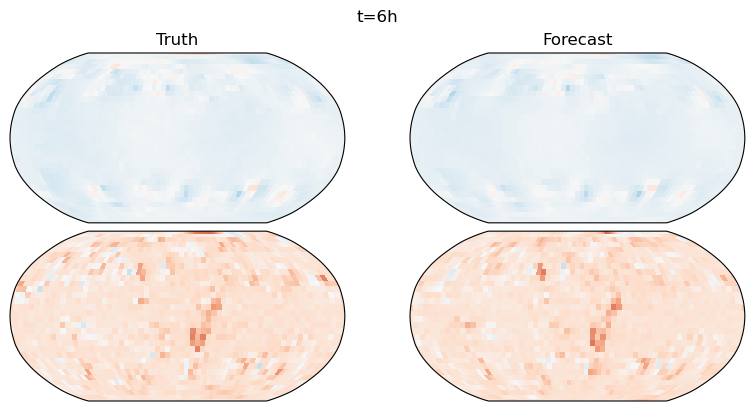

In [399]:
# Also animation but smaller
%matplotlib inline
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML


# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

fig, axes = plt.subplots(2, 2, figsize=(8, 4), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})
#fig, axes = plt.subplots(3,3, figsize=(10,5), constrained_layout=True)

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    #ax.axis('off')
    #ax.coastlines(resolution='110m', linewidth=0.5, color='k')
    #gridlines = ax.gridlines()
    #gridlines.linewidth = 0.5
    pass

title1 = axes[0,0].set_title('')
title2 = axes[0,1].set_title('')

images = []
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        pass
        cf = ax.pcolormesh(lon, lat, truth_plot_z500[0], cmap=cmap_u, vmin=truth_plot_z500.min(), vmax=truth_plot_z500.max(), transform=ccrs.PlateCarree())
        images.append(cf)
        
    elif i == 1:
        cf = ax.pcolormesh(lon, lat, forecast_plot_z500[ens_ch, 0], cmap=cmap_u, vmin=truth_plot_z500.min(), vmax=truth_plot_z500.max(), transform=ccrs.PlateCarree())
        images.append(cf)

    elif i == 2:
        cf = ax.pcolormesh(lon, lat, truth_plot_t850[0], cmap=cmap_u, vmin=truth_plot_t850.min(), vmax=truth_plot_t850.max(), transform=ccrs.PlateCarree())
        images.append(cf)
        
    else:
        cf = ax.pcolormesh(lon, lat, forecast_plot_t850[ens_ch, 0], cmap=cmap_u, vmin=truth_plot_t850.min(), vmax=truth_plot_t850.max(), transform=ccrs.PlateCarree())
        images.append(cf)

# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        if i == 0:
            im.set_array(truth_plot_z500[n].flatten())
        elif i == 1:
            im.set_array(forecast_plot_z500[ens_ch, n].flatten())
        elif i == 2:
            im.set_array(truth_plot_t850[n].flatten())
        else:
            pass
            im.set_array(forecast_plot_t850[ens_ch, n].flatten())

    txt_title.set_text(f't={time_labels[n].item()}h')
    title1.set_text('Truth')
    title2.set_text('Forecast')
# 
    return images

anim = animation.FuncAnimation(fig, drawframe, frames=dt, interval=100)

#anim.save('figures/animation_z500.gif', writer='imagemagick', fps=12)
HTML(anim.to_html5_video())

In [402]:
anim.save('figures/240910/eps0.07-0.01.gif', writer='imagemagick', fps=12)


### Larger animation

In [189]:
forecast.shape
truth.shape

torch.Size([48, 10, 6, 32, 64])

In [192]:
#time_labels=k_series

num_ens = 2

bat_ch = 1

dt = len(time_labels)
dx = forecast.shape[4]
dy = forecast.shape[5]

truth_plot = (truth[bat_ch,:,:]).cpu().detach().numpy().reshape((dt, len(var_names), dx, dy))# - climatology[var_ch]
forecast_plot = (forecast[bat_ch,:,:,:]).cpu().detach().numpy().reshape((forecast.shape[1], dt, len(var_names), dx,dy))# - climatology[var_ch]

cmaps = [cmap_u, cmap_u, cmap_u, cmap_u, cmap_u, cmap_u]

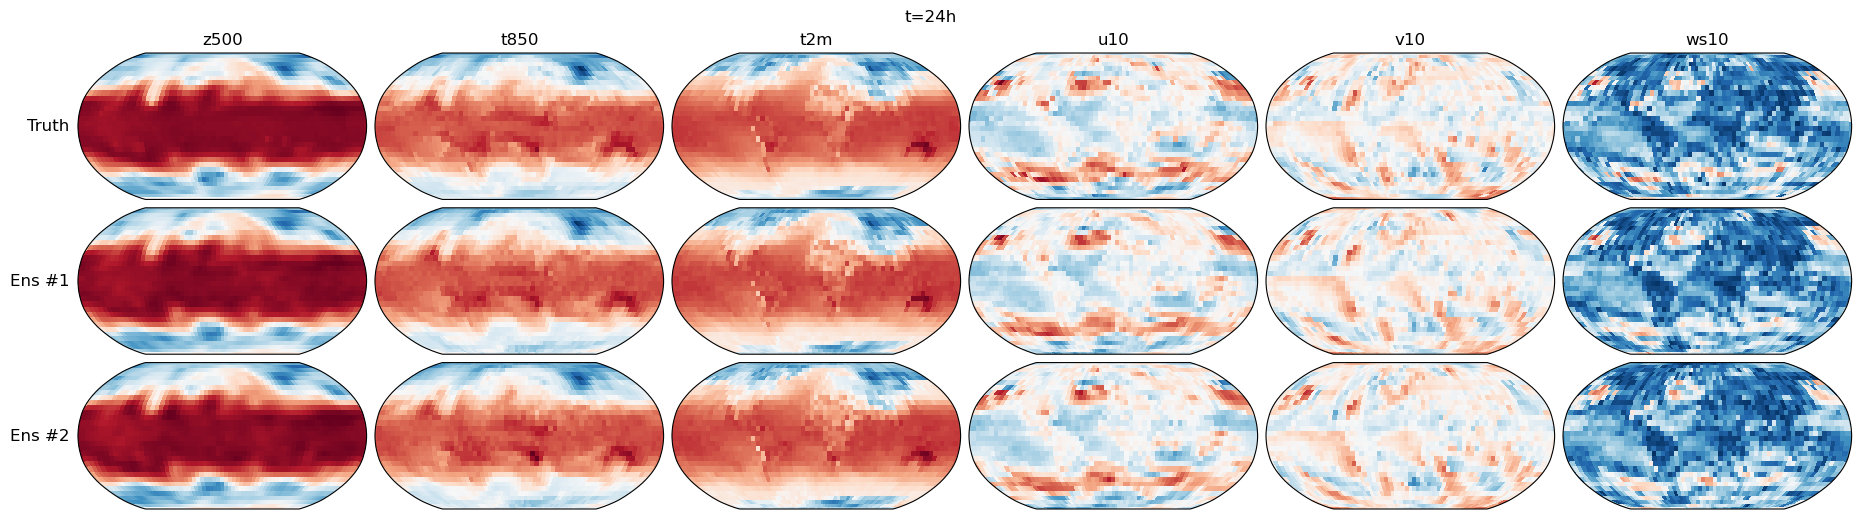

In [194]:
# Also animation but smaller
%matplotlib inline
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML


# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

fig, axes = plt.subplots(1+num_ens, len(var_names), figsize=(0.5+3*len(var_names), (1+num_ens)*1.7), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})
#fig, axes = plt.subplots(3,3, figsize=(10,5), constrained_layout=True)

row_names = []
ylabels = []
# Add "row labels" as y-axis labels in the leftmost column
for i, ax_row in enumerate(axes):
    if i == 0:
        label = 'Truth'
    else:
        label = f'Ens #{i}'
    
    row_names.append(label)
    
    ylabel = ax_row[0].text(-18000000, 1, label , va='center', ha='right', fontsize=12)
    ylabels.append(ylabel)

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    #ax.axis('off')
    #ax.coastlines(resolution='110m', linewidth=0.5, color='k')
    #gridlines = ax.gridlines()
    #gridlines.linewidth = 0.5
    pass

title1 = axes[0,0].set_title('')
title2 = axes[0,1].set_title('')

images = []
for i, ax in enumerate(axes.flatten()):
    if i < len(var_names):
        cf = ax.pcolormesh(lon, lat, truth_plot[0,i], cmap=cmaps[i], vmin=truth_plot[:,i].min(), vmax=truth_plot[:,i].max(), transform=ccrs.PlateCarree())
        images.append(cf)
        ax.set_title(var_names[i])
    else:
        j = i % len(var_names)
        ens_ch = i // len(var_names) - 1
        cf = ax.pcolormesh(lon, lat, forecast_plot[ens_ch, 0, j], cmap=cmaps[j], vmin=truth_plot[:,j].min(), vmax=truth_plot[:,j].max(), transform=ccrs.PlateCarree())
        images.append(cf)

# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        if i < len(var_names):
            im.set_array(truth_plot[n, i].flatten())
        else:
            j = i % len(var_names)
            ens_ch = i // len(var_names) - 1
            im.set_array(forecast_plot[ens_ch, n, j].flatten())

    txt_title.set_text(f't={time_labels[n].item()}h')
    return images

anim = animation.FuncAnimation(fig, drawframe, frames=dt, interval=150)

#anim.save('figures/animation_graph-efm.gif', writer='imagemagick', fps=12, dpi=300)
HTML(anim.to_html5_video())

In [87]:
anim.save('figures/animation_full_direct.gif', writer='imagemagick', fps=8, dpi=100)

### Temporal consistency

In [15]:
days = [t/24 for t in k_series[1:]]

bat_ch = 0
dx_dir = ((forecast[:, :, 1:, :] - forecast[:, :, :-1, :])**2).mean(dim=(4,5)).sqrt().mean(dim=(0)).cpu().permute(1,0,2)

dx_per = ((truth[:, 1:, :] - truth[:, :-1, :])**2).mean(dim=(3,4)).sqrt().mean(dim=(0)).cpu()

#print(same_latent.mean(), different_latent.mean())
plt.figure(figsize=(5,3))
fig, axes = plt.subplots(1,2, figsize=(8, 4), constrained_layout=True)

#plt.plot(different_latent, label = "Uncorrelated", color='#EE82EE')
#axes[0].plot(days, dx_dir[:,0].mean(dim=1), label = "Direct", color='k', linewidth=1, linestyle='--')
axes[0].plot(days, dx_dir[:,:,0], color='#EE82EE', linewidth=0.5)

#axes[1].plot(days, dx_dir[:,1].mean(dim=1), label = "Direct", color='k', linewidth=1, linestyle='--')
axes[1].plot(days, dx_dir[:,:,1], color='#EE82EE', linewidth=0.5)

axes[0].plot(days, dx_per[:,0], label = "Persistence", color='k')#, linestyle='--')
axes[1].plot(days, dx_per[:,1], label = "Persistence", color='k')#, linestyle='--')

axes[0].set_title('z500')
axes[1].set_title('t850')

for ax in axes:
    ax.set_xlabel('Lead Time (days)')
    ax.set_ylabel('RMS($X_{t+1}$, $X_t$)')
    #ax.set_xticks([1,3,5, 7, 9])
    ax.legend()

plt.suptitle('Temporal Coherence')


#plt.savefig(f'figures/240917/temp_coh-eps1.png', dpi=100, format='png', bbox_inches='tight')
#plt.savefig(f'figures/240917/temp_coh-{eval_name}.png', dpi=100, format='png', bbox_inches='tight')

IndexError: Dimension out of range (expected to be in range of [-5, 4], but got 5)

IndexError: index 2 is out of bounds for dimension 2 with size 2

<Figure size 500x300 with 0 Axes>

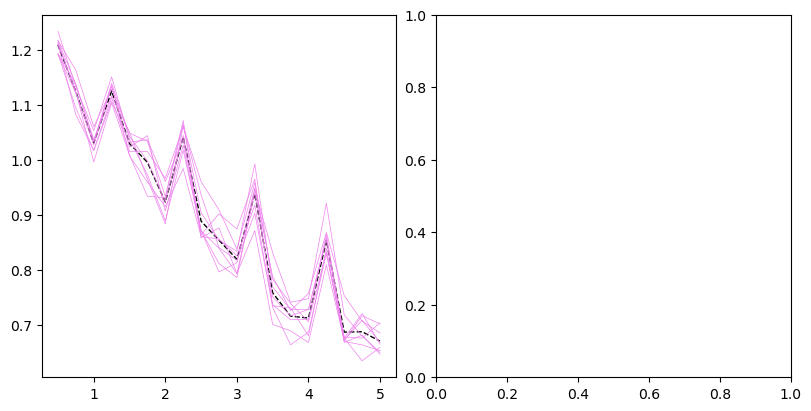

In [109]:
days = [t/24 for t in k_series[1:]]

#dx_iter = ((forecast_ar[1:, 1:, var_ch] - forecast_ar[1:, :-1, var_ch])**2).mean(dim=(2,3)).sqrt().cpu().permute(1,0)
#different_latent = ((forecast[1:, 1:, var_ch] - forecast[:-1, :-1, var_ch])**2).mean(dim=(2,3)).sqrt().cpu().permute(1,0)
dx_dir = ((forecast[bat_ch, 1:, 1:, :] - forecast[bat_ch, 1:, :-1, :])**2).mean(dim=(3,4)).sqrt().cpu().permute(1,0,2)

dx_per = ((truth[bat_ch, 1:, :] - truth[bat_ch, :-1, :])**2).mean(dim=(2,3)).sqrt().cpu()

#print(same_latent.mean(), different_latent.mean())
plt.figure(figsize=(5,3))
fig, axes = plt.subplots(1,2, figsize=(8, 4), constrained_layout=True)

#plt.plot(different_latent, label = "Uncorrelated", color='#EE82EE')
axes[0].plot(days, dx_dir[:,:,1].mean(dim=1), label = "Direct", color='k', linewidth=1, linestyle='--')
axes[0].plot(days, dx_dir[:,:,1], color='#EE82EE', linewidth=0.5)

axes[1].plot(days, dx_dir[:,:,2].mean(dim=1), label = "Direct", color='k', linewidth=1, linestyle='--')
axes[1].plot(days, dx_dir[:,:,2], color='#EE82EE', linewidth=0.5)

#plt.plot(days, dx_iter.mean(dim=1), label = "Iterated", color='#0000FF', linewidth=0.5)
#plt.plot(days, dx_iter, color='#0000FF', linewidth=0.5)

axes[0].plot(days, dx_per[:,1], label = "Persistence", color='k')#, linestyle='--')
axes[1].plot(days, dx_per[:,2], label = "Persistence", color='k')#, linestyle='--')

axes[0].set_title('z500')
axes[1].set_title('t850')

for ax in axes:
    ax.set_xlabel('Lead Time (days)')
    ax.set_ylabel('RMS($X_{t+1}$, $X_t$)')
    #ax.set_xticks([1,3,5, 7, 9])
    ax.legend()

plt.suptitle('Temporal Coherence')


#plt.savefig(f'figures/240910/temp-const.png', dpi=100, format='png', bbox_inches='tight')

### GIF Generator

In [33]:
cmap_z = plt.cm.get_cmap('viridis', 50) #z500
cmap_t = plt.cm.get_cmap('hot', 50)     #t850

In [72]:
t_kmin = 6
t_kmax = 24*5
t_d = 6
k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=False)

forecast, truth, initial = generate_ensemble_from_time_series(model, n_ens=3, selected_loader = val_time_series_loader, sampler_fn=heun_sampler)
wrmse = calculate_WRMSE(forecast, truth)
skill = calculate_WSkill(forecast, truth)
spread = calculate_WSpread(forecast, truth)

In [73]:
time_labels=k_series

dt = len(time_labels)
dx = forecast.shape[3]
dy = forecast.shape[4]

var_ch = 1
truth_plot = (truth[:,var_ch]).cpu().detach().numpy().reshape((-1, dx, dy))# - climatology[var_ch]
forecast_plot = (forecast[:,:,var_ch]).cpu().detach().numpy().reshape((forecast.shape[0], dt, dx,dy))# - climatology[var_ch]

ens_mean = forecast_plot.mean(axis=0)
ens_std = forecast_plot.std(axis=0)

In [27]:
initial_plot_t850 = (initial[0,1]).cpu().detach().numpy().reshape((dx, dy))# - climatology[var_ch]
initial_plot_z500 = (initial[0,0]).cpu().detach().numpy().reshape((dx, dy))# - climatology[var_ch]

truth_plot_t850 = (truth[:,1]).cpu().detach().numpy().reshape((-1, dx, dy))# - climatology[var_ch]
truth_plot_z500 = (truth[:,0]).cpu().detach().numpy().reshape((-1, dx, dy))# - climatology[var_ch]

forecast_plot_t850 = (forecast[:,:,1]).cpu().detach().numpy().reshape((forecast.shape[0], dt, dx,dy))# - climatology[var_ch]
forecast_plot_z500 = (forecast[:,:,0]).cpu().detach().numpy().reshape((forecast.shape[0], dt, dx,dy))# - climatology[var_ch]

In [28]:
import matplotlib.pyplot as plt

for i in range(dt):
    fig, axes = plt.subplots(2,1, figsize=(4,4.3), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})
    axes[0].pcolormesh(lon, lat, truth_plot_z500[i], cmap=cmap_z, vmin=truth_plot_z500.min(), vmax=truth_plot_z500.max(), transform=ccrs.PlateCarree())
    axes[1].pcolormesh(lon, lat, truth_plot_t850[i], cmap=cmap_t, vmin=truth_plot_t850.min(), vmax=truth_plot_t850.max(), transform=ccrs.PlateCarree())
 
    #plt.savefig(f'gifs/truth_z500/frame_{i+1}.png', bbox_inches='tight', pad_inches=0)
    plt.savefig(f'gifs/truth/frame_{i+1}.png', bbox_inches='tight', transparent=True, dpi=300)
    plt.close()

In [31]:
import matplotlib.pyplot as plt

ens = 2
folder = f'cont_{ens+1}'

for i in range(dt):
    fig, axes = plt.subplots(2,1, figsize=(4,4.3), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})
    axes[0].pcolormesh(lon, lat, forecast_plot_z500[ens, i], cmap=cmap_z, vmin=truth_plot_z500.min(), vmax=truth_plot_z500.max(), transform=ccrs.PlateCarree())
    axes[1].pcolormesh(lon, lat, forecast_plot_t850[ens, i], cmap=cmap_t, vmin=truth_plot_t850.min(), vmax=truth_plot_t850.max(), transform=ccrs.PlateCarree())
 
    plt.savefig(f'gifs/{folder}/frame_{i+1}.png', bbox_inches='tight', transparent=True, dpi=300)
    plt.close()

In [32]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2,1, figsize=(4,4.3), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})
axes[0].pcolormesh(lon, lat, initial_plot_z500, cmap=cmap_z, vmin=truth_plot_z500.min(), vmax=truth_plot_z500.max(), transform=ccrs.PlateCarree())
axes[1].pcolormesh(lon, lat, initial_plot_t850, cmap=cmap_t, vmin=truth_plot_t850.min(), vmax=truth_plot_t850.max(), transform=ccrs.PlateCarree())

#plt.savefig(f'gifs/truth_z500/frame_{i+1}.png', bbox_inches='tight', pad_inches=0)
plt.savefig(f'gifs/frame_0.png', bbox_inches='tight', transparent=True, dpi=300)
plt.close()

# Old Plots

#### **States**

##### **State:** Denoising of states over time

NameError: name 'ax' is not defined

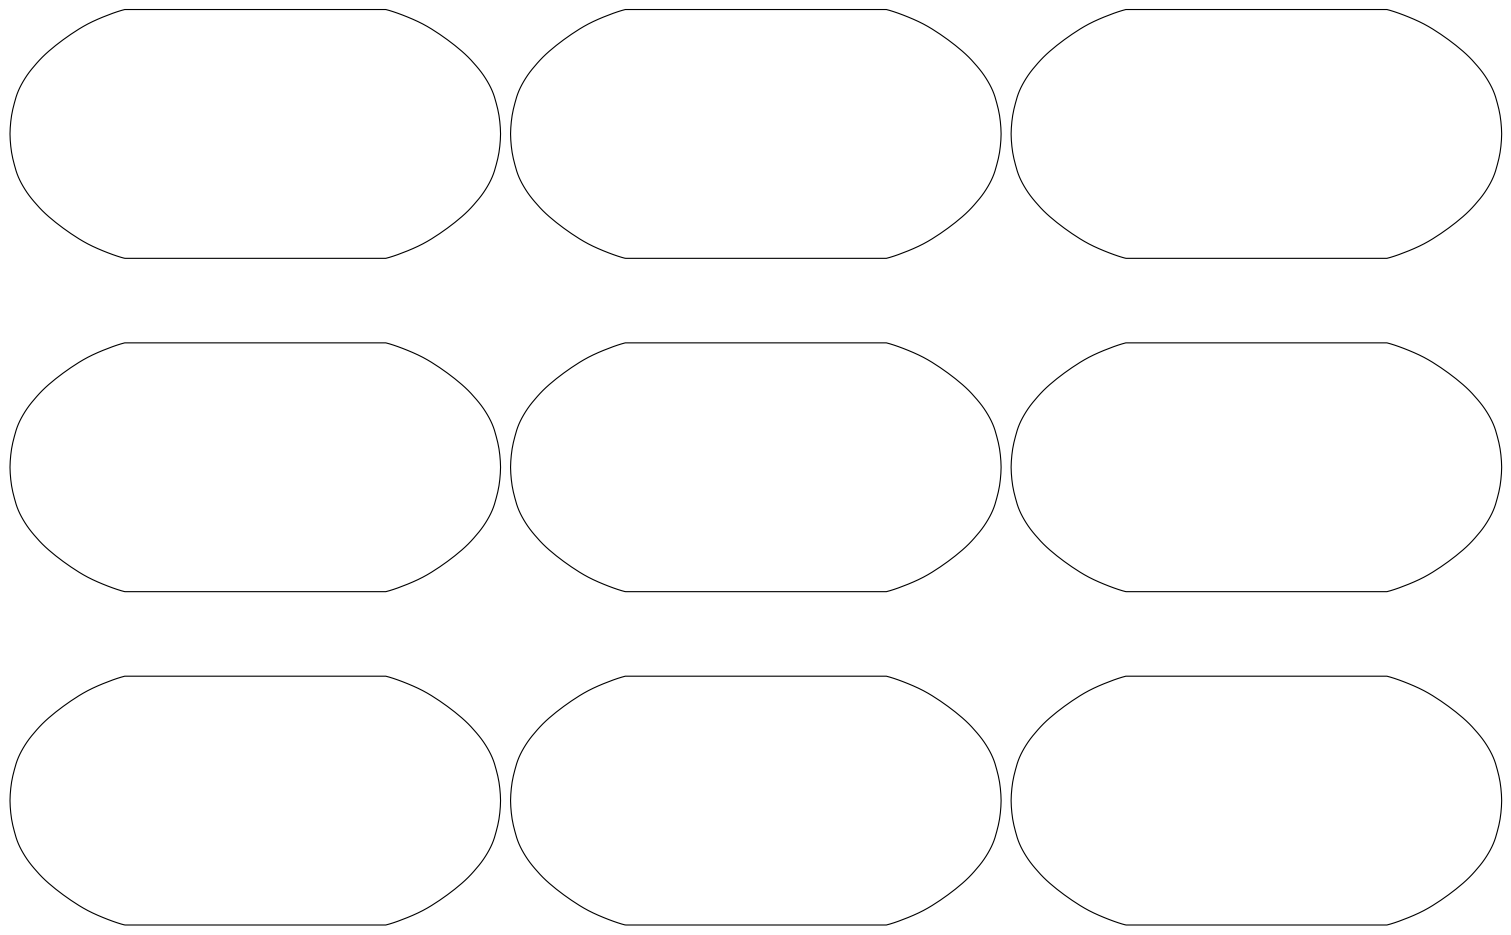

In [9]:
fig, axes = plt.subplots(3,3, figsize=(15,10), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})
cf = ax.pcolormesh(lon, lat, truth_plot[0], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max(), transform=ccrs.PlateCarree())
        

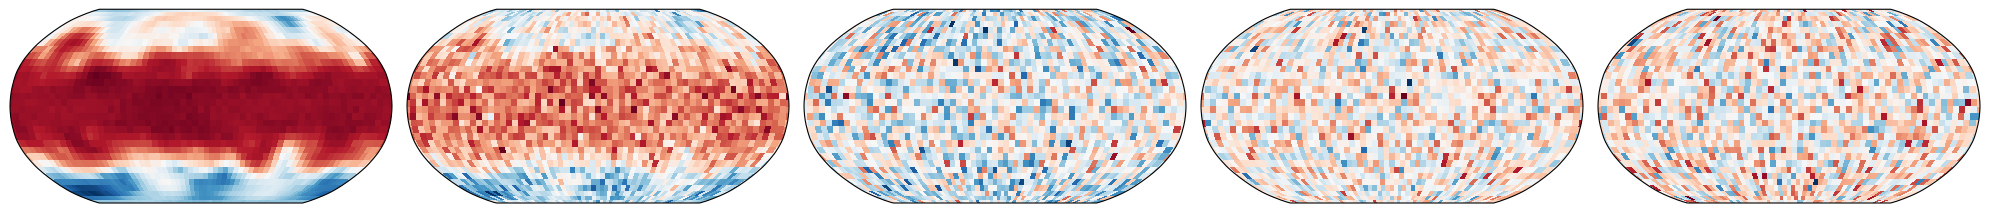

In [13]:
def plot_noising_of_states():
    """
    Plot the denoising of random states
    """
    image =  next(iter(train_loader))[0][0,0] #* std_data + mean_data

    noisy_images = []
    max_num = 5
    for i in range(max_num):

        rnd_uniform = 1 - i/(max_num-1)
        rho_inv = 1 / 7
        sigma_max_rho = 88 ** rho_inv
        sigma_min_rho = 0.02 ** rho_inv
        
        sigma = (sigma_max_rho + rnd_uniform * (sigma_min_rho - sigma_max_rho)) ** 7

        weight = (sigma ** 2 + 1 ** 2) / (sigma * 1) ** 2

        noise = torch.randn_like(image)
        noisy_image = image + sigma * noise
        
        noisy_images.append(noisy_image.cpu().detach().numpy())

    fig, axes = plt.subplots(1, max_num, figsize=(20, 4), subplot_kw={'projection': ccrs.Robinson()})
    for i in range(max_num):
        axes[i].pcolormesh(lon, lat, noisy_images[i], cmap=cmap_u, transform=ccrs.PlateCarree())

    plt.tight_layout()

    #plt.savefig('figures/noisy_images.png', format='png', bbox_inches='tight', dpi=300, transparent=True)
    plt.show()

plot_noising_of_states()

In [19]:
image =  next(iter(train_loader))[0][0,2] #* std_data + mean_data

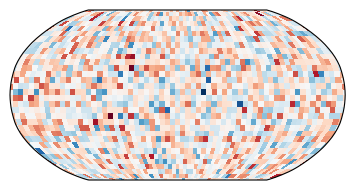

In [27]:
"""
Plot the denoising of random states
"""
frac = 1

rnd_uniform = 1 - frac
rho_inv = 1 / 7
sigma_max_rho = 88 ** rho_inv
sigma_min_rho = 0.02 ** rho_inv

sigma = (sigma_max_rho + rnd_uniform * (sigma_min_rho - sigma_max_rho)) ** 7

weight = (sigma ** 2 + 1 ** 2) / (sigma * 1) ** 2

noise = torch.randn_like(image)
noisy_image = image + sigma * noise

#noisy_images.append(noisy_image.cpu().detach().numpy())

fig, ax = plt.subplots(1, 1, figsize=(5, 2), subplot_kw={'projection': ccrs.Robinson()})

ax.pcolormesh(lon, lat, noisy_image, cmap=cmap_u, transform=ccrs.PlateCarree())

plt.tight_layout()

plt.savefig(f'figures/paper/poster/t2m_{frac}.png', format='png', bbox_inches='tight', dpi=600, transparent=True)
plt.show()


##### **State:** Autoencoder comparison

In [ ]:
image =  next(iter(train_loader))[0] #* std_data + mean_data

In [ ]:
encoded = autoencoder.encoder(image.to(device)).detach().cpu()
reconstruction = autoencoder.decoder(encoded.to(device)).detach().cpu()

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(reconstruction[0,0], cmap=cmap)
ax.axis('off')

plt.tight_layout()

plt.savefig('figures/reconstruction.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()


##### **State:** Removing noise from image

In [36]:
temp = next(iter(train_loader))
image = temp[1][0,0]
cond = temp[0][0,0]

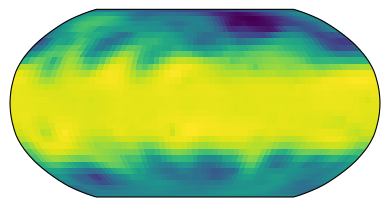

In [47]:
def plot_denoising_of_states():
    """
    Plot the denoising of random states
    """
    #image =  next(iter(train_loader))[0][0,0] #* std_data + mean_data

    noisy_images = []
    max_num = 6
    for i in range(max_num):

        rnd_uniform = 1 - i/(max_num-1)
        rho_inv = 1 / 7
        sigma_max_rho = 88 ** rho_inv
        sigma_min_rho = 0.02 ** rho_inv
        
        sigma = (sigma_max_rho + rnd_uniform * (sigma_min_rho - sigma_max_rho)) ** 7

        weight = (sigma ** 2 + 1 ** 2) / (sigma * 1) ** 2

        noise = torch.randn_like(image)
        noisy_image = image + sigma * noise
        
        noisy_images.append(noisy_image.cpu().detach().numpy())

    fig, axes = plt.subplots(1, 1, figsize=(4, 4), subplot_kw=dict(projection=ccrs.Robinson()))
    #plt_fn(axes,noisy_images[3])
    #axes.imshow(noisy_images[3] - noisy_images[0], cmap=cmap)
    axes.pcolormesh(lon, lat, noisy_images[0], cmap=cmap, transform=ccrs.PlateCarree())
    #axes.imshow(cond, cmap=cmap)
    #axes.axis('off')



    plt.tight_layout()
    plt.savefig('figures/cond.png', format='png', bbox_inches='tight', dpi=300, transparent=True)

    #plt.savefig('figures/noised.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

plot_denoising_of_states()

##### **State:** Standard plot of ensembles

In [ ]:
# Standard plot of ensembles

def ensemble_plot(model, selected_loader=val_loader, n_ens=10, sampler_fn=heun_sampler):
    
    lead_time = selected_loader.dataset.lead_time
    predicted_unnormalized, current_unnormalized, previous_unnormalized = generate_ensemble_from_single_random_noae(model, n_ens, selected_loader, sampler_fn=sampler_fn)

    ensemble_mean = predicted_unnormalized.mean(dim=0, keepdim=True)
    ensemble_rmses = calculate_RMSE(predicted_unnormalized, current_unnormalized).flatten()
    ensemble_skill = calculate_RMSE(ensemble_mean, current_unnormalized).item()
    ensemble_std = predicted_unnormalized.std(dim=0)

    best_forecast = predicted_unnormalized[np.argmin(ensemble_rmses)]
    best_rmse = ensemble_rmses[np.argmin(ensemble_rmses)]

    def plot_image(ax, image, title):
        image = image.cpu().detach().numpy().reshape((current_unnormalized.shape[2],current_unnormalized.shape[3]))
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        ax.axis('off')

    plt.set_cmap('viridis')
    no_ens_rows = 2

    fig, axes = plt.subplots(1+no_ens_rows, 5, figsize=(15, 10))
    fig.suptitle(f'{lead_time} step ahead prediction, {n_ens} ensemble members')

    plot_image(axes[0,0], previous_unnormalized, "Previous")
    plot_image(axes[0,1], current_unnormalized, "Truth")
    plot_image(axes[0,2], ensemble_mean, f"{ensemble_skill:.2f}\nEnsemble Mean")
    plot_image(axes[0,3], best_forecast, f"{best_rmse:.2f}\nBest forecast")
    plot_image(axes[0,4], ensemble_std, "Ensemble Std")

    count = 0
    for i in range(no_ens_rows):
        for j in range(5):
            plot_image(axes[1+i,j], predicted_unnormalized[count], f"{ensemble_rmses[count]:.2f}")
            count+=1
    
    plt.tight_layout()
    plt.show()
    
    return ensemble_rmses, ensemble_skill

val_dataset.set_lead_time(24*3)

ensemble_rmses, ensemble_skill = ensemble_plot(model, selected_loader=val_loader, n_ens=10, sampler_fn=heun_sampler)


In [ ]:
# We assume that the split results in same distance between all.
# Otherwise it becomes wrong when we flip it.

# Way to load a single trajectory. Only uses 1 batch.
t_kmin = 0
t_kmax = 240
t_d = 24

k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for previous, current, time_label in (val_time_series_loader):
        current = current.to(device).permute(1,0,2,3)

        current_last = current[-1].unsqueeze(0).repeat(current.shape[0]-1, 1, 1, 1)
        current_latent = autoencoder.encoder(current_last)

        time_labels = time_label[0].flip([0])[:-1].to(device)
        
        previous_latent = autoencoder.encoder(current[:-1])
        
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        target_latent =  (current_latent - previous_latent) / scaling
        
        class_labels = previous_latent

        current_unnormalized = current_last * std_data + mean_data

        break

In [ ]:
n_ens = 10

ensembles = []
with torch.no_grad():

    for i in tqdm(range(n_ens)):    
        latents = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
        predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/lead_time_max, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_latent = previous_latent + predicted_residuals * scaling

        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data

        ensembles.append(predicted_unnormalized)

ensembles = torch.stack(ensembles)
ens_mean = ensembles.mean(dim=0)
ens_std = ensembles.std(dim=0)


ValueError: Axes should be an instance of GeoAxes, got <class 'matplotlib.axes._subplots.AxesSubplot'>

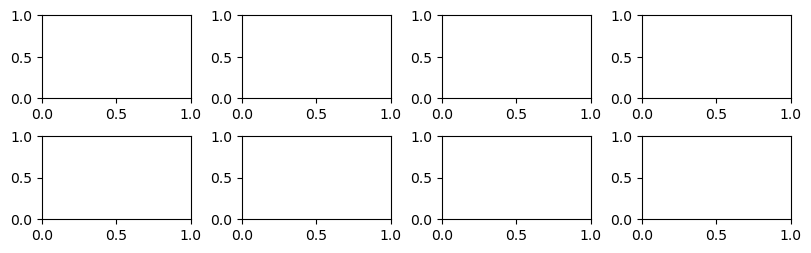

In [49]:
var_ch = 2
bat_ch = 0

units = [r'm$^2$s$^{−2}$', '°C', '°C', r'ms$^{-1}$',r'ms$^{-1}$', r'ms$^{-1}$']

time_labels=k_series

dt = len(time_labels)
dx = forecast.shape[4]
dy = forecast.shape[5]

truth_plot = (truth[bat_ch,:,var_ch]).cpu().detach().numpy().reshape((-1, dx, dy))                              #-272.15
forecast_plot = (forecast[bat_ch,:,:,var_ch]).cpu().detach().numpy().reshape((forecast.shape[1], dt, dx,dy))    #-272.15

ens_mean = forecast_plot.mean(axis=0)
ens_std = forecast_plot.std(axis=0)

cmap_z = plt.cm.get_cmap('viridis')#, 20)     #t850
cmap_t = plt.cm.get_cmap('hot')     #, 35)     #t850
cmap_u = plt.cm.get_cmap('RdBu_r')#, 30)
cmaps = [cmap_u, cmap_u, cmap_u, cmap_u, cmap_u, cmap_u]
cmap = cmaps[var_ch]

%matplotlib inline
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

fig, axes = plt.subplots(2,4, figsize=(8,2.5), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    #ax.axis('off')
    #ax.coastlines(resolution='110m', linewidth=0.5, color='k')
    #gridlines = ax.gridlines()
    #gridlines.linewidth = 0.5
    pass

title1 = axes[0,0].set_title('')
title2 = axes[0,1].set_title('')
title3 = axes[0,2].set_title('')
title4 = axes[0,3].set_title('')
#titles = []
#for j in range(1, 4):
#    axes[0,j+1].set_title(f"Sample #{j}")

images = []
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        pass
        cf = ax.pcolormesh(lon, lat, truth_plot[0], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max(), transform=ccrs.PlateCarree())
        #cf = ax.imshow(truth_plot[0], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max())
        images.append(cf)
        
    elif i == 1:
        cf = ax.pcolormesh(lon, lat, forecast_plot[0, 0], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max(), transform=ccrs.PlateCarree())
        #cf = ax.imshow(ens_mean[0], cmap=cmap)
        images.append(cf)

    elif i == 2:
        cf = ax.pcolormesh(lon, lat, ens_mean[0], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max(), transform=ccrs.PlateCarree())
        #cf = ax.imshow(ens_mean[0], cmap=cmap)
        images.append(cf)
    
    elif i == 3:
        cf = ax.pcolormesh(lon, lat, ens_std[0], cmap=cmap, vmin=0, vmax=ens_std.max(), transform=ccrs.PlateCarree())
        #cf = ax.imshow(ens_std[0], cmap=cmap, vmin=0, vmax=ens_std.max())
        images.append(cf)
        cbar_mean = fig.colorbar(cf, ax=ax, orientation='vertical', fraction=0.025, pad=0.04)
        cbar_mean.set_label('Std Dev.')

    else:
        pass
        cf = ax.pcolormesh(lon, lat, forecast_plot[i-3,0], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max(), transform=ccrs.PlateCarree())
        #cf = ax.imshow(forecast_plot[i-3,0], cmap=cmap, vmin=forecast_plot.min(), vmax=forecast_plot.max())
        images.append(cf)
        ax.set_title(f'Sample #{i-2}')
        if i == len(axes.flatten()) - 1:
            cbar_mean = fig.colorbar(cf, ax=ax, orientation='vertical',fraction=0.025, pad=0.04)
            cbar_mean.set_label(units[var_ch])


# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        if i == 0:
            im.set_array(truth_plot[n].flatten())
        elif i == 1:
            im.set_array(forecast_plot[0,n].flatten())
        elif i == 2:
            im.set_array(ens_mean[n].flatten())
        elif i == 3:
            im.set_array(ens_std[n].flatten())
        else:
            pass
            im.set_array(forecast_plot[i-3,n].flatten())

    #txt_title.set_text(f't={time_labels[n].item()}h')
    title1.set_text('Truth')
    title2.set_text('Deterministic')
    title3.set_text('Ensemble mean')
    title4.set_text('Ensemble Std')
# 
    return images

drawframe(39)
#plt.savefig(f'figures/paper/forecast-{var_names[var_ch]}.png', transparent=True, dpi=600, bbox_inches='tight')
#plt.savefig(f'figures/paper/pdfs/forecast-{var_names[var_ch]}.pdf', transparent=True, dpi=600, bbox_inches='tight')


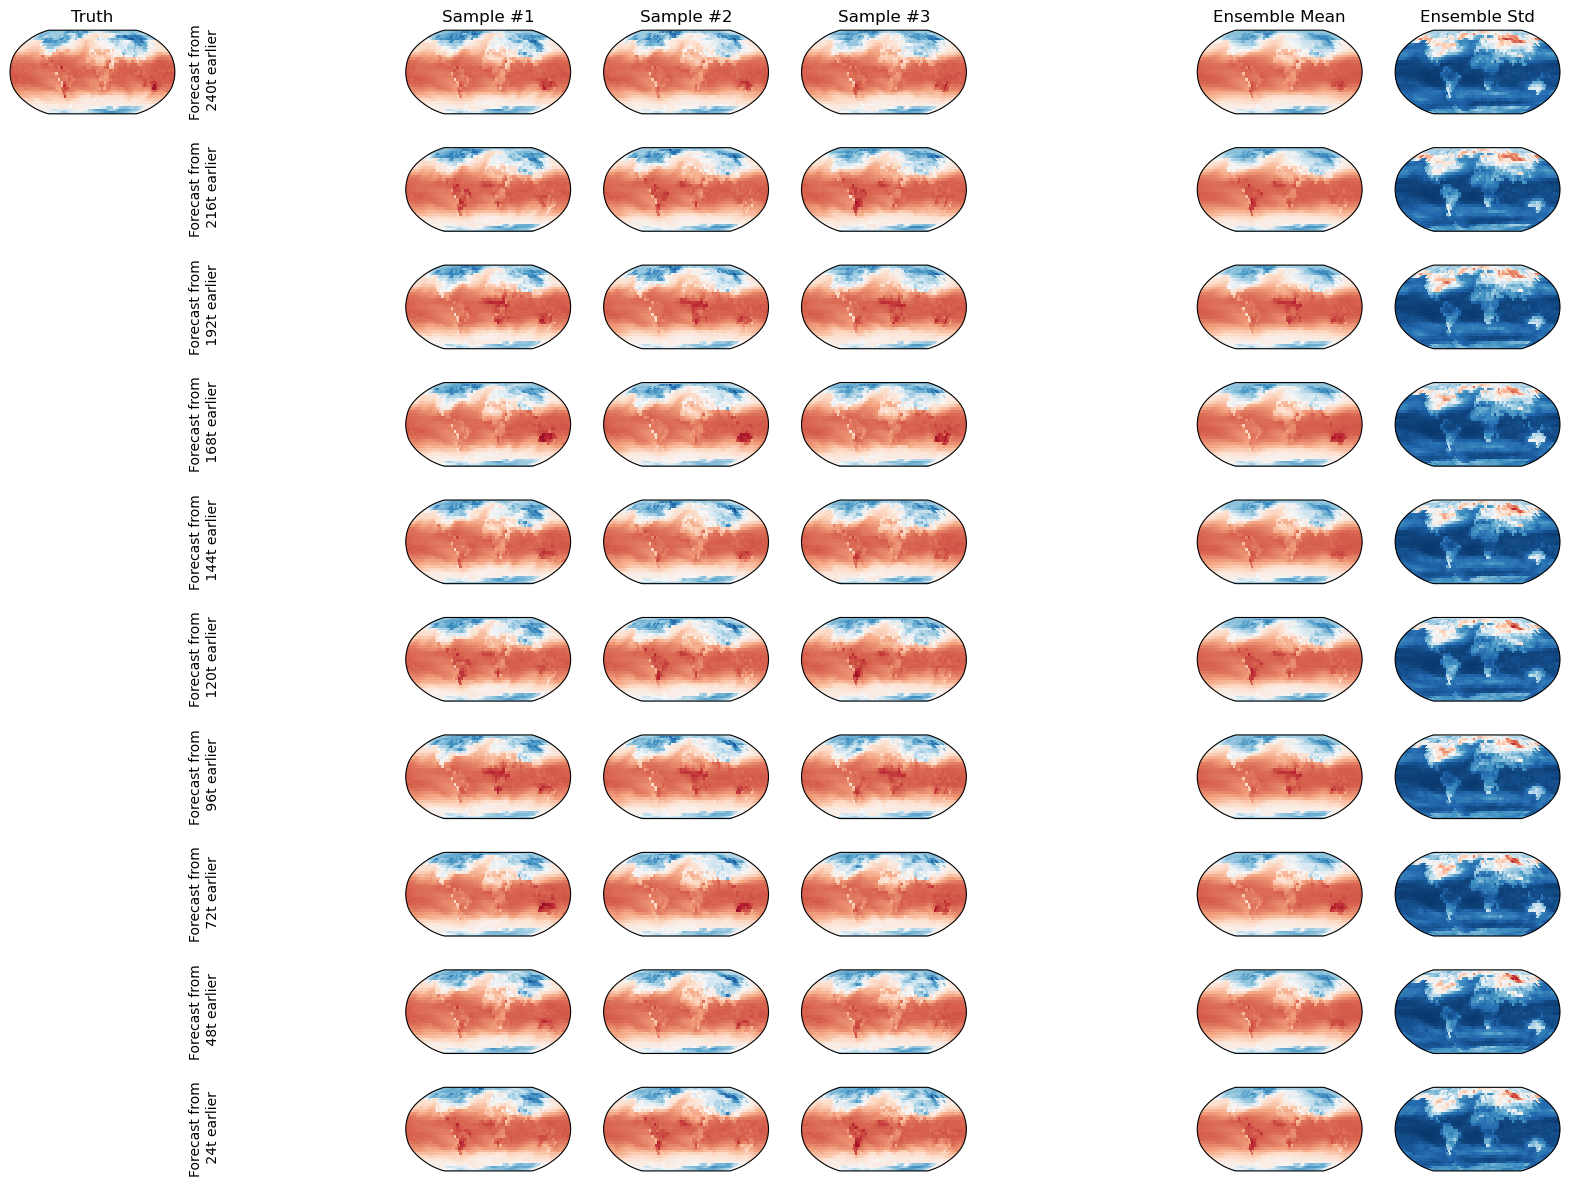

In [75]:
import matplotlib.gridspec as gridspec

def plot_image(ax, image, title=None, vmin=None, vmax=None):
    #image = image.cpu().detach().numpy().reshape((image.shape[1],image.shape[2]))
    #ax.imshow(image,vmin=vmin, vmax=vmax, cmap=cmap, interpolation='none')
    ax.pcolormesh(lon, lat, image,vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), cmap=cmap_u)
    if title!=None:
        ax.set_title(title)
    #ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])


no_ens_rows = forecast_plot.shape[1]
rows = no_ens_rows // 4

cols = 6 + 2
col_width_ratios = [1, 0, 1, 1, 1, 0, 1, 1]
gs = gridspec.GridSpec(rows, cols, width_ratios=col_width_ratios)

fig, axes = plt.subplots(rows, cols, figsize=(20,15), subplot_kw={'projection': ccrs.Robinson()})
#fig, axes = plt.subplots(rows,cols, figsize=(8,2.5), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})

#fig = plt.figure(figsize=(15,15))

#axes = np.empty((rows, cols), dtype=object)

#for i in range(rows):
#    for j in range(cols):
#        axes[i,j] = plt.subplot(gs[i,j])

max_value = forecast_plot[:3].max()
min_value = forecast_plot[:3].min()

plot_image(axes[0,0], truth_plot[-1], "Truth", vmin=min_value, vmax=max_value)
#cf = axes[0,0].pcolormesh(lon, lat, truth_plot[-1], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max(), transform=ccrs.PlateCarree())


for j in range(1, 4):
    axes[0,j+1].set_title(f"Sample #{j}")
axes[0,6].set_title("Ensemble Mean")
axes[0,7].set_title(f"Ensemble Std")


for key, i in enumerate(np.arange(0, no_ens_rows)[::4]):
    if key > 0:
        axes[key,0].axis('off')
    axes[key,1].text(1.18,0.5, f"Forecast from\n {time_labels[-(i+1)].item()}t earlier", horizontalalignment='center', verticalalignment='center', rotation=90, transform=axes[key,0].transAxes)
    
    axes[key,1].axis('off')
    axes[key,5].axis('off')

    for j in range(1, 4):
        plot_image(axes[key,j+1], forecast_plot[j,-(key+1)], vmin=min_value, vmax=max_value)
    plot_image(axes[key,6], ens_mean[-(key+1)], vmin=min_value, vmax=max_value)
    plot_image(axes[key,7], ens_std[-(key+1)], vmin=0, vmax=ens_std.max())


plt.savefig('figures/paper/large_ensemble_plot.png', dpi=600, format='png', bbox_inches='tight')#, pad_inches=0.1, transparent=True, quality=95, optimize=True)
plt.show()

##### **State:** Forecast over lead time

In [ ]:
t_kmin = 50
t_kmax = 150
t_d = 50

k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for previous, current, time_label in (val_time_series_loader):
        current = current.to(device).permute(1,0,2,3)
        previous = previous.to(device)

        current_latent = autoencoder.encoder(current)

        time_labels = time_label[0].to(device)
        
        previous_latent = autoencoder.encoder(previous)
        
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        target_latent =  (current_latent - previous_latent) / scaling
        
        class_labels = previous_latent.repeat(current.shape[0], 1, 1, 1)

        current_unnormalized = current * std_data + mean_data
        previous_unnormalized = previous * std_data + mean_data

        break

In [ ]:
n_ens = 3

ensembles = []
with torch.no_grad():

    for i in tqdm(range(n_ens)):    
        latents = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
        predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/lead_time_max, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_latent = previous_latent + predicted_residuals * scaling

        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data

        ensembles.append(predicted_unnormalized)

ensembles = torch.stack(ensembles)
ens_mean = ensembles.mean(dim=0)
ens_std = ensembles.std(dim=0)


In [ ]:
import matplotlib.gridspec as gridspec


def plot_image(ax, image, title=None, vmin=None, vmax=None):
    image = image.cpu().detach().numpy().reshape((image.shape[1],image.shape[2]))
    ax.imshow(image,vmin=vmin, vmax=vmax, cmap=cmap, interpolation='none')
    if title!=None:
        ax.set_title(title)
    #ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])

def place_text(ax, text):
    ax.text(-0.1,0.5, text, horizontalalignment='center', verticalalignment='center', rotation=90, transform=ax.transAxes)

max_value = max([ensembles[:3].max(), current_unnormalized.max(), ens_mean.max()])
min_value = min([ensembles[:3].min(), current_unnormalized.min(), ens_mean.min()])

no_ens_rows =  ensembles.shape[1]

cols = current_unnormalized.shape[0]

gs = gridspec.GridSpec(no_ens_rows, cols)#, width_ratios=col_width_ratios)

fig = plt.figure(figsize=(15,15))#, constrained_layout=True)


axes = np.empty((no_ens_rows, cols), dtype=object)
for i in range(no_ens_rows):
    for j in range(cols):
        axes[i,j] = plt.subplot(gs[i,j])


place_text(axes[0,0], "Truth")
place_text(axes[1,0], "Sample #1")
place_text(axes[2,0], "Sample #2")
place_text(axes[3,0], "Sample #3")
place_text(axes[4,0], "Ensemble Mean")
place_text(axes[5,0], "Ensemble Std")

for i in range(cols):
    

    plot_image(axes[0,i], current_unnormalized[i], f't={time_labels[i]}', vmin=min_value, vmax=max_value)
    
    for j in range(1, 4):
        plot_image(axes[j, i], ensembles[j-1, i], vmin=min_value, vmax=max_value)
    
    plot_image(axes[4,i], ens_mean[i], vmin=min_value, vmax=max_value)
    plot_image(axes[5,i], ens_std[i], vmin=0, vmax=ens_std.max())


plt.savefig('figures/long_ensemble_plot.pdf', dpi=100, format='pdf', bbox_inches='tight')#, pad_inches=0.1, transparent=True, quality=95, optimize=True)
plt.show()



In [ ]:
cond = previous_unnormalized.cpu().detach().numpy()[0,0]
forecast = ensembles[0,:,0].cpu().detach().numpy()

plt.figure(figsize=(5,5))

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
axes.imshow(forecast[2], cmap=cmap)
axes.axis('off')

plt.tight_layout()

plt.savefig('figures/direct3.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

##### **State:** Iterative vs Direct Forecasting

In [ ]:
t_kmin = 10
t_kmax = 150
t_d = 10

k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

model.eval()  # Set model to evaluation mode


with torch.no_grad():
    for previous, current, time_label in (val_time_series_loader):

        current = current.to(device).permute(1,0,2,3)
        previous = previous.to(device)

        current_latent = autoencoder.encoder(current)

        time_labels = time_label[0].to(device)
        previous_latent = autoencoder.encoder(previous)
        
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        target_latent =  (current_latent - previous_latent) / scaling
        
        class_labels = previous_latent.repeat(current.shape[0], 1, 1, 1)

        current_unnormalized = current * std_data + mean_data
        previous_unnormalized = previous * std_data + mean_data

        break

In [ ]:
n_ens = 3

latents_list = []
ensembles_list = []

for i in range(n_ens): 
    latents = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
    latents_list.append(latents)

latents_list = torch.stack(latents_list)

In [ ]:
roll_outs = len(time_labels)

ensembles = []
ensembles_ar = []
with torch.no_grad():
    start_time = time.time()
    for i in range(n_ens):
        # Direct  
        #latents = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
        latents = latents_list[i]
        predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/lead_time_max, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_latent = previous_latent + predicted_residuals * scaling
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))
        predicted_unnormalized = predicted * std_data + mean_data
        ensembles.append(predicted_unnormalized)
    
    direct_time = time.time() - start_time
    # Autoreg
    latents = latents_list[:,0]
    prev_pred = class_labels[0].repeat(n_ens, 1, 1, 1)
    time_label = time_labels[0].repeat(n_ens)
    scale = residual_scaling(time_label).view(-1, 1, 1, 1)

    for i in range(roll_outs):
        predicted_ar_residuals = heun_sampler(model, latents, prev_pred, time_label/lead_time_max, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_ar_latent = prev_pred + predicted_ar_residuals * scale
        
        predicted_ar = autoencoder.decoder(predicted_ar_latent.to(torch.float32))
        
        prev_pred = predicted_ar_latent
        
        predicted_unnormalized_ar = predicted_ar * std_data + mean_data
        ensembles_ar.append(predicted_unnormalized_ar)
    
    iterative_time = time.time() - start_time - direct_time

ensembles = torch.stack(ensembles)
ensembles_ar = torch.stack(ensembles_ar).permute(1,0,2,3,4)

print(f"Direct sampling time: {direct_time:.2f}s")
print(f"Iterative sampling time: {iterative_time:.2f}s")

In [ ]:
dt = len(time_labels)
dx = ensembles.shape[3]
dy = ensembles.shape[4]

truth = current_unnormalized.cpu().detach().numpy().reshape((-1, dx, dy))
cond = previous_unnormalized.cpu().detach().numpy().reshape((-1, dx, dy))
forecasts_dir = ensembles.cpu().detach().numpy().reshape((n_ens, dt, dx,dy))
forecasts_ar = ensembles_ar.cpu().detach().numpy().reshape((n_ens, dt, dx,dy))

ens_mean_dir = forecasts_dir.mean(axis=0)
ens_std_dir = forecasts_dir.std(axis=0)

ens_mean_ar = forecasts_ar.mean(axis=0)
ens_std_ar = forecasts_ar.std(axis=0)

In [ ]:
en = 0
ti = 2

fig, axes = plt.subplots(1, 1, figsize=(4, 4))
#axes.imshow(forecasts_dir[en, ti], cmap=cmap)
axes.imshow(forecasts_ar[en, ti], cmap=cmap)
#axes.imshow(cond[0], cmap=cmap)
axes.axis('off')

plt.tight_layout()

plt.savefig(f'figures/iterative3.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
cond.shape

In [ ]:
en = 2

fig, axes = plt.subplots(1, 1, figsize=(4, 4))
axes.axis('off')
plt.tight_layout()

for ti in range(len(time_labels)):
    #axes.imshow(forecasts_ar[en, ti], cmap=cmap)
    axes.imshow(truth[ti], cmap=cmap)
    pass
    plt.savefig(f'gifs/truth/truth-{ti+1}.pdf', format='pdf', bbox_inches='tight', dpi=300)

#axes.imshow(cond[0], cmap=cmap)

#plt.savefig(f'gifs/truth/truth-{0}.pdf', format='pdf', bbox_inches='tight', dpi=300)
#plt.show()

In [ ]:
en = 2

fig, axes = plt.subplots(1, 1, figsize=(4, 4))
axes.axis('off')
plt.tight_layout()

axes.imshow(cond[0], cmap=cmap)

#plt.savefig(f'figures/an_dir.pdf', format='pdf', bbox_inches='tight', dpi=300)
#plt.show()

In [ ]:
%matplotlib inline
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

fig, axes = plt.subplots(3,3, figsize=(10,11), constrained_layout=True)

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    ax.axis('off')

title1 = axes[0,0].set_title('')
title2 = axes[0,1].set_title('')
title3 = axes[0,2].set_title('')

images = []
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        pass
        images.append(ax.imshow(truth[0], cmap=cmap))
    elif i == 1:
        images.append(ax.imshow(ens_mean_ar[0]))
    elif i == 2:
        images.append(ax.imshow(ens_mean_dir[0], cmap=cmap))
    elif i <=5:
        images.append(ax.imshow(forecasts_dir[i-3,0], cmap=cmap))
        ax.set_title(f'Direct #{i-2}')
    else:
        images.append(ax.imshow(forecasts_ar[i-6,0], cmap=cmap))
        ax.set_title(f'Iterative #{i-5}')

# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        if i == 0:
            pass
            im.set_array(truth[n])
        elif i == 1:
            im.set_array(ens_mean_ar[n])
        elif i == 2:
            im.set_array(ens_mean_dir[n])
        elif i < 6:
            im.set_array(forecasts_dir[i-3,n])
        else:
            im.set_array(forecasts_ar[i-6,n])


    txt_title.set_text(f't={time_labels[n].item()}')
    title1.set_text('Truth')
    title2.set_text('Ensemble Mean Iterative')
    title3.set_text('Ensemble Mean Direct')

    return images

anim = animation.FuncAnimation(fig, drawframe, frames=dt, interval=100)

#anim.save('figures/animation.gif', writer='imagemagick', fps=30)
HTML(anim.to_html5_video())

#### **Plot**

##### **Plot:** RMSE over time

In [ ]:
def rmse_plot(model, n_ens=1, n_batches=1, selected_loader=val_loader, sampler_fn=heun_sampler):
    model.eval()

    result = {}
    result['rmse_model'] = np.zeros(n_batches*batch_size)
    result['rmse_clim'] = np.zeros(n_batches*batch_size)

    with torch.no_grad():
        for count, (previous, current, time_label) in enumerate(tqdm(selected_loader)):
            current = current.to(device)
            time_label = time_label.to(device)
            if count >= n_batches:
                break

            predicted_unnormalized = generate_ensemble_from_batch(model, previous, time_label[0], n_ens=n_ens, sampler_fn=sampler_fn)

            current_unnormalized = current * std_data + mean_data
            previous_unnormalized = previous * std_data + mean_data

            #  Note that this is kind of cheating since we are using the validation set to calculate the climatology.
            #  More realistic if we have a larger batch size.
            #climatology = previous_unnormalized.mean(dim=0, keepdim=True)

            ensemble_mean = predicted_unnormalized.mean(dim=0)

            rmse_model = calculate_RMSE(ensemble_mean, current_unnormalized)
            rmse_clim = calculate_RMSE(climatology, current_unnormalized)

            result['rmse_model'][count*batch_size:count*batch_size+rmse_model.size] = rmse_model.flatten()
            result['rmse_clim'][count*batch_size:count*batch_size+rmse_model.size] = rmse_clim.flatten()

    return result

In [ ]:
lead_time = 150
batch_size = 16
val_dataset = QGDataset(lead_time=lead_time, dataset_mode='val', **QG_kwargs)
val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

n_batches = 1

# NWP

n_val = 210000
nwp_data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_LRES_{iterations}_n_{n_val}_k_{lead_time}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_LRES_{iterations}_n_{n_val}_k_{lead_time}.npy')
nwp_dataset = NWPDataset(nwp_data_path, n_val=n_val, spacing=spacing, device=device)
nwp_loader = DataLoader(nwp_dataset, batch_size=batch_size, shuffle=False)
nwp_skill = calculate_nwp_skill(n_batches=n_batches)

# Climate and skill
climatology = calculate_climatology(train_loader, n_batches=n_batches)

n_ens = 10
running_mean = 100

result = rmse_plot(model, n_ens, n_batches, selected_loader=val_loader, sampler_fn=heun_sampler)

rmse_model, rmse_clim = result['rmse_model'], result['rmse_clim']
rmse_nwp = nwp_skill[:n_batches*batch_size]

plt.figure(figsize=(5,5))
plt.title(f'{lead_time} step ahead prediction, {n_ens} ensemble members')
plt.plot(uniform_filter1d(rmse_model, size=running_mean), label='Ensemble Mean', color='b')
plt.plot(uniform_filter1d(rmse_clim, size=running_mean), label='Climatology', color='r')
plt.plot(uniform_filter1d(rmse_nwp, size=running_mean), label='NWP', color='g')
plt.ylim(0,11)
plt.xlabel('Time', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def rmse_density_plot(ensemble_rmses, ensemble_skill):
    plt.figure(figsize=(6,6))
    plt.hist(ensemble_rmses, bins=100)
    plt.axvline(ensemble_skill, color='red', linestyle='--')
    plt.xlabel('Ensemble RMSEs')
    plt.ylabel('Density')
    plt.title('Density Plot of Ensemble RMSEs')
    plt.show()

rmse_density_plot(ensemble_rmses, ensemble_skill)

##### **Plot:** Spread vs time

In [ ]:
# Fixed k sampling
# Way to load a single trajectory. Only uses 1 batch.
t_kmin = 6
t_kmax = 24*5
t_d = 6
k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

n_batches = 10

spread_list = []
skill_list = []
ratio_list = []
wrmses_list = []
persistence_list = []


for i in tqdm(range(n_batches)):
        
    model.eval()  # Set model to evaluation mode

    n_ens = 10

    with torch.no_grad():
        for previous, current, time_label in (val_time_series_loader):
            current = current.to(device).permute(1,0,2,3)
            previous = previous.to(device)

            #current_latent = autoencoder.encoder(current)
            current_latent = current
            time_labels = time_label[0].to(device)
            
            #previous_latent = autoencoder.encoder(previous)
            previous_latent = previous

            previous_latent = previous[:,0].unsqueeze(1)
            scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
            target_latent =  (current_latent)# - previous_latent) / scaling
            
            class_labels = previous.repeat(current.shape[0], 1, 1, 1)

            current_unnormalized = current * std_data + mean_data
            previous_unnormalized = previous * std_data + mean_data

            break


    ensembles = []
    with torch.no_grad():
        for i in (range(n_ens)):    
            latents = torch.randn_like(previous_latent[0].unsqueeze(0), device=device).repeat(current.shape[0], 1, 1, 1)

            predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/lead_time_max, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
            predicted_latent = predicted_residuals # * scaling + previous_latent

            #predicted = autoencoder.decoder(predicted_latent.to(torch.float32))
            predicted = predicted_latent
            predicted_unnormalized = predicted * std_data + mean_data

            ensembles.append(predicted_unnormalized)

    ensembles = torch.stack(ensembles)
    ens_mean = ensembles.mean(dim=0)


    spreads = []
    skills = []
    wrmses = []
    persistences = []

    for i in range(len(time_labels)):
        truth = current_unnormalized[i]
        predicted = ens_mean[i]
        ensemble = ensembles[:, i]
        
        # Mew
        wrmse = calculate_WRMSE(ensemble, truth)
        wrmse = np.mean(wrmse)
        
        skill = calculate_WRMSE(ensemble.mean(dim=0, keepdim=True), truth)
        spread = calculate_WSpread(ensemble, truth)
        wrmses.append(wrmse)
        #skills.append(skill)
        #spreads.append(spread)

        p_wrmse = calculate_WRMSE(previous_unnormalized.unsqueeze(0), truth)
        persistences.append(p_wrmse[0])
    

        # old
        #skill, spread,_ = calculate_skill_and_spread_score(ensemble, truth)
        spreads.append(spread[0])
        skills.append(skill[0])
    
    spread_list.append(spreads)
    skill_list.append(skills)
    ratio_list.append(np.array(spreads)/np.array(skills))
    wrmses_list.append(wrmses)
    persistence_list.append(persistences)

spread_list = np.array(spread_list)
skill_list = np.array(skill_list)
ratio_list = np.array(ratio_list)
wrmses_list = np.array(wrmses_list)
persistence_list = np.array(persistence_list)
time_labels = time_labels.cpu().detach().numpy()

In [ ]:
spreads = spread_list.mean(axis=0)
skills = skill_list.mean(axis=0)
wrmses = wrmses_list.mean(axis=0)
persistences = persistence_list.mean(axis=0)

plt.figure(figsize=(5/1.2,3/1.2))
plt.xlabel('Lead time (days)')
plt.grid('on')

#plt.xticks([0,50,100,150])
plt.xticks([0,24,48,72, 24*4, 24*5, 24*6, 24*7])
#plt.xlim([-10,160])
#plt.yticks([0,2,4,6])
#plt.ylim(0-0.3, 6+0.3)

days = [t/24 for t in time_labels]
plt.xticks([1, 2, 3, 4, 5])
plt.yticks([0,200,400,600,800,1000,1200])


plt.plot(days, uniform_filter1d(spreads, size=1), label='Spread', color='#0000FF')
plt.plot(days, uniform_filter1d(skills, size=1), label='Skill', color='#EE82EE')
plt.plot(days, uniform_filter1d(wrmses, size=1), label='Avg WRMSE', color='#EE82EE', linestyle='dashed')
plt.plot(days, uniform_filter1d(persistences, size=1), label='Persistence', color='k')

plt.legend()

plt.savefig(f'figures/skill_spread_{lead_time}_{n_ens}.pdf', dpi=100, format='pdf', bbox_inches='tight')

##### **Plot:** Rank Histogram

In [ ]:
def generate_ensembles(n_ens, n_batches, selected_loader=val_loader):
    model.eval()

    ensembles = []
    truths = []

    with torch.no_grad():
        for count, (previous, current, time_label) in enumerate(tqdm(selected_loader, total=n_batches)):
            if count >= n_batches:
                break
            current = current.to(device)

            predicted_unnormalized = generate_ensemble_from_batch(model, previous, time_label[0], n_ens=n_ens, sampler_fn=heun_sampler)
            current_unnormalized = current * std_data + mean_data

            ensembles.append(predicted_unnormalized)
            truths.append(current_unnormalized)

    ensembles = torch.cat(ensembles, dim=1)
    truths = torch.cat(truths, dim=0)
    return ensembles, truths


lead_time = 150
batch_size = 16
val_dataset = QGDataset(lead_time=lead_time, dataset_mode='val', **kwargs)
val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

n_ens = 1
n_batches = 1

ensembles, truths = generate_ensembles(n_ens, n_batches, selected_loader=val_loader)

In [ ]:
# Rank Histogram

def calculate_rank(predicted, target):
    ranks = (target[None, :] < predicted).sum(axis=0)
    return ranks

def rank_histogram(pixel, ensembles, truths):

    pixel_x, pixel_y = pixel
    
    ensemble = ensembles[:, :, 0, pixel_x, pixel_y]
    target = truths[:, 0, pixel_x, pixel_y]

    rank = calculate_rank(ensemble, target)

    return rank.cpu().detach().numpy()

In [ ]:
# New look

ranks = np.zeros(n_ens+1)
for i in range(0, truths.shape[2]):
    for j in range(0, truths.shape[3]):
        pixel = (i,j)
        rank = rank_histogram(pixel, ensembles, truths)
        freq = np.bincount(rank, minlength=n_ens+1)
        ranks += freq

print(f'{n_ens} members, {n_batches*batch_size} samples')
plt.figure(figsize=(3,3))
plt.title(f'k={lead_time}')
plt.plot(np.linspace(0,1,n_ens+1), ranks*(n_ens+1)/(sum(ranks)), color='black')
plt.xlabel('Rank (normalized)')
plt.ylabel('Frequency')
plt.ylim(-0.1,2.1)
plt.yticks([0,0.5,1,1.5,2])
plt.xticks([0,0.25,0.5,0.75,1])
plt.axhline(1, color='k', linestyle='--', alpha=0.5)

plt.savefig(f'figures/rank_histogram_{lead_time}_{n_ens}_{n_batches*batch_size}.pdf', dpi=100, format='pdf', bbox_inches='tight')#, pad_inches=0.1, transparent=True, quality=95, optimize=True)

In [ ]:
pixel = (np.random.randint(0, truths.shape[2]), np.random.randint(0, truths.shape[3]))
print(pixel)
#pixel = (1,33)
ranks = np.zeros(n_ens+1)
rank = rank_histogram(pixel, ensembles, truths)
freq = np.bincount(rank, minlength=n_ens+1)
ranks += freq

plt.figure(figsize=(4,4))
plt.title(f'{lead_time} lead time, {n_ens} members, {n_batches*batch_size} samples')
plt.bar(np.arange(n_ens+1), ranks/(sum(ranks)), facecolor='white', edgecolor='black')
plt.axhline(1/(n_ens+1), color='k', linestyle='--')

##### **Plot:** Temporal consistency evaluation

In [ ]:
# Fixed k sampling
# Way to load a single trajectory. Only uses 1 batch.
t_kmin = 6
t_kmax = 120
t_d = 6
k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

n_batches = 1

spread_list = []
skill_list = []
ratio_list = []

for i in (range(n_batches)):
        
    model.eval()  # Set model to evaluation mode

    n_ens = 10

    with torch.no_grad():
        for previous, current, time_label in (val_time_series_loader):
            current = current.to(device).permute(1,0,2,3)
            previous = previous.to(device)

            current_latent = current#autoencoder.encoder(current)

            time_labels = time_label[0].to(device)
            
            previous_latent = previous#autoencoder.encoder(previous)
            
            scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
            target_latent =  (current_latent - previous_latent) / scaling
            
            class_labels = previous_latent.repeat(current.shape[0], 1, 1, 1)

            current_unnormalized = current * std_data + mean_data
            previous_unnormalized = previous * std_data + mean_data

            break


    ensembles = []
    with torch.no_grad():
        for i in tqdm(range(n_ens)):    
            latents = torch.randn_like(class_labels[0].unsqueeze(0), device=device).repeat(class_labels.shape[0], 1, 1, 1)

            predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/lead_time_max, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
            predicted_latent = previous_latent + predicted_residuals * scaling

            predicted = predicted_latent#autoencoder.decoder(predicted_latent.to(torch.float32))

            predicted_unnormalized = predicted * std_data + mean_data

            ensembles.append(predicted_unnormalized)

    ensembles = torch.stack(ensembles)
    ens_mean = ensembles.mean(dim=0)


    spreads = []
    skills = []

    for i in range(len(time_labels)):
        truth = current_unnormalized[i]
        predicted = ens_mean[i]
        ensemble = ensembles[:, i]

        skill, spread,_ = calculate_skill_and_spread_score(ensemble, truth)
        spreads.append(spread[0])
        skills.append(skill[0])
    
    spread_list.append(spreads)
    skill_list.append(skills)
    ratio_list.append(np.array(spreads)/np.array(skills))

spread_list = np.array(spread_list)
skill_list = np.array(skill_list)
ratio_list = np.array(ratio_list)
time_labels = time_labels.cpu().detach().numpy()

In [ ]:
same_latent = ((ensembles[1:, 1:] - ensembles[1:, :-1])**2).mean(dim=(2,3,4)).sqrt().cpu().permute(1,0)
different_latent = ((ensembles[1:, 1:] - ensembles[:-1, :-1])**2).mean(dim=(2,3,4)).sqrt().cpu().permute(1,0)

print(same_latent.mean(), different_latent.mean())

In [ ]:
plt.figure(figsize=(3,3))

plt.xlabel('Lead time')
plt.ylabel('RMS($X_{t+1}$, $X_t$)')

#plt.xticks([0,50,100,150])
#plt.xlim([-10,160])
#plt.yticks([0,2,4,6])
#plt.ylim(0-0.3, 6+0.3)

#plt.plot(different_latent, label = "Uncorrelated", color='#EE82EE')
plt.plot(same_latent.mean(dim=1), label = "DEFfusion", color='#0000FF')

#plt.legend(loc='upper left')

plt.savefig(f'figures/temporal_coherence.pdf', dpi=100, format='pdf', bbox_inches='tight')

#### **Animation**

##### **Animation:** Direct forecasting

In [ ]:
t_kmin = 6
t_kmax = 24*5
t_d = 6

k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

model.eval()  # Set model to evaluation mode


with torch.no_grad():
    for previous, current, time_label in (val_time_series_loader):

        current = current.to(device).permute(1,0,2,3)
        previous = previous.to(device)

        #current_latent = autoencoder.encoder(current)
        current_latent = current
        time_labels = time_label[0].to(device)
        #previous_latent = autoencoder.encoder(previous)
        previous_latent = previous[:,0].unsqueeze(1)
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        #target_latent =  (current_latent - previous_latent) / scaling
        
        class_labels = previous.repeat(current.shape[0], 1, 1, 1)

        current_unnormalized = current #* std_data + mean_data
        previous_unnormalized = previous_latent #* std_data + mean_data

        break

In [ ]:
n_ens = 6

latents_list = []
ensembles_list = []

for i in range(n_ens): 
    latents = torch.randn_like(previous_latent[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
    latents_list.append(latents)

latents_list = torch.stack(latents_list)

In [ ]:
roll_outs = len(time_labels)

ensembles = []
ensembles_ar = []
with torch.no_grad():

    for i in tqdm(range(n_ens)):
        latents = latents_list[i]
        predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/lead_time_max, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_latent = predicted_residuals# * scaling + previous_latent
        #predicted = autoencoder.decoder(predicted_latent.to(torch.float32))
        predicted = predicted_latent
        predicted_unnormalized = predicted * std_data + mean_data
        ensembles.append(predicted_unnormalized)

ensembles = torch.stack(ensembles)

In [ ]:
dt = len(time_labels)
dx = ensembles.shape[3]
dy = ensembles.shape[4]

truth = current_unnormalized.cpu().detach().numpy().reshape((-1, dx, dy))
forecasts = ensembles.cpu().detach().numpy().reshape((n_ens, dt, dx,dy))

ens_mean = forecasts.mean(axis=0)
ens_std = forecasts.std(axis=0)

In [ ]:
truth = (current_unnormalized - previous_unnormalized).cpu().detach().numpy().reshape((-1, dx, dy))
forecasts = (ensembles- previous_unnormalized).cpu().detach().numpy().reshape((n_ens, dt, dx,dy))


In [ ]:
%matplotlib inline
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

cmap = plt.cm.get_cmap('viridis', 40)


# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

fig, axes = plt.subplots(3,3, figsize=(10,5), constrained_layout=True)

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    ax.axis('off')

title1 = axes[0,0].set_title('')
title2 = axes[0,1].set_title('')
title3 = axes[0,2].set_title('')

images = []
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        pass
        images.append(ax.imshow(truth[0], cmap=cmap, vmin=truth.min(), vmax=truth.max()))
    elif i == 1:
        images.append(ax.imshow(ens_mean[0], cmap=cmap))
    elif i == 2:
        images.append(ax.imshow(ens_std[0], cmap=cmap, vmin=0, vmax=ens_std.max()))
    else:
        images.append(ax.imshow(forecasts[i-3,0], cmap=cmap, vmin=forecasts.min(), vmax=forecasts.max()))
        ax.set_title(f'Sample #{i-2}')

# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        if i == 0:
            im.set_array(truth[n])
        elif i == 1:
            im.set_array(ens_mean[n])
        elif i == 2:
            im.set_array(ens_std[n])
        else:
            im.set_array(forecasts[i-3,n])

    txt_title.set_text(f't={time_labels[n].item()}')
    title1.set_text('Truth')
    title2.set_text('Ensemble mean')
    title3.set_text('Ensemble std')
# 
    return images

anim = animation.FuncAnimation(fig, drawframe, frames=dt, interval=100)

#anim.save('figures/animation.gif', writer='imagemagick', fps=12)
HTML(anim.to_html5_video())

In [ ]:
anim.save('figures/animation_large_6h.gif', writer='imagemagick', fps=12)


In [ ]:
anim.save('figures/animation.gif', writer='imagemagick', fps=24)

##### **Animation:** Truth

In [ ]:
t_kmin = 1
t_kmax = 240
t_d = 1

k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)


with torch.no_grad():
    for previous, current, time_label in (val_time_series_loader):

        current = current.to(device).permute(1,0,2,3)

        time_labels = time_label[0].to(device)
        
        current_unnormalized = current * std_data + mean_data

        residual = current#autoencoder.encoder(current) - autoencoder.encoder(previous.to(device))
        break

In [ ]:
truth = residual[:,0].cpu().detach().numpy().reshape((-1, 16, 32))
truth.shape


In [ ]:
dt = len(time_labels)
dx = current_unnormalized.shape[2]
dy = current_unnormalized.shape[3]

truth = current_unnormalized.cpu().detach().numpy().reshape((-1, dx, dy))

#truth = residual.cpu().detach().numpy().reshape((-1, dx, dy))


In [ ]:
%matplotlib inline

cmap = plt.cm.get_cmap('hot')

from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

fig, ax = plt.subplots(1,1, figsize=(6,3), constrained_layout=True)

txt_title = fig.suptitle('', va='top')

ax.axis('off')

title1 = ax.set_title('')

images = []
im = (ax.imshow(truth[0], cmap=cmap, vmin=truth.min(), vmax=truth.max()))        


# animation function. This is called sequentially
def drawframe(n):
    
    im.set_array(truth[n])
        
    txt_title.set_text(f't={time_labels[n].item()}')
    title1.set_text('Truth')

    return images

anim = animation.FuncAnimation(fig, drawframe, frames=dt, interval=50)

#anim.save('figures/animation.gif', writer='imagemagick', fps=30)
HTML(anim.to_html5_video())

In [ ]:
import matplotlib.pyplot as plt

for i in range(dt):
    plt.imshow(truth[i], cmap=cmap)
    plt.axis('off')
    plt.savefig(f'gifs/frame_{i+1}.png', bbox_inches='tight', pad_inches=0)
    plt.close()

##### **Animation:** Iterative vs Direct Forecasting

In [ ]:
t_kmin = 10
t_kmax = 150
t_d = 10

k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

model.eval()  # Set model to evaluation mode


with torch.no_grad():
    for previous, current, time_label in (val_time_series_loader):

        current = current.to(device).permute(1,0,2,3)
        previous = previous.to(device)

        current_latent = autoencoder.encoder(current)

        time_labels = time_label[0].to(device)
        previous_latent = autoencoder.encoder(previous)
        
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        target_latent =  (current_latent - previous_latent) / scaling
        
        class_labels = previous_latent.repeat(current.shape[0], 1, 1, 1)

        current_unnormalized = current * std_data + mean_data
        previous_unnormalized = previous * std_data + mean_data

        break

In [ ]:
n_ens = 15

latents_list = []
ensembles_list = []

for i in range(n_ens): 
    latents = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
    latents_list.append(latents)

latents_list = torch.stack(latents_list)

In [ ]:
roll_outs = len(time_labels)

ensembles = []
ensembles_ar = []
with torch.no_grad():
    start_time = time.time()
    for i in range(n_ens):
        # Direct  
        #latents = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
        latents = latents_list[i]
        predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/lead_time_max, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_latent = previous_latent + predicted_residuals * scaling
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))
        predicted_unnormalized = predicted * std_data + mean_data
        ensembles.append(predicted_unnormalized)
    
    direct_time = time.time() - start_time
    # Autoreg
    latents = latents_list[:,0]
    prev_pred = class_labels[0].repeat(n_ens, 1, 1, 1)
    time_label = time_labels[0].repeat(n_ens)
    scale = residual_scaling(time_label).view(-1, 1, 1, 1)

    for i in range(roll_outs):
        predicted_ar_residuals = heun_sampler(model, latents, prev_pred, time_label/lead_time_max, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_ar_latent = prev_pred + predicted_ar_residuals * scale
        
        predicted_ar = autoencoder.decoder(predicted_ar_latent.to(torch.float32))
        
        prev_pred = predicted_ar_latent
        
        predicted_unnormalized_ar = predicted_ar * std_data + mean_data
        ensembles_ar.append(predicted_unnormalized_ar)
    
    iterative_time = time.time() - start_time - direct_time

ensembles = torch.stack(ensembles)
ensembles_ar = torch.stack(ensembles_ar).permute(1,0,2,3,4)

print(f"Direct sampling time: {direct_time:.2f}s")
print(f"Iterative sampling time: {iterative_time:.2f}s")

In [ ]:
dt = len(time_labels)
dx = ensembles.shape[3]
dy = ensembles.shape[4]

truth = current_unnormalized.cpu().detach().numpy().reshape((-1, dx, dy))
forecasts_dir = ensembles.cpu().detach().numpy().reshape((n_ens, dt, dx,dy))
forecasts_ar = ensembles_ar.cpu().detach().numpy().reshape((n_ens, dt, dx,dy))

ens_mean_dir = forecasts_dir.mean(axis=0)
ens_std_dir = forecasts_dir.std(axis=0)

ens_mean_ar = forecasts_ar.mean(axis=0)
ens_std_ar = forecasts_ar.std(axis=0)

In [ ]:
%matplotlib inline
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

fig, axes = plt.subplots(3,3, figsize=(10,11), constrained_layout=True)

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    ax.axis('off')

title1 = axes[0,0].set_title('')
title2 = axes[0,1].set_title('')
title3 = axes[0,2].set_title('')

images = []
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        pass
        images.append(ax.imshow(truth[0], cmap=cmap))
    elif i == 1:
        images.append(ax.imshow(ens_mean_ar[0]))
    elif i == 2:
        images.append(ax.imshow(ens_mean_dir[0], cmap=cmap))
    elif i <=5:
        images.append(ax.imshow(forecasts_dir[i-3,0], cmap=cmap))
        ax.set_title(f'Direct #{i-2}')
    else:
        images.append(ax.imshow(forecasts_ar[i-6,0], cmap=cmap))
        ax.set_title(f'Iterative #{i-5}')

# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        if i == 0:
            pass
            im.set_array(truth[n])
        elif i == 1:
            im.set_array(ens_mean_ar[n])
        elif i == 2:
            im.set_array(ens_mean_dir[n])
        elif i < 6:
            im.set_array(forecasts_dir[i-3,n])
        else:
            im.set_array(forecasts_ar[i-6,n])


    txt_title.set_text(f't={time_labels[n].item()}')
    title1.set_text('Truth')
    title2.set_text('Ensemble Mean Iterative')
    title3.set_text('Ensemble Mean Direct')

    return images

anim = animation.FuncAnimation(fig, drawframe, frames=dt, interval=100)

#anim.save('figures/animation.gif', writer='imagemagick', fps=30)
HTML(anim.to_html5_video())

##### **Animation:** Interpolation between latent states

In [ ]:
t_kmin = 1
t_kmax = 150
t_d = 1

k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

model.eval()  # Set model to evaluation mode


with torch.no_grad():
    for previous, current, time_label in (val_time_series_loader):

        current = current.to(device).permute(1,0,2,3)
        previous = previous.to(device)

        current_latent = autoencoder.encoder(current)

        time_labels = time_label[0].to(device)
        previous_latent = autoencoder.encoder(previous)
        
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        target_latent =  (current_latent - previous_latent) / scaling
        
        class_labels = previous_latent.repeat(current.shape[0], 1, 1, 1)

        current_unnormalized = current * std_data + mean_data
        previous_unnormalized = previous * std_data + mean_data

        break

In [ ]:
n_ens = 6

latents1 = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
latents2 = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)

alphas = np.linspace(0, 1, n_ens)

def interpolate_latents(alpha):
    return np.sqrt(1-alpha)*latents1 + np.sqrt(alpha)*latents2

latents_list = []

for alpha in alphas:
    latents_list.append(interpolate_latents(alpha))

latents_list = torch.stack(latents_list)

In [ ]:
roll_outs = len(time_labels)

ensembles = []
ensembles_ar = []
with torch.no_grad():

    for i in range(n_ens):
        latents = latents_list[i]
        predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/lead_time_max, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_latent = previous_latent + predicted_residuals * scaling
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))
        predicted_unnormalized = predicted * std_data + mean_data
        ensembles.append(predicted_unnormalized)

ensembles = torch.stack(ensembles)

In [ ]:
dt = len(time_labels)
dx = ensembles.shape[3]
dy = ensembles.shape[4]

truth = current_unnormalized.cpu().detach().numpy().reshape((-1, dx, dy))
forecasts = ensembles.cpu().detach().numpy().reshape((n_ens, dt, dx,dy))

ens_mean = forecasts.mean(axis=0)
ens_std = forecasts.std(axis=0)

In [ ]:
%matplotlib inline
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

fig, axes = plt.subplots(3,3, figsize=(10,11), constrained_layout=True)

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    ax.axis('off')

title1 = axes[0,0].set_title('')
title2 = axes[0,1].set_title('')
title3 = axes[0,2].set_title('')

images = []
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        pass
        images.append(ax.imshow(truth[0], cmap=cmap))
    elif i == 1:
        images.append(ax.imshow(ens_mean[0], cmap=cmap))
    elif i == 2:
        images.append(ax.imshow(ens_std[0], cmap=cmap, vmin=0, vmax=ens_std.max()))
    else:
        images.append(ax.imshow(forecasts[i-3,0], cmap=cmap))
        ax.set_title(f'alpha = {alphas[i-3]}')

# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        if i == 0:
            im.set_array(truth[n])
        elif i == 1:
            im.set_array(ens_mean[n])
        elif i == 2:
            im.set_array(ens_std[n])
        else:
            im.set_array(forecasts[i-3,n])

    txt_title.set_text(f't={time_labels[n].item()}')
    title1.set_text('Truth')
    title2.set_text('Ensemble mean')
    title3.set_text('Ensemble std')

    return images

anim = animation.FuncAnimation(fig, drawframe, frames=dt, interval=50)

#anim.save('figures/animation.gif', writer='imagemagick', fps=30)
HTML(anim.to_html5_video())